In [1]:
library(caret)
library(corrplot)
library(biomaRt)
library(MLeval)
library(GeneAnswers) # used to get gene names from entrez IDs

Loading required package: lattice

Loading required package: ggplot2

corrplot 0.90 loaded

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: RCurl

Loading required package: annotate

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are mask

In [ ]:
load("SavedGeneExpression.Rda")

# Literature Survey

[Mechanism-driven biomarkers to guide immune checkpoint blockade in cancer therapy
Topalian et al, 2016](https://www.nature.com/articles/nrc.2016.36)<br>
[The evolving landscape of biomarkers for checkpoint inhibitor immunotherapy
Havel et al, 2019](https://www.nature.com/articles/s41568-019-0116-x)

In [2]:
setwd("/home/jp/ICP_Responders/Literature Review")
genes_lit_sur <- read.csv("GenesOfInterest.csv")
head(genes_lit_sur)

Gene           ID   
1 PDCD1/CD279     5133
2 CD274(PDL1)    29126
3 PDCD1LG2(PDL2) 80380
4 CTLA4           1493
5 CD8A             925
6 CD4              920

# Pre-Processing
1) Clean data by removing rows with > 50% missing info <br>
2) Find the most informative features <br>
3) Split the data into test and train


## Load data
The first column is expected to be sample ID <br>
The second column is expected to be response

In [3]:
setwd("/home/jp/ICP_Responders/FinalTables")
expression <- read.csv("Final_table_response_and_expression.csv", na.strings = '..', stringsAsFactors = F)
names(expression) <- sub("^X", "", names(expression))
expression[ expression == "NA" ] <- NA
expression[,2:ncol(expression)] <- lapply(expression[, 2:ncol(expression)], as.numeric)
expression[50:60, 1:10]

Patient Response 3920        345611       3929       54210       3716       
50 31      1                 NA           NA         NA          NA          NA
51 32      1                 NA           NA         NA          NA          NA
52 33      1                 NA           NA         NA          NA          NA
53 34      1        -0.24227274  0.074304976 -0.3511685  0.54428208 -0.15006954
54 35      1        -0.48479782  0.159405465  0.4199815 -2.22883720  0.24650857
55 36      1         0.74085490  0.003467014  0.3333496 -0.03988917 -0.21346769
56 37      1                 NA           NA         NA          NA          NA
57 38      1         0.81259519 -0.048404344 -0.2250873 -0.29189077  0.44538081
58 39      0                 NA           NA         NA          NA          NA
59 4       0         0.14400922 -0.067130938  0.1120551 -0.96429947  0.10440116
60 40      1         0.07691239  0.333001919  0.5565036  0.17618231 -0.09816412
   10454       3557        3556        
50          NA          NA           NA
51          NA          NA           NA
52          NA          NA           NA
53 -0.07183968  0.20022650 -1.182660036
54 -0.38904130  1.82423349 -1.343065827
55  0.54476821 -1.69969237  0.483498059
56          NA          NA           NA
57  0.21789661 -0.08321449  1.567718745
58          NA          NA           NA
59 -0.74711659  0.30591242 -1.254576697
60  0.45014341 -0.28709491  0.002942665

## Clean data

In [4]:
# Check which column has > 50% NA values
countNA <- function(x=NULL,cutOff=NULL){
  output<-FALSE
  perc<-sum(is.na(x))*100/length(x)
  if(perc>cutOff){output<-TRUE}
  output  
}
col_nas <- apply(expression,2,function(x){countNA(x, 50)})
cat("Columns with NAs > 50% = ", sum(col_nas), "\n")
# all columns have <50% NAs

# Check which rows has > 50% NA values
row_nas <- apply(expression,1,function(x){countNA(x, 50)})
cat("Rows with NAs > 50% = ", sum(row_nas), "\n")

# 43 rows have have >50% NAs, removing them
expr_filtered <- expression[-which(row_nas %in% TRUE),]

cat("Dimensions of the filtered dataset = ", dim(expr_filtered))

Columns with NAs > 50% =  0 
Rows with NAs > 50% =  43 
Dimensions of the filtered dataset =  161 676

## Look for near zero variance and remove those columns

In [5]:
nzv <- nearZeroVar(expr_filtered[3:ncol(expr_filtered)], saveMetrics= TRUE)
nzv[which(nzv$zeroVar %in% TRUE), ]

# All features were retained and there was no filtering due to near zero variance

freqRatio percentUnique zeroVar nzv

## Look for correlation and remove highly correlated columns

In [6]:
# find attributes that are highly corrected (ideally >0.75)
tmp <- expr_filtered
tmp[is.na(tmp)] <- 0
expr_corr <-  cor(tmp[,3:ncol(tmp)]) 
highlyCorrelated <- findCorrelation(expr_corr, cutoff=0.75, names=TRUE, verbose=FALSE)
length(highlyCorrelated)
highlyCorrelated <- highlyCorrelated[highlyCorrelated %in% c(as.character(genes_lit_sur$ID)) == FALSE]   
length(highlyCorrelated)
expr_rmcorr <- expr_filtered[, -which(colnames(expr_filtered) %in% highlyCorrelated)]



[1] 181

[1] 170

## Linear dependencies(not used)
NOTE: Linear Dependencies were not used because
1) A large number of features from columns 157 to 400 were flagged as linearly dependent to columns 1 to 156 <br>
2) We will rely on feature importance and the robustness of the model selected to identify the most important features hence linear dependencies can become redundant

In [7]:
# tmp <- expr_rmcorr[, 3:ncol(expr_rmcorr)]
# tmp[is.na(tmp)] <- 0
# comboInfo <- findLinearCombos(tmp) 
# comboInfo
# rmLnCmb <- colnames(tmp[,comboInfo$remove])
# expr_rmLnCmb <- expr_rmcorr[,-which(colnames(expr_rmcorr) %in% rmLnCmb)]
cat("Started with dimension = ", dim(expression), "\n")
cat("Post 50% NA filtering in rows and columns the dimension is", dim(expr_filtered), "\n")
cat("Post filtering highly correlated columns the dimension is", dim(expr_rmcorr), "\n")
# cat("Post removing linearly dependent columns the dimension is", dim(expr_rmLnCmb))

# 495 to 506 columns when important genes weren't removed during rmcorr

Started with dimension =  204 676 
Post 50% NA filtering in rows and columns the dimension is 161 676 
Post filtering highly correlated columns the dimension is 161 506 


# Feature Selection


There are 2 kinds of feature selection: automated and manual
1) Automated<br>
Automatic feature selection methods can be used to build many models with different subsets of a dataset and identify those attributes that are and are not required to build an accurate model.The algorithm is configured to explore all possible subsets of the attributes.Then it selects the optimal number of attributes and the most important attributes. The relevant functions in CARET are: rfeControl and rfe.<br>


2) Manual<br>
For classification, ROC curve analysis is conducted on each predictor. For two class problems, a series of cutoffs is applied to the predictor data to predict the class. The sensitivity and specificity are computed for each cutoff and the ROC curve is computed. The trapezoidal rule is used to compute the area under the ROC curve. This area is used as the measure of variable importance.The relevant functions in CARET are varImp.<br>
<br>

Note: [Chen et al, 2020](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00327-4#Sec14) shows that manually selecting the topmost variables using the random forest varImp function is more accurate in identifying relevant features compared to automated methods.


[Darst et al, 2018](https://bmcgenomdata.biomedcentral.com/articles/10.1186/s12863-018-0633-8) suggested that although RF-RFE decreased the importance of correlated variables, in the presence of many correlated variables, it also decreased the importance of causal variables, making both hard to detect. These findings suggest that RF-RFE may not scale to high-dimensional data.

[Sanz et al, 2018](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2451-4#Sec3) -> SVM

In [8]:
# input for modeling
mod_inp_mat <- expr_rmcorr[, 2:ncol(expr_rmcorr)]
mod_inp_mat$Response <- as.character(mod_inp_mat$Response)
mod_inp_mat[mod_inp_mat$Response == '1',"Response"] <- 'Y' 
mod_inp_mat[mod_inp_mat$Response == '0', "Response"] <- 'N' 
mod_inp_mat$Response <- as.factor(mod_inp_mat$Response)
mod_inp_mat[is.na(mod_inp_mat)] <- 0
dim(mod_inp_mat)
#  define target and feature names
col_names = colnames(mod_inp_mat)
target = "Response"
feature_names = col_names[col_names!=target]

[1] 161 505

In [9]:
target
length(feature_names)

[1] "Response"

[1] 504

## Automated Feature Selection

In [10]:
feature_size <- c(20, 50, 100, 150, 200, 250, 300, 350, 400, 450)

### Random Forest

In [11]:
rf.control <- rfeControl(functions=rfFuncs, method="repeatedcv", number=10, repeats=3)
system.time(a.rf <- rfe(Response~., data=mod_inp_mat, 
            sizes=feature_size, 
            rfeControl=rf.control))



   user  system elapsed 
158.961   0.013 159.002 

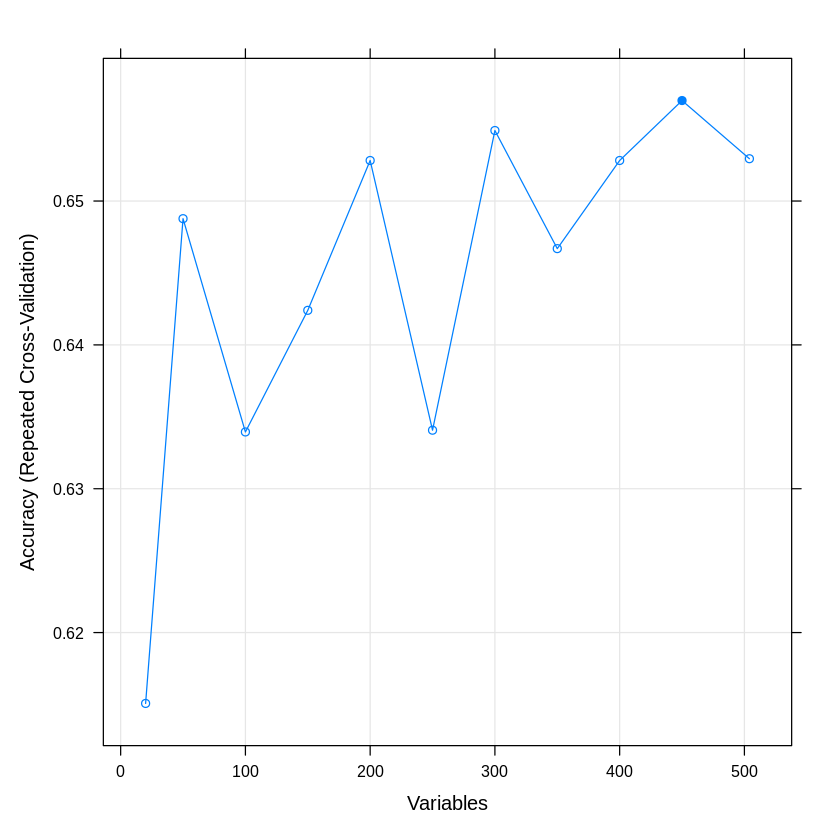

In [12]:
# list the chosen featuresplot(a.rf, type=c("g", "o"))
rf.pred <- predictors(a.rf)
# plot the results
plot(a.rf, type=c("g", "o"))
a.rf.results <- a.rf$results

In [13]:
a.rf$results

Variables Accuracy  Kappa     AccuracySD KappaSD  
1   20       0.6150735 0.1377564 0.09503639 0.1967252
2   50       0.6487745 0.1972576 0.11397972 0.2538058
3  100       0.6339461 0.1585083 0.08794261 0.1869622
4  150       0.6424020 0.1671693 0.08565648 0.1864847
5  200       0.6528186 0.1861294 0.09127663 0.2134599
6  250       0.6340686 0.1350923 0.08238810 0.1922008
7  300       0.6549020 0.1807855 0.07692304 0.1839790
8  350       0.6466912 0.1609338 0.09003070 0.2024802
9  400       0.6528186 0.1685934 0.08673657 0.1998202
10 450       0.6569853 0.1845625 0.08834167 0.2036706
11 504       0.6529412 0.1738403 0.09049156 0.2034916

In [89]:
# construct rfeControl object
nb.control = rfeControl(functions = caretFuncs, #caretFuncs here
                    method="repeatedcv",
                    number=10,
                    repeats=3)


# get results
a.nb = rfe(mod_inp_mat[,feature_names], mod_inp_mat[,target],
            sizes = feature_size,
            rfeControl = nb.control,
            method="naive_bayes")
plot(a.nb, type=c("g", "o"), ylim=c(0,1))
a.nb.results <- a.nb$results

In [112]:
# construct rfeControl object
svmPoly.control = rfeControl(functions = caretFuncs, #caretFuncs here
                    method="repeatedcv",
                    number=10,
                    repeats=3)


# get results
a.svmPoly = rfe(mod_inp_mat[,feature_names], mod_inp_mat[,target],
            sizes = feature_size,
            rfeControl = svmPoly.control,
            method="svmPoly")
plot(a.svmPoly, type=c("g", "o"), ylim=c(0,1))
a.svmPoly.results <- a.svmPoly$results

In [ ]:
# construct rfeControl object
svmRadial.control = rfeControl(functions = caretFuncs, #caretFuncs here
                    method="repeatedcv",
                    number=10,
                    repeats=3)


# get results
a.svmRadial = rfe(mod_inp_mat[,feature_names], mod_inp_mat[,target],
            sizes = feature_size,
            rfeControl = svmRadial.control,
            method="svmRadial")
plot(a.svmRadial, type=c("g", "o"), ylim=c(0,1))
a.svmRadial.results <- a.svmRadial$results

In [10]:
# saveRDS(a.rf.results, "a.rf.results.rdf")

`TODO`
Compare rf and svm results<br>
Try nb, non linear svm<br>
Find a way to store models and load them

## Manual Feature Selection

In [14]:
# define a resampling approach for caret where data is divided into 10 random subsets and prediction is done on 
# 1 using the remaining 9. This approach is repeated thrice
control <- trainControl(method="repeatedcv", number=10, repeats=3)

### glmNet
A generalized linear model (GLM) is a flexible generalization of ordinary linear regression that allows for the response variable to have an error distribution other than the normal distribution. The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

In [15]:
m.glm <- train(Response~., data=mod_inp_mat, 
                  method="glmnet", 
                  trControl=control,
                  preProcess = c("scale", "center")
                 )


In [16]:
# estimate variable importance
glm.imp <- varImp(m.glm, scale=TRUE)$importance
rownames(glm.imp) <- gsub("`", "", rownames(glm.imp))
glm.imp$Name <- rownames(glm.imp)
# summarize importance
glm.imp <- glm.imp[order(glm.imp$Overall, decreasing=TRUE),]
colnames(glm.imp) <- c("Score", "Name")
head(glm.imp)

Score     Name 
9308  100.00000 9308 
941    83.75429 941  
57823  59.81454 57823
8807   40.40982 8807 
6890   38.67335 6890 
3920    0.00000 3920

### SVM
Support vector machines (SVMs) is a representation of different classes in a hyperplane in multidimensional space. The hyperplane is generated in an iterative manner by SVM for error minimization and divide the datasets into classes to find a maximum marginal hyperplane (MMH).This is effective in high dimensional spaces.

In [17]:
m.svm <- train(Response~., data=mod_inp_mat, 
                  method="svmLinear2", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [18]:
# estimate variable importance
svm.imp <- varImp(m.svm, scale=TRUE)$importance
svm.imp$Name <- rownames(svm.imp)
# summarize importance
svm.imp <- svm.imp[order(svm.imp$N, decreasing=TRUE),]
svm.imp$N <- NULL
colnames(svm.imp) <- c("Score", "Name")
head(svm.imp)

Score     Name
925  100.00000 925 
6504  98.82199 6504
941   95.20070 941 
6890  91.88482 6890
3620  89.96510 3620
3458  86.21291 3458

### Neural Network

In [19]:
m.nnet <- train(Response~., data=mod_inp_mat, 
                  method="nnet", 
                  trControl=control,
                  preProcess = c("scale", "center"))

# weights:  507
initial  value 121.838866 
iter  10 value 82.251274
iter  20 value 76.061018
iter  30 value 75.909223
iter  40 value 75.012198
iter  50 value 73.519761
iter  60 value 72.027478
iter  70 value 71.929422
iter  80 value 71.928917
iter  90 value 70.281643
iter 100 value 70.262667
final  value 70.262667 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 114.295683 
iter  10 value 83.585503
iter  20 value 62.493053
iter  30 value 51.020866
iter  40 value 42.537732
iter  50 value 36.900286
iter  60 value 31.826700
iter  70 value 25.854715
iter  80 value 21.347936
iter  90 value 18.307626
iter 100 value 18.160726
final  value 18.160726 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.631372 
iter  10 value 61.104215
iter  20 value 54.658374
iter  30 value 53.323450
iter  40 value 51.623722
iter  50 value 44.463180
iter  60 value 44.306757
iter  70 value 42.437521
iter  80 value 42.434204
iter  90 value 42.432399
iter 100 value 42.429236
final  value 42.429236 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.523622 
iter  10 value 88.126950
iter  20 value 69.312275
iter  30 value 56.649136
iter  40 value 51.246927
iter  50 value 47.624346
iter  60 value 45.043143
iter  70 value 43.374193
iter  80 value 42.408734
iter  90 value 40.428009
iter 100 value 40.427275
final  value 40.427275 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 107.376289 
iter  10 value 86.566699
iter  20 value 63.402502
iter  30 value 51.900264
iter  40 value 45.632441
iter  50 value 34.732465
iter  60 value 30.482457
iter  70 value 26.872214
iter  80 value 23.053977
iter  90 value 19.366201
iter 100 value 19.135810
final  value 19.135810 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 122.728576 
iter  10 value 84.195220
iter  20 value 82.692035
iter  30 value 80.475714
iter  40 value 80.407085
iter  50 value 79.585110
iter  60 value 79.582083
iter  70 value 79.577203
iter  80 value 79.572629
iter  90 value 78.412446
iter 100 value 77.825566
final  value 77.825566 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.299457 
iter  10 value 70.413263
iter  20 value 52.620176
iter  30 value 42.680683
iter  40 value 37.160059
iter  50 value 36.974980
iter  60 value 36.971015
iter  70 value 36.970003
iter  80 value 36.969237
iter  90 value 36.968965
iter 100 value 36.968841
final  value 36.968841 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 109.186773 
iter  10 value 84.176228
iter  20 value 72.638237
iter  30 value 56.485525
iter  40 value 43.607795
iter  50 value 40.047891
iter  60 value 35.949162
iter  70 value 28.761419
iter  80 value 24.278788
iter  90 value 22.797271
iter 100 value 22.037671
final  value 22.037671 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 122.267055 
iter  10 value 80.821644
iter  20 value 74.897707
iter  30 value 74.869685
iter  40 value 72.362636
iter  50 value 70.619609
iter  60 value 70.617305
iter  70 value 70.609975
iter  80 value 70.604516
iter  90 value 66.750649
iter 100 value 64.679908
final  value 64.679908 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 110.122419 
iter  10 value 82.249703
iter  20 value 62.237113
iter  30 value 54.875222
iter  40 value 54.842122
iter  50 value 54.837559
iter  60 value 54.836595
iter  70 value 54.836355
iter  80 value 53.197578
iter  90 value 52.388562
iter 100 value 52.388250
final  value 52.388250 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 111.567413 
iter  10 value 83.304757
iter  20 value 68.603937
iter  30 value 56.573630
iter  40 value 45.505426
iter  50 value 39.566335
iter  60 value 31.355086
iter  70 value 25.234748
iter  80 value 22.543926
iter  90 value 20.375779
iter 100 value 19.094617
final  value 19.094617 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.448999 
iter  10 value 87.070994
iter  20 value 68.648996
iter  30 value 61.036591
iter  40 value 60.012427
iter  50 value 58.277740
iter  60 value 55.808398
iter  70 value 55.749618
iter  80 value 55.743969
iter  90 value 54.922746
iter 100 value 51.915495
final  value 51.915495 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.102641 
iter  10 value 73.306875
iter  20 value 65.025910
iter  30 value 59.862423
iter  40 value 59.820953
iter  50 value 58.660386
iter  60 value 58.497767
iter  70 value 58.497217
iter  80 value 57.127632
iter  90 value 55.697286
iter 100 value 55.695920
final  value 55.695920 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 127.347489 
iter  10 value 84.619114
iter  20 value 67.162986
iter  30 value 55.226950
iter  40 value 39.004675
iter  50 value 29.007094
iter  60 value 19.813562
iter  70 value 16.292149
iter  80 value 15.536095
iter  90 value 15.435505
iter 100 value 15.417019
final  value 15.417019 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 136.252856 
iter  10 value 77.014901
iter  20 value 64.819488
iter  30 value 63.907049
iter  40 value 61.380163
iter  50 value 57.210938
iter  60 value 57.179971
iter  70 value 57.171765
iter  80 value 55.739651
iter  90 value 55.734441
iter 100 value 55.729284
final  value 55.729284 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 101.771346 
iter  10 value 75.271742
iter  20 value 61.114290
iter  30 value 59.824902
iter  40 value 58.493488
iter  50 value 57.128011
iter  60 value 57.125699
iter  70 value 57.124974
iter  80 value 57.124745
iter  90 value 57.124618
final  value 57.124594 
converged


Warning message:
“model fit failed for Fold06.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 119.167921 
iter  10 value 92.643347
iter  20 value 65.701459
iter  30 value 55.612589
iter  40 value 40.818849
iter  50 value 29.723857
iter  60 value 19.774495
iter  70 value 16.562205
iter  80 value 16.111445
iter  90 value 16.069705
iter 100 value 16.055632
final  value 16.055632 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.286376 
iter  10 value 84.930227
iter  20 value 67.759638
iter  30 value 65.816973
iter  40 value 61.222075
iter  50 value 59.867320
iter  60 value 59.848808
iter  70 value 57.169794
iter  80 value 57.159893
iter  90 value 54.246688
iter 100 value 54.240517
final  value 54.240517 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 119.617427 
iter  10 value 83.293160
iter  20 value 65.647596
iter  30 value 62.731031
iter  40 value 60.646166
iter  50 value 59.780211
iter  60 value 59.285158
iter  70 value 59.279132
iter  80 value 57.877196
iter  90 value 57.876633
final  value 57.876456 
converged


Warning message:
“model fit failed for Fold07.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 115.866554 
iter  10 value 76.721310
iter  20 value 64.981690
iter  30 value 56.366847
iter  40 value 54.078487
iter  50 value 38.992414
iter  60 value 31.566575
iter  70 value 25.494558
iter  80 value 22.182321
iter  90 value 18.102279
iter 100 value 15.962487
final  value 15.962487 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.401564 
iter  10 value 70.581242
iter  20 value 53.119415
iter  30 value 52.428490
iter  40 value 52.421775
iter  50 value 52.419159
iter  60 value 52.415473
iter  70 value 51.383984
iter  80 value 47.158238
iter  90 value 46.682903
iter 100 value 46.681108
final  value 46.681108 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 101.721520 
iter  10 value 87.163878
iter  20 value 73.694806
iter  30 value 70.313721
iter  40 value 70.265164
iter  50 value 70.263022
iter  60 value 70.262546
iter  70 value 70.262461
iter  80 value 70.262360
final  value 70.262352 
converged


Warning message:
“model fit failed for Fold08.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 103.835018 
iter  10 value 89.207596
iter  20 value 70.901453
iter  30 value 62.743466
iter  40 value 56.409047
iter  50 value 47.013114
iter  60 value 37.288924
iter  70 value 34.104328
iter  80 value 32.384259
iter  90 value 25.538573
iter 100 value 19.257682
final  value 19.257682 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 125.226354 
iter  10 value 80.912536
iter  20 value 70.949605
iter  30 value 63.482080
iter  40 value 63.194148
iter  50 value 63.187976
iter  60 value 63.185810
iter  70 value 63.183816
iter  80 value 61.176722
iter  90 value 59.852481
iter 100 value 57.985229
final  value 57.985229 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.847218 
iter  10 value 79.638757
iter  20 value 68.246284
iter  30 value 67.725721
iter  40 value 67.718960
iter  50 value 65.683473
iter  60 value 65.517406
iter  70 value 65.516952
final  value 65.516719 
converged


Warning message:
“model fit failed for Fold09.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 110.057466 
iter  10 value 81.328290
iter  20 value 64.425031
iter  30 value 52.508981
iter  40 value 40.135903
iter  50 value 35.547589
iter  60 value 28.068148
iter  70 value 26.681371
iter  80 value 22.736676
iter  90 value 20.009264
iter 100 value 19.047315
final  value 19.047315 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.005072 
iter  10 value 85.137162
iter  20 value 76.002779
iter  30 value 75.985049
iter  40 value 75.233751
iter  50 value 72.017626
iter  60 value 71.963012
iter  70 value 70.284812
iter  80 value 67.447007
iter  90 value 67.441941
iter 100 value 62.673666
final  value 62.673666 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.881157 
iter  10 value 78.363135
iter  20 value 68.883827
iter  30 value 60.477644
iter  40 value 58.480055
iter  50 value 56.869387
iter  60 value 56.867028
iter  70 value 55.579647
iter  80 value 55.454361
iter  90 value 53.164014
iter 100 value 53.142163
final  value 53.142163 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 120.340975 
iter  10 value 80.909220
iter  20 value 65.243714
iter  30 value 55.670945
iter  40 value 49.666900
iter  50 value 38.546220
iter  60 value 32.815630
iter  70 value 28.501382
iter  80 value 25.526369
iter  90 value 19.754638
iter 100 value 19.122447
final  value 19.122447 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 95.886896 
iter  10 value 86.169645
iter  20 value 73.640563
iter  30 value 70.653970
iter  40 value 70.610031
iter  50 value 67.902333
iter  60 value 66.691157
iter  70 value 66.680762
iter  80 value 64.876647
iter  90 value 64.834046
iter 100 value 64.831004
final  value 64.831004 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.776384 
iter  10 value 80.471651
iter  20 value 74.875393
iter  30 value 71.548273
iter  40 value 69.874408
iter  50 value 69.817179
iter  60 value 68.100604
iter  70 value 65.153416
iter  80 value 61.908454
iter  90 value 54.931771
iter 100 value 53.456300
final  value 53.456300 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 112.910899 
iter  10 value 90.013137
iter  20 value 62.823692
iter  30 value 50.802267
iter  40 value 39.831688
iter  50 value 27.814968
iter  60 value 24.147159
iter  70 value 21.024259
iter  80 value 18.730180
iter  90 value 18.452054
iter 100 value 18.238333
final  value 18.238333 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.847444 
iter  10 value 75.734117
iter  20 value 54.388234
iter  30 value 51.407272
iter  40 value 49.806753
iter  50 value 48.284263
iter  60 value 48.278252
iter  70 value 48.274891
iter  80 value 46.696368
iter  90 value 43.768317
iter 100 value 43.742154
final  value 43.742154 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.748148 
iter  10 value 77.597894
iter  20 value 65.573201
iter  30 value 61.305934
iter  40 value 61.092775
iter  50 value 58.890067
iter  60 value 58.887148
iter  70 value 58.886168
iter  80 value 58.885988
iter  90 value 58.885748
final  value 58.885733 
converged


Warning message:
“model fit failed for Fold02.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 123.015740 
iter  10 value 89.033207
iter  20 value 67.678778
iter  30 value 54.079054
iter  40 value 44.860678
iter  50 value 34.222557
iter  60 value 28.486922
iter  70 value 23.404373
iter  80 value 16.982045
iter  90 value 16.048017
iter 100 value 16.003838
final  value 16.003838 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.515130 
iter  10 value 70.163612
iter  20 value 55.978705
iter  30 value 41.709382
iter  40 value 41.546230
iter  50 value 41.532579
iter  60 value 41.271074
iter  70 value 39.630660
iter  80 value 39.627917
iter  90 value 39.625781
iter 100 value 39.619128
final  value 39.619128 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.485012 
iter  10 value 77.994285
iter  20 value 74.482869
iter  30 value 71.855020
iter  40 value 70.262864
iter  50 value 70.213844
iter  60 value 68.510900
iter  70 value 66.640855
iter  80 value 66.637148
iter  90 value 65.521028
iter 100 value 65.517730
final  value 65.517730 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.977636 
iter  10 value 85.612235
iter  20 value 69.884353
iter  30 value 55.908465
iter  40 value 48.900244
iter  50 value 37.457000
iter  60 value 32.488666
iter  70 value 27.873469
iter  80 value 24.238027
iter  90 value 21.142033
iter 100 value 16.797470
final  value 16.797470 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 101.575354 
iter  10 value 82.810827
iter  20 value 81.587460
iter  30 value 73.106053
iter  40 value 72.073593
iter  50 value 68.923035
iter  60 value 67.664288
iter  70 value 67.148238
iter  80 value 66.447855
iter  90 value 66.427350
iter 100 value 66.293672
final  value 66.293672 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.752529 
iter  10 value 80.415805
iter  20 value 70.174676
iter  30 value 68.092483
iter  40 value 63.278306
iter  50 value 63.218650
iter  60 value 59.941655
iter  70 value 59.939935
iter  80 value 59.939330
iter  90 value 59.938899
final  value 59.938830 
converged


Warning message:
“model fit failed for Fold04.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 107.025682 
iter  10 value 90.170745
iter  20 value 74.331094
iter  30 value 64.736477
iter  40 value 52.435202
iter  50 value 40.721511
iter  60 value 35.158160
iter  70 value 30.022319
iter  80 value 27.453259
iter  90 value 21.318456
iter 100 value 18.365921
final  value 18.365921 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 112.504252 
iter  10 value 92.406337
iter  20 value 79.966267
iter  30 value 78.654030
iter  40 value 74.744553
iter  50 value 74.235729
iter  60 value 72.583003
iter  70 value 71.625914
iter  80 value 70.635622
iter  90 value 70.626058
iter 100 value 68.583192
final  value 68.583192 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 95.820228 
iter  10 value 80.151634
iter  20 value 68.873291
iter  30 value 65.895086
iter  40 value 63.540250
iter  50 value 61.104954
iter  60 value 59.834906
iter  70 value 59.821071
iter  80 value 57.720398
iter  90 value 57.586955
iter 100 value 57.586356
final  value 57.586356 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 106.276381 
iter  10 value 86.024420
iter  20 value 62.268834
iter  30 value 52.045534
iter  40 value 47.180358
iter  50 value 38.544568
iter  60 value 30.863520
iter  70 value 27.908235
iter  80 value 24.770871
iter  90 value 18.469008
iter 100 value 15.939866
final  value 15.939866 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 133.688968 
iter  10 value 79.617640
iter  20 value 65.560719
iter  30 value 63.472401
iter  40 value 62.398418
iter  50 value 62.392589
iter  60 value 62.387505
iter  70 value 61.288058
iter  80 value 61.283907
iter  90 value 59.611369
iter 100 value 58.011952
final  value 58.011952 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 94.543132 
iter  10 value 71.471067
iter  20 value 59.036383
iter  30 value 58.890388
iter  40 value 58.886554
iter  50 value 55.298880
iter  60 value 53.967776
iter  70 value 53.963103
final  value 53.963092 
converged


Warning message:
“model fit failed for Fold06.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 115.826505 
iter  10 value 90.780485
iter  20 value 69.032512
iter  30 value 51.536743
iter  40 value 42.974676
iter  50 value 33.924526
iter  60 value 29.878477
iter  70 value 23.934168
iter  80 value 20.311229
iter  90 value 16.824897
iter 100 value 16.396931
final  value 16.396931 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.956452 
iter  10 value 81.112809
iter  20 value 75.546708
iter  30 value 74.574646
iter  40 value 74.544000
iter  50 value 74.531810
iter  60 value 74.522798
iter  70 value 73.601786
iter  80 value 72.538577
iter  90 value 72.535366
iter 100 value 72.531410
final  value 72.531410 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 130.825976 
iter  10 value 91.360148
iter  20 value 85.194765
iter  30 value 83.411924
iter  40 value 82.563957
iter  50 value 78.010671
iter  60 value 75.104590
iter  70 value 75.012305
iter  80 value 74.032308
iter  90 value 74.031327
iter 100 value 74.031001
final  value 74.031001 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 112.008422 
iter  10 value 80.825603
iter  20 value 68.811061
iter  30 value 61.127695
iter  40 value 56.435337
iter  50 value 53.168825
iter  60 value 46.608857
iter  70 value 42.653441
iter  80 value 40.703677
iter  90 value 33.045380
iter 100 value 30.684239
final  value 30.684239 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.221860 
iter  10 value 86.259722
iter  20 value 76.057635
iter  30 value 75.210726
iter  40 value 74.231885
iter  50 value 73.282236
iter  60 value 72.325172
iter  70 value 68.790579
iter  80 value 68.543935
iter  90 value 68.533933
iter 100 value 66.672697
final  value 66.672697 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 91.349522 
iter  10 value 59.866089
iter  20 value 50.535493
iter  30 value 49.695937
iter  40 value 49.650611
iter  50 value 49.648776
iter  60 value 49.648540
final  value 49.648495 
converged


Warning message:
“model fit failed for Fold08.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 114.986420 
iter  10 value 86.375368
iter  20 value 66.851364
iter  30 value 46.881214
iter  40 value 38.779959
iter  50 value 34.758457
iter  60 value 28.303745
iter  70 value 26.261429
iter  80 value 22.233951
iter  90 value 21.731918
iter 100 value 19.167555
final  value 19.167555 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 94.443657 
iter  10 value 65.696958
iter  20 value 59.567755
iter  30 value 52.400288
iter  40 value 49.916810
iter  50 value 46.676781
iter  60 value 45.189603
iter  70 value 45.135836
iter  80 value 45.131786
iter  90 value 43.543857
iter 100 value 43.539900
final  value 43.539900 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 117.431313 
iter  10 value 90.621539
iter  20 value 81.585928
iter  30 value 76.747729
iter  40 value 74.474557
iter  50 value 71.614930
iter  60 value 71.572618
iter  70 value 70.580133
iter  80 value 68.773601
iter  90 value 67.723310
iter 100 value 67.719625
final  value 67.719625 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 109.249819 
iter  10 value 79.562976
iter  20 value 61.847150
iter  30 value 51.345001
iter  40 value 38.213743
iter  50 value 29.916287
iter  60 value 22.954676
iter  70 value 21.021852
iter  80 value 20.817777
iter  90 value 20.676680
iter 100 value 18.282962
final  value 18.282962 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 118.463180 
iter  10 value 79.960786
iter  20 value 73.624089
iter  30 value 72.020325
iter  40 value 69.381383
iter  50 value 69.284691
iter  60 value 67.482384
iter  70 value 61.413117
iter  80 value 59.892399
iter  90 value 57.657241
iter 100 value 57.651874
final  value 57.651874 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 113.186218 
iter  10 value 79.253971
iter  20 value 66.858809
iter  30 value 57.874582
iter  40 value 56.422743
iter  50 value 56.414121
iter  60 value 54.310963
iter  70 value 54.205580
iter  80 value 54.205348
iter  90 value 54.205170
iter 100 value 54.205074
final  value 54.205074 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.963266 
iter  10 value 84.177964
iter  20 value 68.676834
iter  30 value 55.497319
iter  40 value 51.122555
iter  50 value 40.858051
iter  60 value 33.812442
iter  70 value 30.040815
iter  80 value 26.917808
iter  90 value 24.468291
iter 100 value 24.367569
final  value 24.367569 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 95.799795 
iter  10 value 76.713828
iter  20 value 72.407092
iter  30 value 71.404971
iter  40 value 71.390905
iter  50 value 70.343091
iter  60 value 70.330433
iter  70 value 68.443909
iter  80 value 64.409074
iter  90 value 63.205562
iter 100 value 63.201891
final  value 63.201891 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.817940 
iter  10 value 81.638651
iter  20 value 77.647683
iter  30 value 76.783080
iter  40 value 76.731888
iter  50 value 75.910964
iter  60 value 74.411344
iter  70 value 73.468619
iter  80 value 71.885531
iter  90 value 71.882833
iter 100 value 71.881625
final  value 71.881625 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 109.585212 
iter  10 value 87.763657
iter  20 value 70.137557
iter  30 value 59.273808
iter  40 value 47.455494
iter  50 value 36.900415
iter  60 value 29.745909
iter  70 value 25.611211
iter  80 value 20.760528
iter  90 value 19.293685
iter 100 value 13.463150
final  value 13.463150 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.576800 
iter  10 value 89.498490
iter  20 value 56.595782
iter  30 value 53.624642
iter  40 value 46.833921
iter  50 value 45.148066
iter  60 value 43.543092
iter  70 value 38.591869
iter  80 value 38.584401
iter  90 value 38.582116
iter 100 value 38.580325
final  value 38.580325 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 112.115265 
iter  10 value 94.380743
iter  20 value 87.431824
iter  30 value 85.415716
final  value 84.891936 
converged


Warning message:
“model fit failed for Fold02.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.957565 
iter  10 value 86.748620
iter  20 value 68.985995
iter  30 value 55.158439
iter  40 value 42.041103
iter  50 value 34.649044
iter  60 value 30.240734
iter  70 value 27.258716
iter  80 value 22.069366
iter  90 value 20.918259
iter 100 value 20.792783
final  value 20.792783 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.976769 
iter  10 value 75.507904
iter  20 value 69.266548
iter  30 value 67.128509
iter  40 value 63.953429
iter  50 value 63.937018
iter  60 value 63.932387
iter  70 value 62.667545
iter  80 value 62.662627
iter  90 value 60.693994
iter 100 value 58.547769
final  value 58.547769 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 112.578233 
iter  10 value 81.763809
iter  20 value 62.982066
iter  30 value 56.684897
iter  40 value 53.418304
iter  50 value 53.386975
iter  60 value 53.182527
iter  70 value 50.276229
iter  80 value 48.617052
iter  90 value 48.609833
iter 100 value 46.053230
final  value 46.053230 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.919092 
iter  10 value 88.812975
iter  20 value 44.223815
iter  30 value 36.350332
iter  40 value 32.372337
iter  50 value 26.505100
iter  60 value 22.368321
iter  70 value 18.977826
iter  80 value 18.385083
iter  90 value 15.891428
iter 100 value 12.700449
final  value 12.700449 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.016152 
iter  10 value 74.696349
iter  20 value 63.265631
iter  30 value 56.955517
iter  40 value 55.244162
iter  50 value 50.967641
iter  60 value 50.932717
iter  70 value 48.246036
iter  80 value 45.350844
iter  90 value 45.348883
iter 100 value 45.345775
final  value 45.345775 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 121.922927 
iter  10 value 85.292940
iter  20 value 72.946409
iter  30 value 71.290619
iter  40 value 71.289678
final  value 71.289623 
converged


Warning message:
“model fit failed for Fold04.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.770032 
iter  10 value 85.118663
iter  20 value 69.363544
iter  30 value 62.345138
iter  40 value 55.973478
iter  50 value 51.469528
iter  60 value 49.893399
iter  70 value 45.667172
iter  80 value 42.029350
iter  90 value 36.152610
iter 100 value 33.158627
final  value 33.158627 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 100.675878 
iter  10 value 83.478400
iter  20 value 63.046433
iter  30 value 52.313973
iter  40 value 48.467476
iter  50 value 47.886707
iter  60 value 43.779680
iter  70 value 43.680363
iter  80 value 43.677650
iter  90 value 43.673179
iter 100 value 43.663760
final  value 43.663760 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 102.968483 
iter  10 value 82.281738
iter  20 value 56.592410
iter  30 value 52.618761
iter  40 value 52.609447
iter  50 value 52.607663
final  value 52.607350 
converged


Warning message:
“model fit failed for Fold05.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 106.266116 
iter  10 value 79.709593
iter  20 value 52.267728
iter  30 value 39.502962
iter  40 value 33.589144
iter  50 value 26.266960
iter  60 value 22.618510
iter  70 value 16.805631
iter  80 value 16.291252
iter  90 value 13.135147
iter 100 value 12.882033
final  value 12.882033 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 109.803089 
iter  10 value 86.090002
iter  20 value 81.699590
iter  30 value 79.093401
iter  40 value 77.407385
iter  50 value 74.631314
iter  60 value 70.966575
iter  70 value 70.924253
iter  80 value 66.086998
iter  90 value 59.912577
iter 100 value 59.314403
final  value 59.314403 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 107.888188 
iter  10 value 86.409790
iter  20 value 75.636393
iter  30 value 68.682424
iter  40 value 65.108510
iter  50 value 63.901902
iter  60 value 62.633034
iter  70 value 58.456347
iter  80 value 54.859957
iter  90 value 52.394687
iter 100 value 52.389750
final  value 52.389750 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 114.220209 
iter  10 value 90.975463
iter  20 value 65.823514
iter  30 value 51.755594
iter  40 value 43.983292
iter  50 value 36.585058
iter  60 value 31.107195
iter  70 value 25.197507
iter  80 value 21.994408
iter  90 value 16.250203
iter 100 value 16.000956
final  value 16.000956 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 112.043712 
iter  10 value 75.046069
iter  20 value 59.501196
iter  30 value 55.717204
iter  40 value 51.142012
iter  50 value 46.776564
iter  60 value 46.718549
iter  70 value 45.084383
iter  80 value 45.067575
iter  90 value 45.060861
iter 100 value 45.053411
final  value 45.053411 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.112360 
iter  10 value 75.609948
iter  20 value 60.325268
iter  30 value 59.035945
iter  40 value 55.295992
iter  50 value 53.967165
iter  60 value 53.964010
iter  70 value 53.963577
iter  80 value 53.963190
final  value 53.963180 
converged


Warning message:
“model fit failed for Fold07.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.331841 
iter  10 value 85.694528
iter  20 value 73.467512
iter  30 value 67.027695
iter  40 value 54.564009
iter  50 value 51.996282
iter  60 value 42.029652
iter  70 value 31.715737
iter  80 value 28.159967
iter  90 value 21.199160
iter 100 value 17.031618
final  value 17.031618 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.232368 
iter  10 value 86.385354
iter  20 value 63.315142
iter  30 value 58.588626
iter  40 value 57.202663
iter  50 value 57.193316
iter  60 value 55.275082
iter  70 value 50.957359
iter  80 value 48.287562
iter  90 value 48.277932
iter 100 value 48.270636
final  value 48.270636 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.782899 
iter  10 value 89.423020
iter  20 value 65.519359
iter  30 value 50.357563
iter  40 value 50.276654
iter  50 value 48.658302
iter  60 value 48.611930
iter  70 value 48.611121
iter  80 value 48.610922
final  value 48.610920 
converged


Warning message:
“model fit failed for Fold08.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 113.537553 
iter  10 value 89.021590
iter  20 value 72.206421
iter  30 value 61.232888
iter  40 value 50.811377
iter  50 value 46.071697
iter  60 value 36.441556
iter  70 value 30.389837
iter  80 value 26.377410
iter  90 value 19.027541
iter 100 value 18.399107
final  value 18.399107 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 110.982878 
iter  10 value 89.596121
iter  20 value 79.344473
iter  30 value 77.664202
iter  40 value 75.726145
iter  50 value 72.742815
iter  60 value 72.437014
iter  70 value 70.908623
iter  80 value 70.888228
iter  90 value 70.884761
iter 100 value 69.266089
final  value 69.266089 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 112.034545 
iter  10 value 91.015615
iter  20 value 85.755871
iter  30 value 85.595090
iter  40 value 84.699696
iter  50 value 84.698428
final  value 84.698408 
converged


Warning message:
“model fit failed for Fold09.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 105.323169 
iter  10 value 85.410269
iter  20 value 57.592255
iter  30 value 46.157188
iter  40 value 40.089324
iter  50 value 33.803424
iter  60 value 29.076732
iter  70 value 25.655595
iter  80 value 23.427457
iter  90 value 19.608418
iter 100 value 17.143733
final  value 17.143733 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.022401 
iter  10 value 85.640156
iter  20 value 81.130998
iter  30 value 76.640749
iter  40 value 69.919280
iter  50 value 65.597556
iter  60 value 64.399728
iter  70 value 60.133078
iter  80 value 58.533231
iter  90 value 56.334097
iter 100 value 54.867161
final  value 54.867161 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 135.317455 
iter  10 value 82.643961
iter  20 value 71.415154
iter  30 value 68.746917
iter  40 value 67.045750
iter  50 value 66.955954
iter  60 value 66.953582
iter  70 value 66.952685
iter  80 value 65.108859
iter  90 value 65.107797
iter 100 value 63.902615
final  value 63.902615 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 108.828827 
iter  10 value 78.225797
iter  20 value 66.532316
iter  30 value 49.676285
iter  40 value 40.561533
iter  50 value 34.857033
iter  60 value 32.950792
iter  70 value 25.857662
iter  80 value 24.551139
iter  90 value 23.408614
iter 100 value 21.924892
final  value 21.924892 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 100.354578 
iter  10 value 84.461772
iter  20 value 79.110522
iter  30 value 68.697268
iter  40 value 66.697563
iter  50 value 66.613166
iter  60 value 64.410830
iter  70 value 62.378038
iter  80 value 62.363775
iter  90 value 62.356786
iter 100 value 61.130921
final  value 61.130921 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Warning message in train.default(x, y, weights = w, ...):
“missing values found in aggregated results”


# weights:  507
initial  value 139.648227 
iter  10 value 94.107905
iter  20 value 83.489297
iter  30 value 82.398490
iter  40 value 80.086147
iter  50 value 78.802649
iter  60 value 76.000254
iter  70 value 75.978848
iter  80 value 72.938225
iter  90 value 72.124386
iter 100 value 72.110934
final  value 72.110934 
stopped after 100 iterations


In [20]:
# estimate variable importance
nnet.imp <- varImp(m.nnet, scale=TRUE)$importance
rownames(nnet.imp) <- gsub("`", "", rownames(nnet.imp))
nnet.imp$Name <- rownames(nnet.imp)
# summarize importance
nnet.imp <- nnet.imp[order(nnet.imp$Overall, decreasing=TRUE),]
colnames(nnet.imp) <- c("Score", "Name")
head(nnet.imp)

Score     Name
6504 100.00000 6504
3673  98.01509 3673
3577  96.72413 3577
6376  88.26973 6376
5468  85.48133 5468
7850  84.26975 7850

### Gradient Boosting Machines (GBM)

In [21]:
library(gbm)
m.gbm <- train(Response~., data=mod_inp_mat, 
                  method="gbm", 
                  trControl=control,
                  preProcess = c("scale", "center"))

Loaded gbm 2.1.8



Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2908            -nan     0.1000    0.0177
     2        1.2511            -nan     0.1000    0.0094
     3        1.2300            -nan     0.1000    0.0033
     4        1.2152            -nan     0.1000   -0.0013
     5        1.2032            -nan     0.1000   -0.0021
     6        1.1778            -nan     0.1000    0.0071
     7        1.1592            -nan     0.1000   -0.0002
     8        1.1432            -nan     0.1000   -0.0018
     9        1.1316            -nan     0.1000   -0.0074
    10        1.1239            -nan     0.1000   -0.0071
    20        0.9959            -nan     0.1000   -0.0069
    40        0.8078            -nan     0.1000   -0.0044
    60        0.6631            -nan     0.1000   -0.0010
    80        0.5447            -nan     0.1000   -0.0027
   100        0.4516            -nan     0.1000   -0.0014
   120        0.3731            -nan     0.1000   -0.0021
   140        

In [22]:
# estimate variable importance
gbm.imp <- varImp(m.gbm, scale=TRUE)$importance
rownames(gbm.imp) <- gsub("`", "", rownames(gbm.imp))
gbm.imp$Name <- rownames(gbm.imp)
# summarize importance
gbm.imp <- gbm.imp[order(gbm.imp$Overall, decreasing=TRUE),]
colnames(gbm.imp) <- c("Score", "Name")
head(gbm.imp)

Score     Name 
925   100.00000 925  
3458   85.87735 3458 
10541  69.94950 10541
3265   64.47667 3265 
10219  54.56098 10219
23660  47.23845 23660

### Partial Least Squares

In [23]:
m.pls <- train(Response~., data=mod_inp_mat, 
                  method="pls", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [24]:
# estimate variable importance
pls.imp <- varImp(m.pls, scale=TRUE)$importance
rownames(pls.imp) <- gsub("`", "", rownames(pls.imp))
pls.imp$Name <- rownames(pls.imp)
# summarize importance
pls.imp <- pls.imp[order(pls.imp$Overall, decreasing=TRUE),]
colnames(pls.imp) <- c("Score", "Name")
head(pls.imp)


Attaching package: ‘pls’


The following object is masked from ‘package:corrplot’:

    corrplot


The following object is masked from ‘package:caret’:

    R2


The following object is masked from ‘package:stats’:

    loadings




Score     Name 
941   100.00000 941  
9308   97.75057 9308 
8807   94.89259 8807 
57823  94.44640 57823
6890   94.20578 6890 
3620   91.27297 3620

###  Cforest

In [25]:
m.cforest <- train(Response~., data=mod_inp_mat, 
                  method="cforest", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [26]:
# estimate variable importance
cforest.imp <- varImp(m.cforest, scale=TRUE)$importance
rownames(cforest.imp) <- gsub("`", "", rownames(cforest.imp))
cforest.imp$Name <- rownames(cforest.imp)
# summarize importance
cforest.imp <- cforest.imp[order(cforest.imp$Overall, decreasing=TRUE),]
colnames(cforest.imp) <- c("Score", "Name")
head(cforest.imp)

Score     Name 
925   100.00000 925  
941    63.32958 941  
6504   49.45216 6504 
8807   46.57114 8807 
57823  46.28621 57823
3620   43.63059 3620

### Linear Discriminant Analysis with Stepwise Feature Selection

In [27]:
m.stepLDA <- train(Response~., data=mod_inp_mat, 
                  method="stepLDA", 
                  trControl=control,
                  preProcess = c("scale", "center"))

 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67;  in: "`3669`";  variables (1): `3669` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.534 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68286;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00       11.49 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67;  in: "`6504`";  variables (1): `6504` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.501 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67429;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.519 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
        0.0         0.0        11.4 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67571;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.415 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67619;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.397 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67619;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.533 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68381;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.325 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69714;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.381 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6681;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.375 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68286;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.409 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66286;  in: "`57823`";  variables (1): `57823` 
correctness rate: 0.71762;  in: "`81035`";  variables (2): `57823`, `81035` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      17.362 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68333;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.361 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68381;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.335 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67619;  in: "`3669`";  variables (1): `3669` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.354 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67762;  in: "`2919`";  variables (1): `2919` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.462 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67714;  in: "`843`";  variables (1): `843` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.348 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68762;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00       11.36 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67048;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.387 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67714;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.542 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68333;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.328 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67571;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.382 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68381;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.367 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.381 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66238;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00       11.47 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`9308`";  variables (1): `9308` 
correctness rate: 0.73857;  in: "`81035`";  variables (2): `9308`, `81035` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      17.268 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00       11.39 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68333;  in: "`3265`";  variables (1): `3265` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.413 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69048;  in: "`2323`";  variables (1): `2323` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00       11.52 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

161 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66471;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.496 



In [28]:
# estimate variable importance
stepLDA.imp <- varImp(m.stepLDA, scale=TRUE)$importance
rownames(stepLDA.imp) <- gsub("`", "", rownames(stepLDA.imp))
stepLDA.imp$Name <- rownames(stepLDA.imp)
# summarize importance
stepLDA.imp <- stepLDA.imp[order(stepLDA.imp$N, decreasing=TRUE),]
stepLDA.imp$N <- NULL
colnames(stepLDA.imp) <- c("Score", "Name")
head(stepLDA.imp)

Score     Name
925  100.00000 925 
6504  98.82199 6504
941   95.20070 941 
6890  91.88482 6890
3620  89.96510 3620
3458  86.21291 3458

### Naive Bayes

In [29]:
m.nb <- train(Response~., data=mod_inp_mat, 
                  method="naive_bayes", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [30]:
# estimate variable importance
nb.imp <- varImp(m.nb, scale=TRUE)$importance
rownames(nb.imp) <- gsub("`", "", rownames(nb.imp))
nb.imp$Name <- rownames(nb.imp)
# summarize importance
nb.imp <- nb.imp[order(nb.imp$N, decreasing=TRUE),]
nb.imp$N <- NULL
colnames(nb.imp) <- c("Score", "Name")
head(nb.imp)

Score     Name
925  100.00000 925 
6504  98.82199 6504
941   95.20070 941 
6890  91.88482 6890
3620  89.96510 3620
3458  86.21291 3458

## Rank Analysis

In [31]:
# getRank adds a rank column to the input matrix according to varImp scores
getRank <- function(tmp=NULL, cname=NULL){
    tmp[,cname] <- rank(-tmp$Score)
    tmp$Score <- NULL
    tmp
}

glm.rank <- getRank(glm.imp, "glm.Rank")
svm.rank <- getRank(svm.imp, "svm.Rank")
nnet.rank <- getRank(nnet.imp, "nnet.Rank")
gbm.rank <- getRank(gbm.imp, "gbm.Rank")
pls.rank <- getRank(pls.imp, "pls.Rank")
cforest.rank <- getRank(cforest.imp, "cforest.Rank")
stepLDA.rank <- getRank(stepLDA.imp, "stepLDA.Rank")
nb.rank <- getRank(nb.imp, "nb.Rank")

all.rank <- Reduce(function(x,y) merge(x,y, by="Name"),list(glm.rank, svm.rank, nnet.rank, gbm.rank,
                                                             pls.rank, cforest.rank, stepLDA.rank, nb.rank))
                   
colnames(all.rank)[1] <- "Gene_ID" 
all.rank$Gene_Name <- getSymbols(all.rank$Gene_ID, 'org.Hs.eg.db')
# all.rank is the merged matrix containing gene IDs as the first column, gene names as the last column and 
# ranks for all the models as intermediate columns

# to find all genes over the threshold
rank.threshold <- 250
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.250 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.250, decreasing=TRUE),]
                   
                   
                   

Loading required package: org.Hs.eg.db





In [60]:
# to find all genes over the threshold

rank.threshold <- 200
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.200 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.200, decreasing=TRUE),]

rank.threshold <- 150
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.150 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.150, decreasing=TRUE),]

rank.threshold <- 100
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.100 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.100, decreasing=TRUE),]

rank.threshold <- 50
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.50 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.50, decreasing=TRUE),]

rank.threshold <- 30
rank.clmn <- grep("Rank", colnames(all.rank))
all.rank$Threshold.30 <- apply(all.rank[, rank.clmn], 1, function(x){sum(x<rank.threshold)})
all.rank <- all.rank[order(all.rank$Threshold.30, decreasing=TRUE),]

In [ ]:
# to do a wikipathway search
# temp_rank <- all.rank[all.rank$Threshold.250 >= 4, "Gene_Name"]
# for (x in seq_along(temp_rank)){
#     cat(temp_rank[x], "\n")
# }

In [61]:
head(all.rank)

Gene_ID glm.Rank svm.Rank nnet.Rank gbm.Rank pls.Rank cforest.Rank
307 57823     3       8       245        29.0     4        5          
357 6504    255       2         1         8.0     9        3          
476 9308      1      12        39        70.0     2       10          
159 3574    255      18        25        20.0    15       32          
456 8807      4       9        41       329.5     3        4          
479 941       2       3        73       107.0     1        2          
    stepLDA.Rank nb.Rank Gene_Name Threshold.250 Threshold.200 Threshold.150
307  8            8      SLAMF7    8             7             7            
357  2            2      SLAMF1    7             7             7            
476 12           12      CD83      8             8             8            
159 18           18      IL7       7             7             7            
456  9            9      IL18RAP   7             7             7            
479  3            3      CD80      8             8             8            
    Threshold.100 Threshold.50 Threshold.30
307 7             7            7           
357 7             7            7           
476 8             7            6           
159 7             7            6           
456 7             7            6           
479 7             6            6

### Merge ranks using Borda voting method
NOT used since the results are very similar to manual ranking method

In [90]:
# #merge rank using Borda method
# library(votesys)
# data <- all.rank[,2:9]
# transpose <- t(data)
# tmp <- as.matrix(transpose)
# colnames(tmp) <- all.rank$Gene_Name
# # tmp
# vote <- create_vote(tmp, xtype=1)
# res.borda <- borda_method(vote, modified = FALSE)  # Winner is with the lowest score, for modified is FALSE.
# merged.rank<-data.frame(gene=names(res.borda$other_info$count_min),
#                         rank.borda=res.borda$other_info$count_min,
#                         stringsAsFactors=F)

# merged.rank <- merged.rank[order(merged.rank$rank.borda, decreasing=FALSE),]
# head(merged.rank)

gene    rank.borda
SLAMF1  SLAMF1   84.0     
SLAMF7  SLAMF7  119.0     
CD274   CD274   142.0     
CD83    CD83    313.0     
IL18RAP IL18RAP 321.0     
TNFAIP3 TNFAIP3 360.5

# AUC-ROC analysis

In [37]:
genes_lit_rawdata <- genes_lit_sur$ID[which(genes_lit_sur$ID %in% colnames(expression))] # Find literature curated genes in raw input data
top_genes_out <- all.rank$Gene_ID[which(genes_lit_rawdata %in% 
                                        all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])]
ctrl <- trainControl(method="repeatedcv", number=10, repeats=3, 
                     summaryFunction=twoClassSummary, classProbs=T,savePredictions = T)

## glmNet

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 805

Number of groups: 5

Observations per group: 161

Positive: Y

Negative: N

Group: glm_all

Positive: 61

Negative: 100

Group: glm_top150

Positive: 61

Negative: 100

Group: glm_top30

Positive: 61

Negative: 100

Group: glm_litsurvey

Positive: 61

Negative: 100

Group: glm_top150-litsurvey

Positive: 61

Negative: 100

***Performance Metrics***



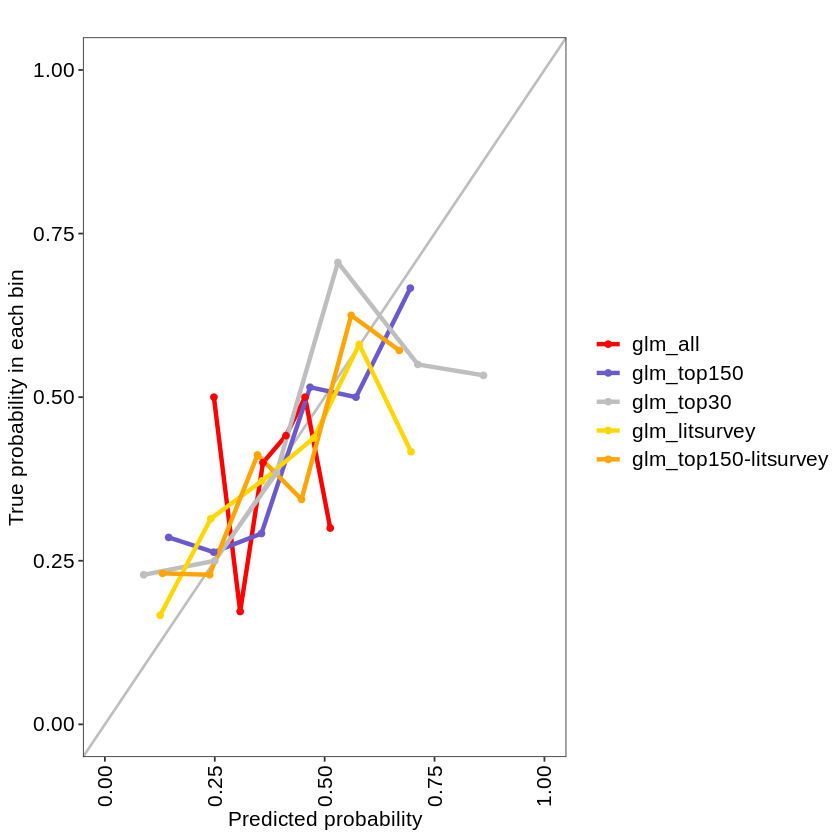

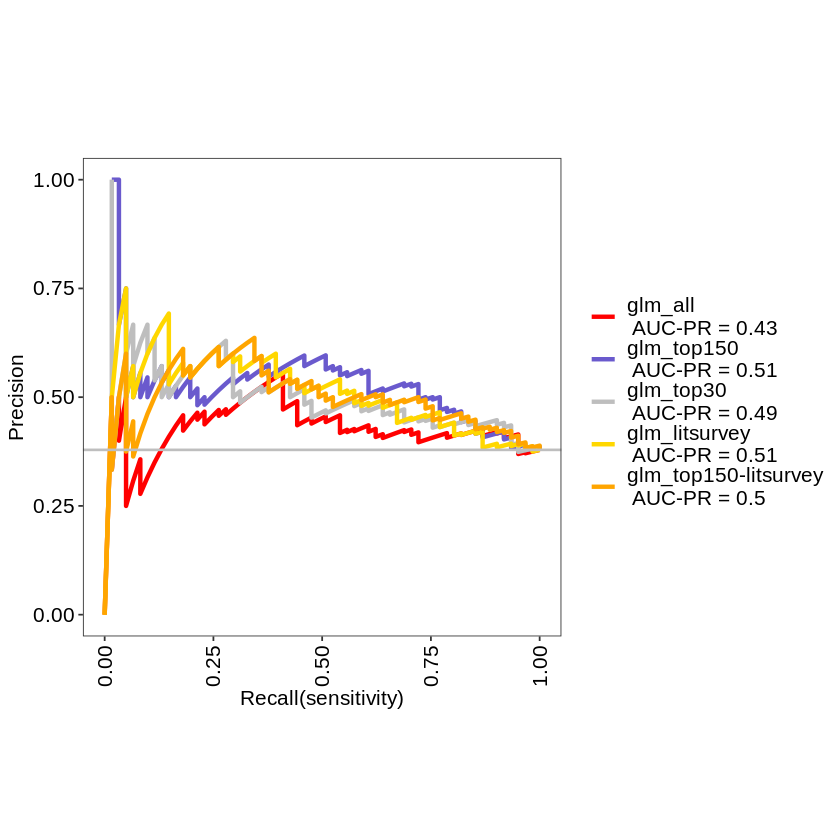

glm_all Optimal Informedness = 0.209836065573771

glm_top150 Optimal Informedness = 0.331311475409836

glm_top30 Optimal Informedness = 0.221639344262295

glm_litsurvey Optimal Informedness = 0.260983606557377

glm_top150-litsurvey Optimal Informedness = 0.281311475409836

glm_all AUC-ROC = 0.58

glm_top150 AUC-ROC = 0.67

glm_top30 AUC-ROC = 0.64

glm_litsurvey AUC-ROC = 0.64

glm_top150-litsurvey AUC-ROC = 0.66



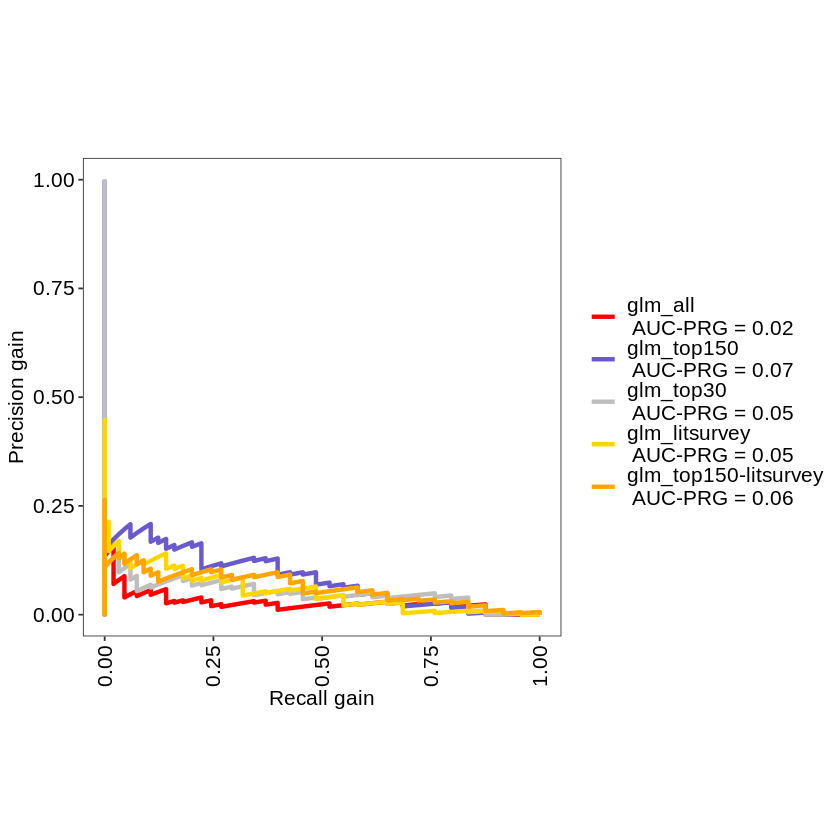

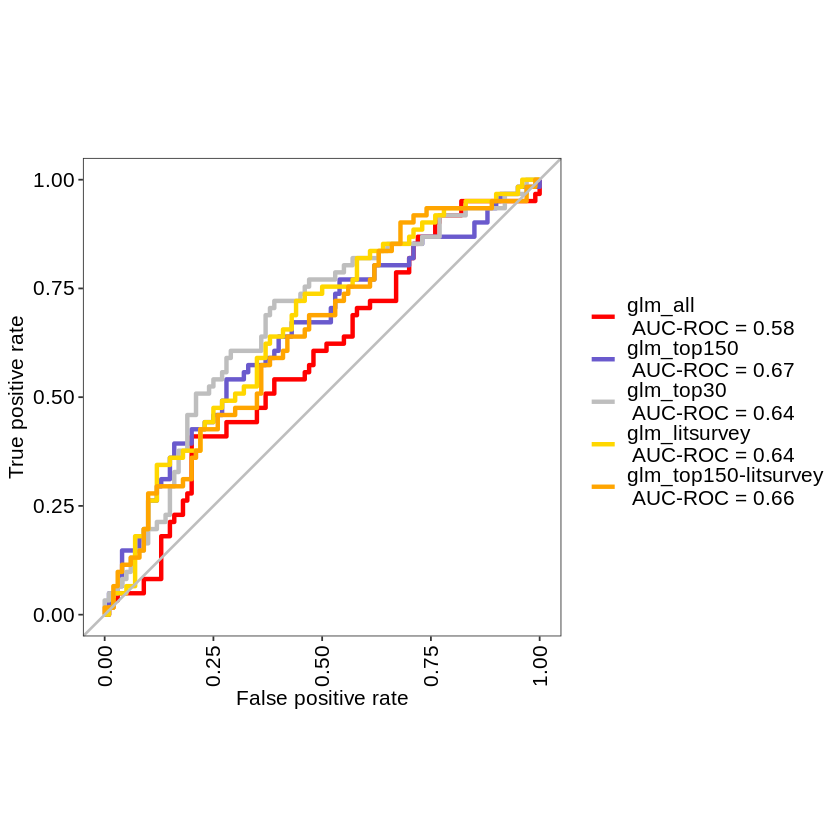

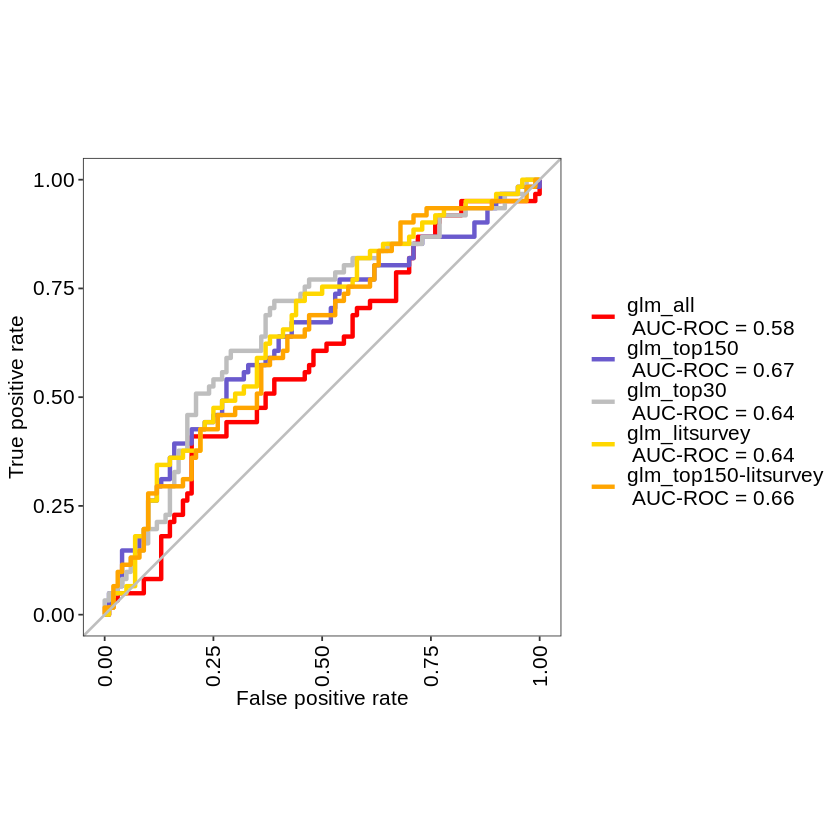

In [62]:
inp_all_glm <- train(Response ~ .,data=mod_inp_mat,
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150_glm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])],
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top30_glm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"])],
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_glm <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150litsurvey_glm <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_glm <- evalm(list(inp_all_glm, inp_top150_glm, inp_top30_glm, inp_litsurvey_glm, inp_top150litsurvey_glm),
             gnames=c('glm_all','glm_top150', 'glm_top30', 'glm_litsurvey', 'glm_top150-litsurvey'))
res_glm$roc

## SVM

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 805

Number of groups: 5

Observations per group: 161

Positive: Y

Negative: N

Group: svm_all

Positive: 61

Negative: 100

Group: svm_top150

Positive: 61

Negative: 100

Group: svm_top30

Positive: 61

Negative: 100

Group: svm_litsurvey

Positive: 61

Negative: 100

Group: svm_top150-litsurvey

Positive: 61

Negative: 100

***Performance Metrics***



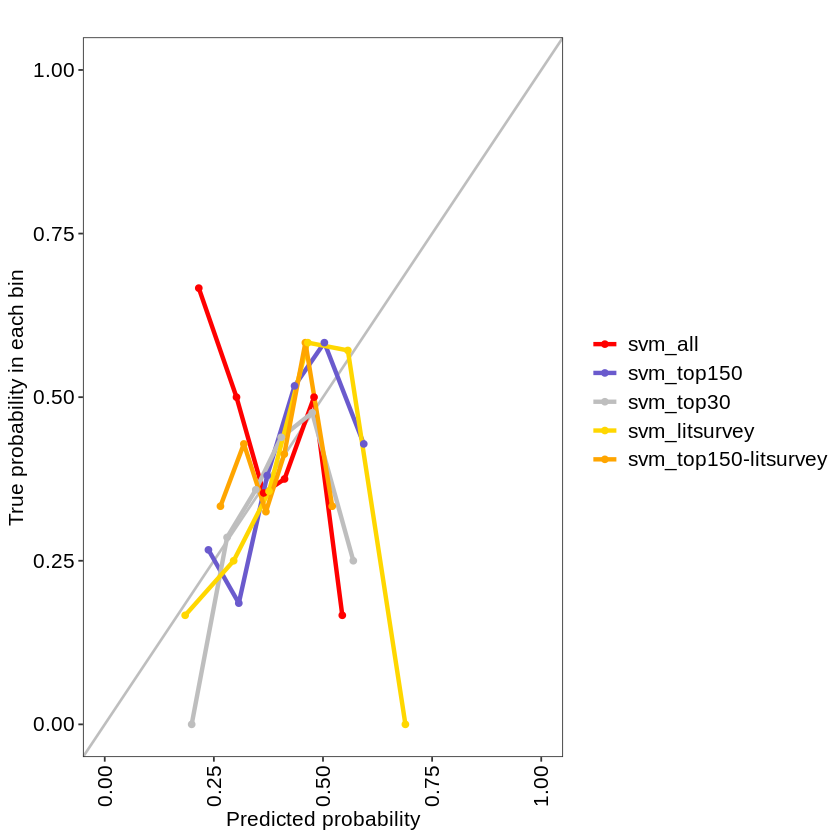

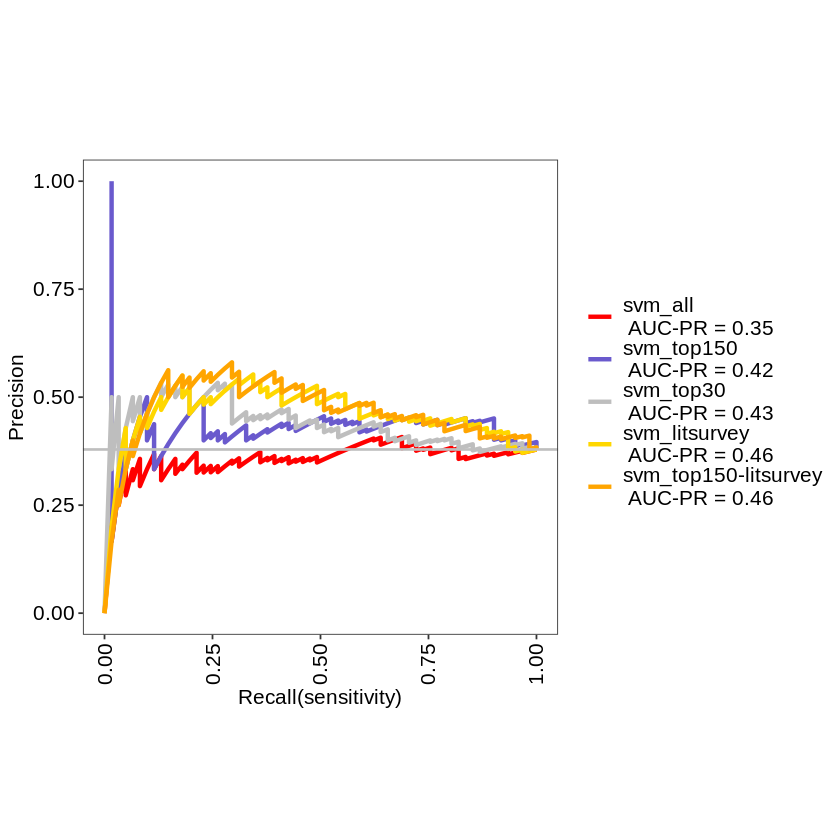

svm_all Optimal Informedness = 0.0785245901639344

svm_top150 Optimal Informedness = 0.231639344262295

svm_top30 Optimal Informedness = 0.142950819672131

svm_litsurvey Optimal Informedness = 0.227377049180328

svm_top150-litsurvey Optimal Informedness = 0.222950819672131

svm_all AUC-ROC = 0.48

svm_top150 AUC-ROC = 0.59

svm_top30 AUC-ROC = 0.57

svm_litsurvey AUC-ROC = 0.63

svm_top150-litsurvey AUC-ROC = 0.63



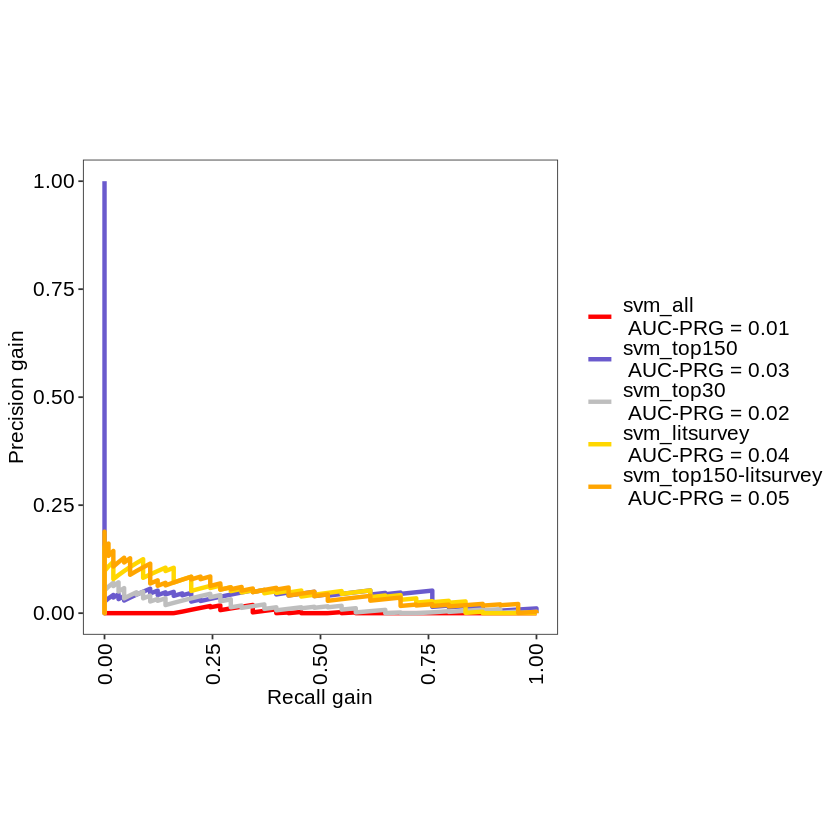

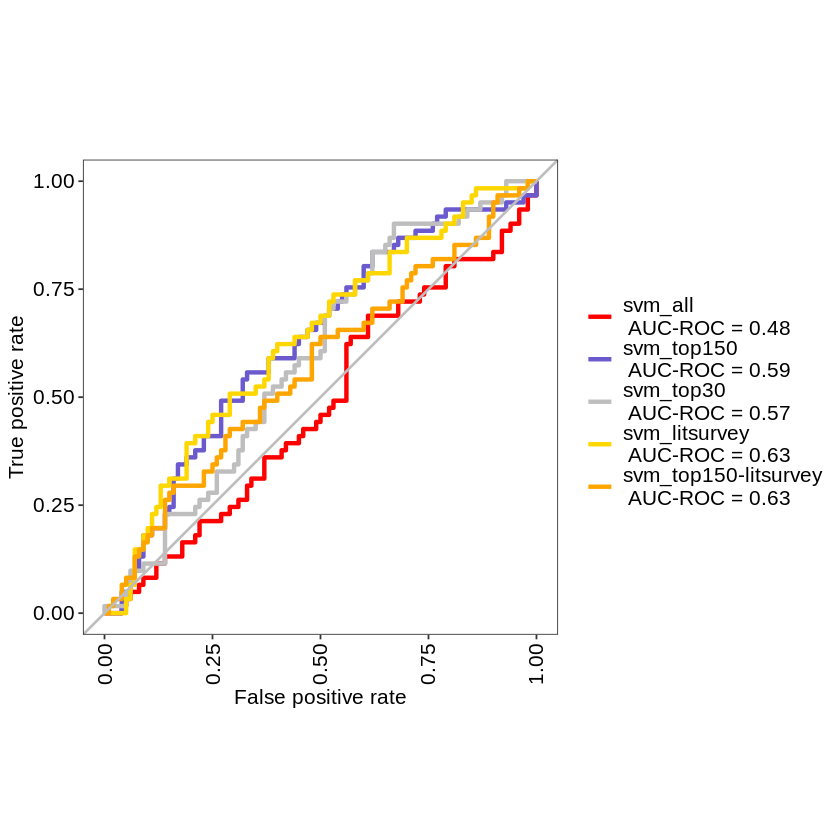

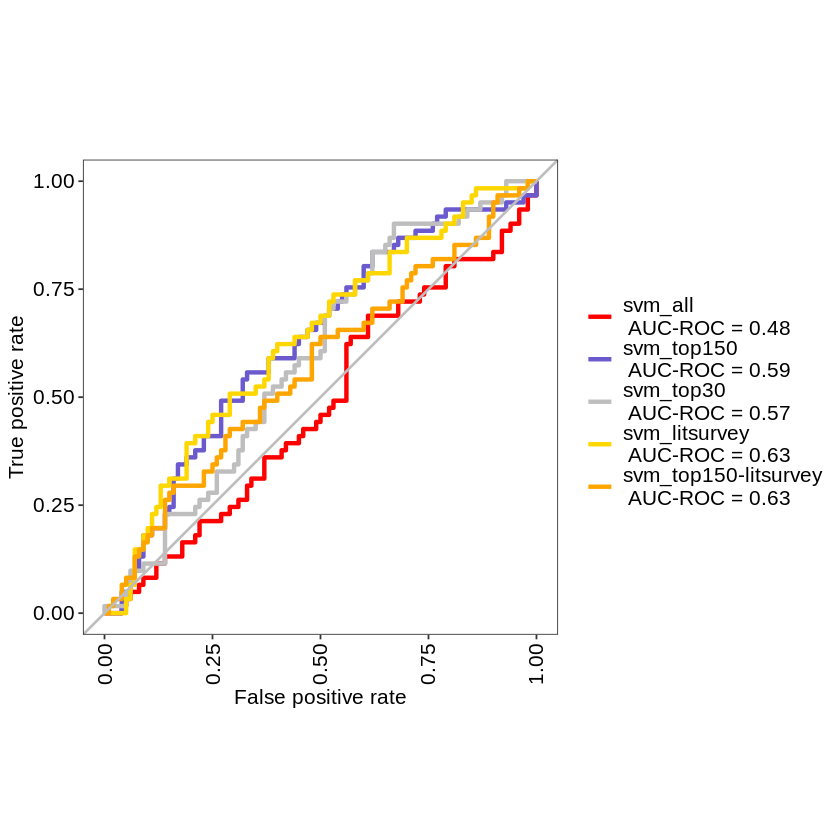

In [63]:
inp_all_svm <- train(Response ~ .,data=mod_inp_mat,
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150_svm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])],
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top30_svm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"])],
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_svm <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150litsurvey_svm <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_svm <- evalm(list(inp_all_svm, inp_top150_svm, inp_top30_svm, inp_litsurvey_svm, inp_top150litsurvey_svm),
             gnames=c('svm_all','svm_top150', 'svm_top30', 'svm_litsurvey', 'svm_top150-litsurvey'))
res_svm$roc

## Neural Network

# weights:  507
initial  value 96.769853 
iter  10 value 81.629824
iter  20 value 71.202174
iter  30 value 67.510794
iter  40 value 63.322307
iter  50 value 61.922695
iter  60 value 61.915288
iter  70 value 61.914437
iter  80 value 60.655859
iter  90 value 60.621509
iter 100 value 60.621372
final  value 60.621372 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 106.712381 
iter  10 value 75.558892
iter  20 value 57.655751
iter  30 value 50.317499
iter  40 value 45.483589
iter  50 value 40.180362
iter  60 value 35.847770
iter  70 value 32.668089
iter  80 value 28.113340
iter  90 value 23.146857
iter 100 value 21.257684
final  value 21.257684 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 107.451074 
iter  10 value 87.560516
iter  20 value 85.826993
iter  30 value 84.726226
iter  40 value 84.088171
iter  50 value 82.941267
iter  60 value 82.931766
iter  70 value 82.900233
iter  80 value 81.508070
iter  90 value 80.384868
iter 100 value 79.304893
final  value 79.304893 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 111.865032 
iter  10 value 85.256905
iter  20 value 71.335945
iter  30 value 68.543803
iter  40 value 67.422209
iter  50 value 65.520993
iter  60 value 64.333768
iter  70 value 63.161844
iter  80 value 61.929799
iter  90 value 61.915109
iter 100 value 61.914261
final  value 61.914261 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 109.004366 
iter  10 value 86.222615
iter  20 value 67.046689
iter  30 value 55.071053
iter  40 value 44.634287
iter  50 value 38.071741
iter  60 value 34.070983
iter  70 value 29.564476
iter  80 value 24.684553
iter  90 value 21.078561
iter 100 value 17.768949
final  value 17.768949 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 100.053194 
iter  10 value 84.626908
iter  20 value 62.470910
iter  30 value 56.283429
iter  40 value 54.874341
iter  50 value 53.438363
iter  60 value 53.412672
iter  70 value 53.409475
iter  80 value 53.407596
iter  90 value 53.404436
iter 100 value 53.400106
final  value 53.400106 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 113.010037 
iter  10 value 77.413920
iter  20 value 70.274345
iter  30 value 69.199841
iter  40 value 69.198869
final  value 69.198669 
converged


Warning message:
“model fit failed for Fold03.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 105.108252 
iter  10 value 86.147360
iter  20 value 72.523710
iter  30 value 57.132363
iter  40 value 44.988124
iter  50 value 37.385818
iter  60 value 34.739643
iter  70 value 24.679865
iter  80 value 23.586246
iter  90 value 20.988529
iter 100 value 18.860003
final  value 18.860003 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 119.772396 
iter  10 value 79.301306
iter  20 value 62.189302
iter  30 value 58.002735
iter  40 value 55.769215
iter  50 value 55.727999
iter  60 value 53.474851
iter  70 value 53.409529
iter  80 value 51.987896
iter  90 value 51.889115
iter 100 value 51.887812
final  value 51.887812 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.076129 
iter  10 value 73.257833
iter  20 value 64.659000
iter  30 value 58.246809
iter  40 value 58.226114
iter  50 value 58.223436
iter  60 value 58.222783
iter  70 value 58.222636
iter  80 value 58.213751
iter  90 value 55.967986
iter 100 value 55.967440
final  value 55.967440 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 106.185616 
iter  10 value 77.109564
iter  20 value 66.396700
iter  30 value 55.539981
iter  40 value 45.815303
iter  50 value 38.072729
iter  60 value 30.717402
iter  70 value 21.177534
iter  80 value 18.742042
iter  90 value 15.599799
iter 100 value 15.402690
final  value 15.402690 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 121.455604 
iter  10 value 75.132028
iter  20 value 71.237023
iter  30 value 70.535976
iter  40 value 70.252595
iter  50 value 69.256449
iter  60 value 68.015057
iter  70 value 62.129129
iter  80 value 57.709540
iter  90 value 57.695313
iter 100 value 55.516313
final  value 55.516313 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.114982 
iter  10 value 78.829318
iter  20 value 73.909059
iter  30 value 73.893839
iter  40 value 71.335555
iter  50 value 70.768415
final  value 70.768147 
converged


Warning message:
“model fit failed for Fold05.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 134.354424 
iter  10 value 81.097617
iter  20 value 59.740030
iter  30 value 46.936485
iter  40 value 41.710308
iter  50 value 35.008767
iter  60 value 28.149269
iter  70 value 26.948164
iter  80 value 22.496132
iter  90 value 19.263131
iter 100 value 19.058501
final  value 19.058501 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 107.293643 
iter  10 value 78.086414
iter  20 value 72.996665
iter  30 value 71.335680
iter  40 value 70.316510
iter  50 value 69.579339
iter  60 value 69.247790
iter  70 value 69.231056
iter  80 value 68.133519
iter  90 value 68.127598
iter 100 value 67.016605
final  value 67.016605 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.750270 
iter  10 value 82.213913
iter  20 value 56.698229
iter  30 value 48.306551
iter  40 value 45.325941
iter  50 value 42.053982
iter  60 value 42.046778
iter  70 value 42.045547
iter  80 value 42.045060
iter  90 value 42.044977
iter 100 value 42.044868
final  value 42.044868 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 108.457054 
iter  10 value 86.104426
iter  20 value 65.853482
iter  30 value 54.663838
iter  40 value 41.756862
iter  50 value 37.026764
iter  60 value 30.150126
iter  70 value 28.924876
iter  80 value 24.825647
iter  90 value 24.739991
iter 100 value 24.736249
final  value 24.736249 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 105.285491 
iter  10 value 80.197716
iter  20 value 64.452037
iter  30 value 64.431153
iter  40 value 63.226710
iter  50 value 62.021659
iter  60 value 58.854147
iter  70 value 57.925108
iter  80 value 56.470691
iter  90 value 56.465082
iter 100 value 56.455134
final  value 56.455134 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.908935 
iter  10 value 70.287898
iter  20 value 59.820905
iter  30 value 59.474557
iter  40 value 58.499211
iter  50 value 58.497384
iter  60 value 57.125126
iter  70 value 57.121468
iter  80 value 55.696027
iter  90 value 55.695717
iter 100 value 52.636753
final  value 52.636753 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.665197 
iter  10 value 87.482906
iter  20 value 64.788467
iter  30 value 55.983208
iter  40 value 50.150208
iter  50 value 45.177191
iter  60 value 37.780039
iter  70 value 32.193452
iter  80 value 27.092513
iter  90 value 22.639885
iter 100 value 19.255022
final  value 19.255022 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.179921 
iter  10 value 76.220954
iter  20 value 61.464616
iter  30 value 60.233961
iter  40 value 60.226346
iter  50 value 60.212365
iter  60 value 56.005088
iter  70 value 54.037690
iter  80 value 54.027508
iter  90 value 54.017010
iter 100 value 54.003457
final  value 54.003457 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.857079 
iter  10 value 93.627877
iter  20 value 83.794585
iter  30 value 81.755632
iter  40 value 81.697969
iter  50 value 80.978616
iter  60 value 80.336060
iter  70 value 80.194879
iter  80 value 80.194507
iter  90 value 79.404771
iter 100 value 78.594157
final  value 78.594157 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 113.015370 
iter  10 value 85.316471
iter  20 value 71.351795
iter  30 value 62.367298
iter  40 value 52.486592
iter  50 value 44.415429
iter  60 value 39.487614
iter  70 value 30.729652
iter  80 value 27.599498
iter  90 value 27.179277
iter 100 value 24.846552
final  value 24.846552 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 107.615537 
iter  10 value 70.366268
iter  20 value 58.030807
iter  30 value 53.472533
iter  40 value 53.456602
iter  50 value 53.449270
iter  60 value 53.437772
iter  70 value 51.924289
iter  80 value 51.905498
iter  90 value 51.900939
iter 100 value 50.313684
final  value 50.313684 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 103.208168 
iter  10 value 73.464316
iter  20 value 54.029647
iter  30 value 51.424352
iter  40 value 51.162121
iter  50 value 51.160884
iter  60 value 51.160744
final  value 51.160450 
converged


Warning message:
“model fit failed for Fold09.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 117.300327 
iter  10 value 82.928067
iter  20 value 62.860507
iter  30 value 56.880513
iter  40 value 48.895307
iter  50 value 45.368811
iter  60 value 38.274767
iter  70 value 36.550271
iter  80 value 32.742758
iter  90 value 32.610736
iter 100 value 30.445342
final  value 30.445342 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 121.124554 
iter  10 value 73.459787
iter  20 value 59.371038
iter  30 value 55.783824
iter  40 value 54.246061
iter  50 value 52.692942
iter  60 value 52.687427
iter  70 value 52.683853
iter  80 value 51.051608
iter  90 value 51.043892
iter 100 value 51.040825
final  value 51.040825 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.644518 
iter  10 value 72.066691
iter  20 value 53.801265
iter  30 value 52.504348
iter  40 value 52.499552
iter  50 value 51.160319
iter  60 value 51.159413
iter  70 value 49.943609
iter  80 value 49.775846
iter  90 value 46.882893
iter 100 value 46.861907
final  value 46.861907 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep1: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep1: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 115.442357 
iter  10 value 81.747001
iter  20 value 68.681603
iter  30 value 56.732502
iter  40 value 48.144481
iter  50 value 37.092828
iter  60 value 30.373875
iter  70 value 19.808515
iter  80 value 16.114214
iter  90 value 15.392629
iter 100 value 15.375351
final  value 15.375351 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep1: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep1: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 107.370000 
iter  10 value 78.121929
iter  20 value 69.247904
iter  30 value 67.453250
iter  40 value 67.394797
iter  50 value 66.248266
iter  60 value 65.142998
iter  70 value 61.125146
iter  80 value 61.121950
iter  90 value 61.115440
iter 100 value 57.657467
final  value 57.657467 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep1: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep1: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 108.046645 
iter  10 value 93.618713
iter  20 value 89.585725
iter  30 value 86.554450
iter  40 value 83.731848
iter  50 value 77.538096
iter  60 value 70.428137
iter  70 value 70.366360
iter  80 value 68.706690
iter  90 value 67.547083
iter 100 value 67.543174
final  value 67.543174 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.658823 
iter  10 value 80.799134
iter  20 value 66.216405
iter  30 value 48.054084
iter  40 value 38.157367
iter  50 value 34.299768
iter  60 value 30.897351
iter  70 value 20.957143
iter  80 value 19.823151
iter  90 value 19.172139
iter 100 value 19.120916
final  value 19.120916 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 110.632017 
iter  10 value 75.399103
iter  20 value 64.055705
iter  30 value 62.375642
iter  40 value 62.368603
iter  50 value 61.150041
iter  60 value 61.133079
iter  70 value 59.862189
iter  80 value 59.858059
iter  90 value 59.852972
iter 100 value 57.625507
final  value 57.625507 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 101.076149 
iter  10 value 92.447154
iter  20 value 76.895196
iter  30 value 71.613683
iter  40 value 69.834020
iter  50 value 69.784227
iter  60 value 69.777648
iter  70 value 68.768217
iter  80 value 68.767566
iter  90 value 68.767215
iter 100 value 66.908969
final  value 66.908969 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 111.047481 
iter  10 value 89.918874
iter  20 value 74.863288
iter  30 value 63.080475
iter  40 value 54.322409
iter  50 value 46.403052
iter  60 value 42.142419
iter  70 value 36.678242
iter  80 value 30.175480
iter  90 value 27.666531
iter 100 value 24.818042
final  value 24.818042 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 100.276613 
iter  10 value 80.447320
iter  20 value 63.263924
iter  30 value 63.223487
iter  40 value 61.967899
iter  50 value 61.959552
iter  60 value 61.950995
iter  70 value 61.945198
iter  80 value 61.941269
iter  90 value 60.701140
iter 100 value 60.645367
final  value 60.645367 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 105.747150 
iter  10 value 63.483963
iter  20 value 54.240858
iter  30 value 50.318516
iter  40 value 50.274566
iter  50 value 50.273964
iter  60 value 50.273307
iter  70 value 50.273231
final  value 50.273144 
converged


Warning message:
“model fit failed for Fold03.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 140.719646 
iter  10 value 86.073381
iter  20 value 70.005055
iter  30 value 58.167676
iter  40 value 43.769925
iter  50 value 34.342919
iter  60 value 31.825547
iter  70 value 24.605407
iter  80 value 19.659353
iter  90 value 17.698868
iter 100 value 13.920094
final  value 13.920094 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.111580 
iter  10 value 79.779055
iter  20 value 53.496970
iter  30 value 37.225579
iter  40 value 34.300997
iter  50 value 33.200173
iter  60 value 33.191863
iter  70 value 33.189348
iter  80 value 33.186690
iter  90 value 33.183318
iter 100 value 33.180936
final  value 33.180936 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.318039 
iter  10 value 80.977402
iter  20 value 65.682484
iter  30 value 60.627812
iter  40 value 59.066325
iter  50 value 57.208283
iter  60 value 54.856406
iter  70 value 53.586649
iter  80 value 53.384075
iter  90 value 51.886363
iter 100 value 51.862008
final  value 51.862008 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 107.215706 
iter  10 value 84.186993
iter  20 value 64.572262
iter  30 value 57.138987
iter  40 value 53.663257
iter  50 value 45.072539
iter  60 value 38.670255
iter  70 value 29.146407
iter  80 value 25.825870
iter  90 value 22.206218
iter 100 value 19.169562
final  value 19.169562 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.861187 
iter  10 value 77.839519
iter  20 value 68.973092
iter  30 value 64.770681
iter  40 value 62.624008
iter  50 value 62.612673
iter  60 value 62.599171
iter  70 value 61.451940
iter  80 value 61.417779
iter  90 value 60.330487
iter 100 value 57.884134
final  value 57.884134 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.745892 
iter  10 value 78.687213
iter  20 value 72.606996
iter  30 value 72.525813
iter  40 value 72.523581
iter  50 value 72.523348
final  value 72.523301 
converged


Warning message:
“model fit failed for Fold05.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 125.323350 
iter  10 value 82.492016
iter  20 value 70.823658
iter  30 value 58.081046
iter  40 value 52.075472
iter  50 value 41.176350
iter  60 value 32.051162
iter  70 value 27.607465
iter  80 value 23.992523
iter  90 value 20.113221
iter 100 value 16.395056
final  value 16.395056 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 94.832485 
iter  10 value 76.427085
iter  20 value 66.497420
iter  30 value 64.822912
iter  40 value 62.343966
iter  50 value 60.175522
iter  60 value 57.642826
iter  70 value 57.619183
iter  80 value 57.513579
iter  90 value 56.269142
iter 100 value 56.266093
final  value 56.266093 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 106.426336 
iter  10 value 80.063383
iter  20 value 73.047908
iter  30 value 66.602095
iter  40 value 61.364388
iter  50 value 60.148788
iter  60 value 60.143694
iter  70 value 60.142094
iter  80 value 57.588070
iter  90 value 56.237572
iter 100 value 56.237056
final  value 56.237056 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 116.555897 
iter  10 value 80.641775
iter  20 value 64.489010
iter  30 value 55.896251
iter  40 value 48.638693
iter  50 value 46.102383
iter  60 value 42.874591
iter  70 value 33.028294
iter  80 value 29.895803
iter  90 value 27.507375
iter 100 value 25.020122
final  value 25.020122 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.342768 
iter  10 value 69.391841
iter  20 value 59.352919
iter  30 value 59.333639
iter  40 value 59.318219
iter  50 value 52.015801
iter  60 value 51.897720
iter  70 value 51.888684
iter  80 value 50.308463
iter  90 value 50.305618
iter 100 value 50.300466
final  value 50.300466 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.978110 
iter  10 value 77.718433
iter  20 value 66.194361
iter  30 value 59.928747
iter  40 value 58.336431
iter  50 value 56.884082
iter  60 value 55.464220
iter  70 value 55.455933
iter  80 value 55.454497
iter  90 value 55.454176
iter 100 value 55.453740
final  value 55.453740 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 108.612595 
iter  10 value 71.822215
iter  20 value 50.440599
iter  30 value 41.977598
iter  40 value 33.769713
iter  50 value 29.003030
iter  60 value 22.658257
iter  70 value 19.475729
iter  80 value 19.227973
iter  90 value 18.783810
iter 100 value 16.285273
final  value 16.285273 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 106.677943 
iter  10 value 78.267715
iter  20 value 65.570077
iter  30 value 65.496945
iter  40 value 63.627439
iter  50 value 62.385515
iter  60 value 62.376894
iter  70 value 56.905930
iter  80 value 56.901291
iter  90 value 54.630069
iter 100 value 54.615272
final  value 54.615272 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 97.954530 
iter  10 value 82.074580
iter  20 value 76.943374
iter  30 value 75.578620
iter  40 value 74.333749
iter  50 value 71.507831
iter  60 value 69.827316
iter  70 value 69.820316
iter  80 value 68.098053
iter  90 value 66.282749
iter 100 value 65.253976
final  value 65.253976 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 115.177620 
iter  10 value 81.228353
iter  20 value 55.399708
iter  30 value 44.746182
iter  40 value 34.849089
iter  50 value 28.090504
iter  60 value 22.491223
iter  70 value 20.290817
iter  80 value 18.597720
iter  90 value 15.429243
iter 100 value 15.267953
final  value 15.267953 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 126.285197 
iter  10 value 77.733316
iter  20 value 67.505752
iter  30 value 64.614874
iter  40 value 64.387884
iter  50 value 64.321741
iter  60 value 63.181127
iter  70 value 60.136220
iter  80 value 57.672264
iter  90 value 56.261055
iter 100 value 56.259088
final  value 56.259088 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.269435 
iter  10 value 81.061054
iter  20 value 72.799421
iter  30 value 64.940041
iter  40 value 63.899639
iter  50 value 58.508388
iter  60 value 57.125120
iter  70 value 49.504164
iter  80 value 48.625224
iter  90 value 48.612390
iter 100 value 48.611577
final  value 48.611577 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 109.880914 
iter  10 value 84.490287
iter  20 value 62.715754
iter  30 value 46.764986
iter  40 value 42.138530
iter  50 value 34.847520
iter  60 value 29.765090
iter  70 value 25.915410
iter  80 value 21.361773
iter  90 value 20.840825
iter 100 value 20.757146
final  value 20.757146 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 101.273440 
iter  10 value 81.060644
iter  20 value 71.688218
iter  30 value 70.695375
iter  40 value 70.677801
iter  50 value 69.683874
iter  60 value 65.592413
iter  70 value 65.581011
iter  80 value 64.334163
iter  90 value 59.883582
iter 100 value 59.874760
final  value 59.874760 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.038541 
iter  10 value 77.559493
iter  20 value 67.583505
iter  30 value 67.545318
iter  40 value 66.405150
iter  50 value 63.907502
iter  60 value 60.625960
iter  70 value 60.621872
iter  80 value 60.621637
iter  90 value 59.331480
iter 100 value 57.151818
final  value 57.151818 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep2: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep2: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 119.774052 
iter  10 value 89.003452
iter  20 value 67.253362
iter  30 value 58.616440
iter  40 value 49.353610
iter  50 value 45.152826
iter  60 value 32.667903
iter  70 value 22.873502
iter  80 value 21.105697
iter  90 value 20.740525
iter 100 value 20.669583
final  value 20.669583 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep2: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep2: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.923337 
iter  10 value 91.531863
iter  20 value 80.094388
iter  30 value 73.974196
iter  40 value 70.990314
iter  50 value 70.941586
iter  60 value 70.937432
iter  70 value 70.931227
iter  80 value 70.925664
iter  90 value 68.735982
iter 100 value 66.899087
final  value 66.899087 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep2: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep2: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 113.143723 
iter  10 value 85.307361
iter  20 value 70.678282
iter  30 value 68.571184
iter  40 value 66.294823
iter  50 value 66.282067
iter  60 value 62.439367
iter  70 value 61.092212
iter  80 value 59.820217
iter  90 value 59.817890
final  value 59.817730 
converged


Warning message:
“model fit failed for Fold01.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 103.035575 
iter  10 value 86.345947
iter  20 value 72.179186
iter  30 value 61.071006
iter  40 value 52.231670
iter  50 value 45.885042
iter  60 value 41.040187
iter  70 value 35.771524
iter  80 value 32.518456
iter  90 value 25.425833
iter 100 value 21.626341
final  value 21.626341 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 109.190825 
iter  10 value 83.144701
iter  20 value 79.431173
iter  30 value 77.921776
iter  40 value 77.232143
iter  50 value 74.858471
iter  60 value 73.276532
iter  70 value 73.270675
iter  80 value 72.383166
iter  90 value 72.300731
iter 100 value 68.541625
final  value 68.541625 
stopped after 100 iterations


Warning message:
“model fit failed for Fold01.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold01.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.368140 
iter  10 value 84.159251
iter  20 value 79.562124
iter  30 value 79.542340
iter  40 value 79.541191
iter  50 value 79.153740
iter  60 value 76.883674
iter  70 value 75.489566
iter  80 value 75.488298
iter  90 value 74.042111
iter 100 value 74.030826
final  value 74.030826 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 110.317365 
iter  10 value 89.712015
iter  20 value 70.620554
iter  30 value 61.423832
iter  40 value 54.240938
iter  50 value 46.140751
iter  60 value 38.051884
iter  70 value 30.473706
iter  80 value 23.667532
iter  90 value 18.594331
iter 100 value 18.201778
final  value 18.201778 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.117709 
iter  10 value 91.033477
iter  20 value 71.982716
iter  30 value 68.580590
iter  40 value 68.531837
iter  50 value 67.440729
iter  60 value 67.437406
iter  70 value 67.433983
iter  80 value 67.429144
iter  90 value 66.301985
iter 100 value 63.192089
final  value 63.192089 
stopped after 100 iterations


Warning message:
“model fit failed for Fold02.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold02.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.421234 
iter  10 value 70.816144
iter  20 value 66.396347
iter  30 value 64.481903
iter  40 value 64.359650
iter  50 value 64.358545
iter  60 value 64.358341
iter  70 value 62.342970
iter  80 value 62.318342
final  value 62.318130 
converged


Warning message:
“model fit failed for Fold03.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 124.299568 
iter  10 value 81.438221
iter  20 value 68.657063
iter  30 value 51.774496
iter  40 value 39.745899
iter  50 value 33.755160
iter  60 value 30.859745
iter  70 value 25.389448
iter  80 value 22.174012
iter  90 value 18.834115
iter 100 value 18.251463
final  value 18.251463 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.501956 
iter  10 value 75.909181
iter  20 value 69.291791
iter  30 value 68.168496
iter  40 value 62.849626
iter  50 value 61.955343
iter  60 value 61.949993
iter  70 value 61.946698
iter  80 value 61.941121
iter  90 value 61.939052
iter 100 value 59.841768
final  value 59.841768 
stopped after 100 iterations


Warning message:
“model fit failed for Fold03.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold03.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 98.794901 
iter  10 value 75.956687
iter  20 value 65.621852
iter  30 value 63.703096
iter  40 value 62.513900
iter  50 value 58.890983
iter  60 value 58.887659
iter  70 value 58.886683
iter  80 value 58.879991
iter  90 value 56.526206
iter 100 value 56.521892
final  value 56.521892 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 114.518258 
iter  10 value 88.080102
iter  20 value 65.930157
iter  30 value 47.087607
iter  40 value 36.051438
iter  50 value 28.109888
iter  60 value 25.644804
iter  70 value 18.375376
iter  80 value 16.168109
iter  90 value 15.637210
iter 100 value 15.576198
final  value 15.576198 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.365987 
iter  10 value 76.689487
iter  20 value 66.050385
iter  30 value 64.710497
iter  40 value 63.651095
iter  50 value 63.547250
iter  60 value 63.543737
iter  70 value 62.474009
iter  80 value 61.137318
iter  90 value 59.873550
iter 100 value 59.853418
final  value 59.853418 
stopped after 100 iterations


Warning message:
“model fit failed for Fold04.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold04.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 100.839684 
iter  10 value 80.777868
iter  20 value 66.741998
iter  30 value 58.225347
iter  40 value 54.208053
iter  50 value 54.205578
iter  60 value 54.205212
iter  70 value 54.204923
final  value 54.204905 
converged


Warning message:
“model fit failed for Fold05.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 108.710818 
iter  10 value 87.410490
iter  20 value 58.036259
iter  30 value 43.676878
iter  40 value 40.511450
iter  50 value 33.579393
iter  60 value 30.295498
iter  70 value 19.820382
iter  80 value 16.829071
iter  90 value 16.133219
iter 100 value 15.980629
final  value 15.980629 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 104.426349 
iter  10 value 86.927869
iter  20 value 72.505013
iter  30 value 70.350569
iter  40 value 67.914489
iter  50 value 64.465034
iter  60 value 63.192040
iter  70 value 63.187107
iter  80 value 60.605485
iter  90 value 55.212920
iter 100 value 53.846647
final  value 53.846647 
stopped after 100 iterations


Warning message:
“model fit failed for Fold05.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold05.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 102.453767 
iter  10 value 79.417122
iter  20 value 74.581904
iter  30 value 72.942206
iter  40 value 72.929690
iter  50 value 72.928424
iter  60 value 72.927598
iter  70 value 71.291109
iter  80 value 71.290053
iter  90 value 71.289877
iter  90 value 71.289876
final  value 71.289876 
converged


Warning message:
“model fit failed for Fold06.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 108.454519 
iter  10 value 85.176810
iter  20 value 67.013456
iter  30 value 58.652581
iter  40 value 50.595301
iter  50 value 41.924527
iter  60 value 31.245701
iter  70 value 24.773611
iter  80 value 20.326927
iter  90 value 19.316773
iter 100 value 16.331865
final  value 16.331865 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.901449 
iter  10 value 74.613341
iter  20 value 70.684602
iter  30 value 66.921936
iter  40 value 66.896304
iter  50 value 64.829186
iter  60 value 64.824715
iter  70 value 64.819207
iter  80 value 62.587384
iter  90 value 62.583261
iter 100 value 62.579807
final  value 62.579807 
stopped after 100 iterations


Warning message:
“model fit failed for Fold06.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold06.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 115.811346 
iter  10 value 79.376517
iter  20 value 61.543129
iter  30 value 37.557025
iter  40 value 29.295800
iter  50 value 26.488270
iter  60 value 26.467792
iter  70 value 26.465695
iter  80 value 26.465266
iter  90 value 26.464762
iter 100 value 26.464632
final  value 26.464632 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 105.981183 
iter  10 value 89.453291
iter  20 value 69.495729
iter  30 value 47.307234
iter  40 value 35.762466
iter  50 value 28.246724
iter  60 value 22.470222
iter  70 value 19.364233
iter  80 value 16.280497
iter  90 value 15.628539
iter 100 value 15.557861
final  value 15.557861 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.523098 
iter  10 value 74.778857
iter  20 value 60.861842
iter  30 value 60.832876
iter  40 value 60.820892
iter  50 value 55.015103
iter  60 value 53.502804
iter  70 value 47.591666
iter  80 value 47.577779
iter  90 value 47.574526
iter 100 value 47.571508
final  value 47.571508 
stopped after 100 iterations


Warning message:
“model fit failed for Fold07.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold07.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 118.141014 
iter  10 value 83.716438
iter  20 value 76.343252
iter  30 value 74.477606
iter  40 value 73.559372
iter  50 value 69.866040
iter  60 value 69.822336
iter  70 value 69.818856
iter  80 value 68.100703
iter  90 value 68.096378
iter 100 value 68.096250
final  value 68.096250 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 105.253929 
iter  10 value 86.402115
iter  20 value 57.978038
iter  30 value 46.975896
iter  40 value 40.638641
iter  50 value 36.372775
iter  60 value 33.112534
iter  70 value 22.170267
iter  80 value 19.798569
iter  90 value 18.769706
iter 100 value 15.717095
final  value 15.717095 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 111.481561 
iter  10 value 85.220017
iter  20 value 74.170169
iter  30 value 69.597863
iter  40 value 69.588700
iter  50 value 69.585747
iter  60 value 67.443724
iter  70 value 65.529466
iter  80 value 62.012467
iter  90 value 61.946416
iter 100 value 61.943552
final  value 61.943552 
stopped after 100 iterations


Warning message:
“model fit failed for Fold08.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold08.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.984092 
iter  10 value 83.387382
iter  20 value 66.458905
iter  30 value 56.781508
iter  40 value 47.512151
iter  50 value 44.512695
iter  60 value 44.285767
iter  70 value 39.677981
iter  80 value 39.595997
iter  90 value 37.652400
iter 100 value 37.587646
final  value 37.587646 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 110.378453 
iter  10 value 71.726937
iter  20 value 58.821439
iter  30 value 45.339288
iter  40 value 38.357131
iter  50 value 28.016861
iter  60 value 21.119438
iter  70 value 18.884559
iter  80 value 15.915814
iter  90 value 15.500354
iter 100 value 15.456437
final  value 15.456437 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.570623 
iter  10 value 75.326982
iter  20 value 62.686328
iter  30 value 60.318558
iter  40 value 54.204435
iter  50 value 49.906109
iter  60 value 49.813817
iter  70 value 46.948475
iter  80 value 46.893935
iter  90 value 46.892453
iter 100 value 46.889339
final  value 46.889339 
stopped after 100 iterations


Warning message:
“model fit failed for Fold09.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold09.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 96.853128 
iter  10 value 84.069258
iter  20 value 73.721806
iter  30 value 62.850433
iter  40 value 59.312031
iter  50 value 57.138668
iter  60 value 57.127214
iter  70 value 57.125301
iter  80 value 56.995170
iter  90 value 54.839235
iter 100 value 53.530818
final  value 53.530818 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep3: size=3, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep3: size=5, decay=0e+00 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 137.559835 
iter  10 value 88.619226
iter  20 value 73.764042
iter  30 value 61.685879
iter  40 value 52.163569
iter  50 value 36.111297
iter  60 value 24.629089
iter  70 value 19.357058
iter  80 value 15.871697
iter  90 value 15.334529
iter 100 value 13.732525
final  value 13.732525 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep3: size=3, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep3: size=5, decay=1e-01 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”


# weights:  507
initial  value 99.437810 
iter  10 value 79.449834
iter  20 value 61.269891
iter  30 value 58.827867
iter  40 value 58.530728
iter  50 value 58.527185
iter  60 value 58.523031
iter  70 value 58.519272
iter  80 value 57.454376
iter  90 value 57.150540
iter 100 value 54.135209
final  value 54.135209 
stopped after 100 iterations


Warning message:
“model fit failed for Fold10.Rep3: size=3, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1519) weights
”
Warning message:
“model fit failed for Fold10.Rep3: size=5, decay=1e-04 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (2531) weights
”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”
Warning message in train.default(x, y, weights = w, ...):
“missing values found in aggregated results”


# weights:  507
initial  value 113.969290 
iter  10 value 100.998595
iter  20 value 84.388398
iter  30 value 84.354022
iter  40 value 81.780835
iter  50 value 78.571090
iter  60 value 76.573701
iter  70 value 75.503714
iter  80 value 75.464051
iter  90 value 75.458853
iter 100 value 72.461636
final  value 72.461636 
stopped after 100 iterations
# weights:  147
initial  value 133.928526 
iter  10 value 68.378320
iter  20 value 61.440290
iter  30 value 61.077574
iter  40 value 57.722074
iter  50 value 54.038383
iter  60 value 51.671908
iter  70 value 48.458945
iter  80 value 46.928565
iter  90 value 43.716348
iter 100 value 43.672487
final  value 43.672487 
stopped after 100 iterations
# weights:  439
initial  value 112.457139 
iter  10 value 45.469545
iter  20 value 30.597149
iter  30 value 27.848627
iter  40 value 25.537007
iter  50 value 24.794153
iter  60 value 24.523619
iter  70 value 24.489207
iter  80 value 24.480023
iter  90 value 24.418274
iter 100 value 24.413991
final  value 2

initial  value 96.991014 
iter  10 value 67.076758
iter  20 value 49.375877
iter  30 value 47.004848
iter  40 value 46.925880
iter  50 value 46.921680
iter  60 value 46.918686
iter  70 value 46.917242
iter  80 value 46.915655
iter  90 value 46.914474
iter 100 value 46.913929
final  value 46.913929 
stopped after 100 iterations
# weights:  439
initial  value 134.320979 
iter  10 value 48.491654
iter  20 value 29.248661
iter  30 value 21.025919
iter  40 value 20.390174
iter  50 value 20.064276
iter  60 value 20.020204
iter  70 value 19.872752
iter  80 value 19.746260
iter  90 value 19.560664
iter 100 value 19.544143
final  value 19.544143 
stopped after 100 iterations
# weights:  731
initial  value 99.211852 
iter  10 value 34.799858
iter  20 value 16.087267
iter  30 value 11.330047
iter  40 value 11.090370
iter  50 value 11.050501
iter  60 value 11.021983
iter  70 value 10.893545
iter  80 value 10.872067
iter  90 value 8.456029
iter 100 value 7.797754
final  value 7.797754 
stopped afte

initial  value 109.139050 
iter  10 value 72.983698
iter  20 value 47.710229
iter  30 value 32.921946
iter  40 value 27.597512
iter  50 value 23.113741
iter  60 value 22.652683
iter  70 value 22.557384
iter  80 value 22.545572
iter  90 value 22.515413
iter 100 value 21.849750
final  value 21.849750 
stopped after 100 iterations
# weights:  731
initial  value 109.053109 
iter  10 value 61.756546
iter  20 value 32.445485
iter  30 value 22.210374
iter  40 value 18.042478
iter  50 value 15.410842
iter  60 value 14.726594
iter  70 value 14.607783
iter  80 value 14.587841
iter  90 value 14.561673
iter 100 value 14.559359
final  value 14.559359 
stopped after 100 iterations
# weights:  147
initial  value 102.731046 
iter  10 value 79.400247
iter  20 value 57.686288
iter  30 value 57.215648
iter  40 value 57.197375
iter  50 value 57.192170
iter  60 value 57.186511
iter  70 value 57.011206
iter  80 value 54.923644
iter  90 value 54.907292
iter 100 value 54.904044
final  value 54.904044 
stopped

initial  value 160.476166 
iter  10 value 63.021606
iter  20 value 30.767158
iter  30 value 22.569828
iter  40 value 17.818409
iter  50 value 17.415626
iter  60 value 17.408631
iter  70 value 17.407043
iter  80 value 17.407013
final  value 17.407012 
converged
# weights:  147
initial  value 111.602065 
iter  10 value 81.058069
iter  20 value 54.642510
iter  30 value 44.013182
iter  40 value 38.021179
iter  50 value 33.358031
iter  60 value 30.023130
iter  70 value 28.075273
iter  80 value 24.690132
iter  90 value 24.432120
iter 100 value 24.419238
final  value 24.419238 
stopped after 100 iterations
# weights:  439
initial  value 126.514976 
iter  10 value 62.667192
iter  20 value 39.727919
iter  30 value 25.305497
iter  40 value 21.566515
iter  50 value 20.608840
iter  60 value 19.569145
iter  70 value 18.701749
iter  80 value 18.195367
iter  90 value 18.135742
iter 100 value 18.068730
final  value 18.068730 
stopped after 100 iterations
# weights:  731
initial  value 119.519490 
iter

initial  value 102.593377 
iter  10 value 71.784830
iter  20 value 48.495172
iter  30 value 32.317607
iter  40 value 28.972754
iter  50 value 28.909119
iter  60 value 28.900014
iter  70 value 28.898109
iter  80 value 28.897916
iter  90 value 28.897685
final  value 28.897672 
converged
# weights:  439
initial  value 101.450321 
iter  10 value 46.427074
iter  20 value 31.973076
iter  30 value 21.293775
iter  40 value 19.343549
iter  50 value 18.482262
iter  60 value 18.082775
iter  70 value 18.058733
iter  80 value 16.955548
iter  90 value 15.517973
iter 100 value 15.353173
final  value 15.353173 
stopped after 100 iterations
# weights:  731
initial  value 147.095804 
iter  10 value 42.290857
iter  20 value 25.767002
iter  30 value 23.882949
iter  40 value 22.010248
iter  50 value 17.628976
iter  60 value 16.781987
iter  70 value 10.960868
iter  80 value 10.624538
iter  90 value 10.608744
iter 100 value 7.588351
final  value 7.588351 
stopped after 100 iterations
# weights:  147
initial 

initial  value 99.653544 
iter  10 value 48.570904
iter  20 value 21.855888
iter  30 value 20.173234
iter  40 value 19.386897
iter  50 value 18.966318
iter  60 value 17.039004
iter  70 value 15.519233
iter  80 value 15.365214
iter  90 value 15.320702
iter 100 value 14.659642
final  value 14.659642 
stopped after 100 iterations
# weights:  731
initial  value 112.401541 
iter  10 value 34.689355
iter  20 value 9.220028
iter  30 value 5.614720
iter  40 value 2.227719
iter  50 value 0.917904
iter  60 value 0.347261
iter  70 value 0.262151
iter  80 value 0.226449
iter  90 value 0.213788
iter 100 value 0.184420
final  value 0.184420 
stopped after 100 iterations
# weights:  147
initial  value 98.333957 
iter  10 value 57.257191
iter  20 value 44.805525
iter  30 value 36.654317
iter  40 value 36.549028
iter  50 value 36.539796
iter  60 value 36.539163
iter  70 value 36.539059
final  value 36.538991 
converged
# weights:  439
initial  value 98.297152 
iter  10 value 47.023538
iter  20 value 21

initial  value 116.240268 
iter  10 value 62.370531
iter  20 value 34.151936
iter  30 value 20.643076
iter  40 value 15.115656
iter  50 value 13.938159
iter  60 value 13.649793
iter  70 value 13.397872
iter  80 value 13.318783
iter  90 value 13.299908
iter 100 value 13.296494
final  value 13.296494 
stopped after 100 iterations
# weights:  147
initial  value 111.621848 
iter  10 value 75.906959
iter  20 value 60.863568
iter  30 value 58.629428
iter  40 value 58.560990
iter  50 value 58.557613
iter  60 value 58.555537
iter  70 value 58.552456
iter  80 value 57.194654
iter  90 value 53.449028
iter 100 value 53.435506
final  value 53.435506 
stopped after 100 iterations
# weights:  439
initial  value 101.779125 
iter  10 value 63.485295
iter  20 value 48.112494
iter  30 value 44.081698
iter  40 value 42.529592
iter  50 value 41.896445
iter  60 value 41.103532
iter  70 value 40.969670
iter  80 value 39.021397
iter  90 value 38.987976
iter 100 value 38.726280
final  value 38.726280 
stopped

initial  value 107.045553 
iter  10 value 35.053045
iter  20 value 21.511559
iter  30 value 11.837684
iter  40 value 9.858685
iter  50 value 9.692438
iter  60 value 9.687606
iter  70 value 9.687253
iter  80 value 9.686939
iter  90 value 9.686642
iter 100 value 9.686419
final  value 9.686419 
stopped after 100 iterations
# weights:  147
initial  value 105.136626 
iter  10 value 68.502352
iter  20 value 50.092938
iter  30 value 42.743759
iter  40 value 40.137304
iter  50 value 37.824868
iter  60 value 37.540581
iter  70 value 35.701396
iter  80 value 35.637226
iter  90 value 35.636334
final  value 35.636319 
converged
# weights:  439
initial  value 114.640646 
iter  10 value 72.536271
iter  20 value 40.285666
iter  30 value 22.709639
iter  40 value 17.642661
iter  50 value 16.607302
iter  60 value 16.052188
iter  70 value 15.984064
iter  80 value 15.942774
iter  90 value 15.584775
iter 100 value 15.390865
final  value 15.390865 
stopped after 100 iterations
# weights:  731
initial  value

initial  value 103.177151 
iter  10 value 55.553756
iter  20 value 32.907621
iter  30 value 24.737788
iter  40 value 24.494740
iter  50 value 19.813628
iter  60 value 19.555027
iter  70 value 19.503458
iter  80 value 17.785742
iter  90 value 12.189863
iter 100 value 10.147647
final  value 10.147647 
stopped after 100 iterations
# weights:  147
initial  value 105.440858 
iter  10 value 78.053809
iter  20 value 69.247316
iter  30 value 68.072746
iter  40 value 66.301541
iter  50 value 65.149860
iter  60 value 65.084794
iter  70 value 63.165309
iter  80 value 61.927524
iter  90 value 60.643078
iter 100 value 56.516654
final  value 56.516654 
stopped after 100 iterations
# weights:  439
initial  value 105.506805 
iter  10 value 73.905465
iter  20 value 43.858500
iter  30 value 31.721680
iter  40 value 22.319841
iter  50 value 20.954661
iter  60 value 20.931374
iter  70 value 20.930928
iter  80 value 20.930779
iter  90 value 19.798662
iter 100 value 19.772871
final  value 19.772871 
stopped

initial  value 106.129045 
iter  10 value 78.026458
iter  20 value 58.682075
iter  30 value 49.523599
iter  40 value 48.114074
iter  50 value 48.103262
iter  60 value 48.097531
iter  70 value 48.094380
iter  80 value 48.092052
iter  90 value 46.722107
iter 100 value 46.682062
final  value 46.682062 
stopped after 100 iterations
# weights:  439
initial  value 112.660491 
iter  10 value 59.665763
iter  20 value 39.624842
iter  30 value 34.459036
iter  40 value 34.303477
iter  50 value 34.230288
iter  60 value 31.208088
iter  70 value 26.813902
iter  80 value 26.542511
iter  90 value 26.451366
iter 100 value 26.432027
final  value 26.432027 
stopped after 100 iterations
# weights:  731
initial  value 100.507404 
iter  10 value 46.536856
iter  20 value 21.813390
iter  30 value 17.867008
iter  40 value 17.105676
iter  50 value 16.555468
iter  60 value 16.236929
iter  70 value 15.557479
iter  80 value 15.134688
iter  90 value 14.680423
iter 100 value 12.990794
final  value 12.990794 
stopped

initial  value 109.165226 
iter  10 value 75.511896
iter  20 value 58.192665
iter  30 value 46.305592
iter  40 value 41.842674
iter  50 value 37.791767
iter  60 value 34.798101
iter  70 value 29.796042
iter  80 value 29.452480
iter  90 value 29.445998
final  value 29.445830 
converged
# weights:  439
initial  value 112.141804 
iter  10 value 78.020670
iter  20 value 46.193753
iter  30 value 28.803769
iter  40 value 21.197578
iter  50 value 17.336813
iter  60 value 16.624627
iter  70 value 16.113950
iter  80 value 15.313150
iter  90 value 15.126679
iter 100 value 14.895968
final  value 14.895968 
stopped after 100 iterations
# weights:  731
initial  value 108.749269 
iter  10 value 70.300206
iter  20 value 43.816970
iter  30 value 25.614526
iter  40 value 18.261684
iter  50 value 15.248190
iter  60 value 14.409128
iter  70 value 14.046856
iter  80 value 13.859110
iter  90 value 13.769137
iter 100 value 13.709164
final  value 13.709164 
stopped after 100 iterations
# weights:  147
initia

initial  value 109.135217 
iter  10 value 54.491547
iter  20 value 23.278062
iter  30 value 20.878518
iter  40 value 19.881770
iter  50 value 18.667190
iter  60 value 17.668883
iter  70 value 14.124809
iter  80 value 13.203522
iter  90 value 13.160473
iter 100 value 12.823928
final  value 12.823928 
stopped after 100 iterations
# weights:  28
initial  value 96.728996 
iter  10 value 78.518969
iter  20 value 68.144292
iter  30 value 57.875643
iter  40 value 55.993186
iter  50 value 55.483417
iter  60 value 55.441143
iter  70 value 55.434307
iter  80 value 55.432152
iter  90 value 55.430338
final  value 55.429898 
converged
# weights:  82
initial  value 101.176762 
iter  10 value 62.560755
iter  20 value 35.306051
iter  30 value 32.357060
iter  40 value 32.225788
iter  50 value 32.222396
iter  60 value 32.222319
final  value 32.222318 
converged
# weights:  136
initial  value 92.577180 
iter  10 value 58.622315
iter  20 value 32.634543
iter  30 value 30.329857
iter  40 value 29.932992
it

initial  value 111.962206 
iter  10 value 73.188593
iter  20 value 37.859745
iter  30 value 30.064558
iter  40 value 28.586808
iter  50 value 28.411129
iter  60 value 28.123306
iter  70 value 27.977489
iter  80 value 27.862337
iter  90 value 27.771539
iter 100 value 27.525806
final  value 27.525806 
stopped after 100 iterations
# weights:  28
initial  value 100.197010 
iter  10 value 81.855939
iter  20 value 75.114948
iter  30 value 70.723681
iter  40 value 70.710340
final  value 70.710325 
converged
# weights:  82
initial  value 111.797863 
iter  10 value 77.681965
iter  20 value 61.113578
iter  30 value 55.731480
iter  40 value 49.157909
iter  50 value 46.651437
iter  60 value 46.012597
iter  70 value 45.324710
iter  80 value 45.102263
iter  90 value 44.739494
iter 100 value 44.693516
final  value 44.693516 
stopped after 100 iterations
# weights:  136
initial  value 99.436341 
iter  10 value 68.886636
iter  20 value 45.120381
iter  30 value 39.617320
iter  40 value 33.441080
iter  5

initial  value 112.594235 
iter  10 value 78.808358
iter  20 value 70.373722
iter  30 value 65.434920
iter  40 value 65.026376
iter  50 value 63.824731
iter  60 value 63.659702
iter  70 value 63.555427
iter  80 value 63.382513
iter  90 value 63.304587
iter 100 value 63.244391
final  value 63.244391 
stopped after 100 iterations
# weights:  82
initial  value 100.144351 
iter  10 value 63.838101
iter  20 value 45.798539
iter  30 value 44.298571
iter  40 value 43.560484
iter  50 value 43.482494
iter  60 value 43.427996
iter  70 value 43.405539
iter  80 value 43.387719
iter  90 value 43.382011
iter 100 value 43.373899
final  value 43.373899 
stopped after 100 iterations
# weights:  136
initial  value 96.171508 
iter  10 value 61.072737
iter  20 value 25.712533
iter  30 value 12.389579
iter  40 value 11.813962
iter  50 value 11.758942
iter  60 value 11.713097
iter  70 value 11.678856
iter  80 value 11.678174
iter  90 value 11.677627
iter 100 value 11.677035
final  value 11.677035 
stopped a

initial  value 95.816149 
iter  10 value 76.948375
iter  20 value 68.199277
iter  30 value 67.881745
final  value 67.881297 
converged
# weights:  82
initial  value 108.424356 
iter  10 value 67.549680
iter  20 value 25.555876
iter  30 value 20.885283
iter  40 value 15.948452
iter  50 value 9.548281
iter  60 value 5.653192
iter  70 value 4.136530
iter  80 value 4.030064
iter  90 value 3.993769
iter 100 value 3.978928
final  value 3.978928 
stopped after 100 iterations
# weights:  136
initial  value 103.937992 
iter  10 value 67.134636
iter  20 value 30.675177
iter  30 value 29.025695
iter  40 value 28.085685
iter  50 value 27.625250
iter  60 value 27.562443
iter  70 value 24.509939
iter  80 value 19.702519
iter  90 value 19.167145
iter 100 value 18.543910
final  value 18.543910 
stopped after 100 iterations
# weights:  28
initial  value 101.811778 
iter  10 value 83.670579
iter  20 value 79.763899
iter  30 value 78.734907
iter  40 value 77.420308
iter  50 value 77.253944
final  value 7

initial  value 99.364240 
iter  10 value 75.385382
iter  20 value 43.751948
iter  30 value 35.014406
iter  40 value 33.918512
iter  50 value 33.207370
iter  60 value 33.052049
iter  70 value 33.044097
iter  80 value 33.043534
iter  90 value 33.043411
final  value 33.043377 
converged
# weights:  136
initial  value 103.907068 
iter  10 value 64.865521
iter  20 value 19.085586
iter  30 value 11.729213
iter  40 value 10.948242
iter  50 value 10.279437
iter  60 value 10.109016
iter  70 value 9.702753
iter  80 value 9.553802
iter  90 value 9.545824
iter 100 value 9.542628
final  value 9.542628 
stopped after 100 iterations
# weights:  28
initial  value 100.469989 
iter  10 value 85.405056
iter  20 value 81.716973
iter  30 value 81.349649
final  value 81.346976 
converged
# weights:  82
initial  value 94.519734 
iter  10 value 79.683308
iter  20 value 63.188284
iter  30 value 56.446648
iter  40 value 53.273583
iter  50 value 51.657042
iter  60 value 49.809360
iter  70 value 49.428036
iter  8

initial  value 105.194623 
iter  10 value 77.945529
iter  20 value 48.327397
iter  30 value 30.959203
iter  40 value 26.803935
iter  50 value 26.663021
iter  60 value 25.741976
iter  70 value 25.732140
iter  80 value 25.731287
iter  90 value 25.731158
iter 100 value 25.730996
final  value 25.730996 
stopped after 100 iterations
# weights:  136
initial  value 103.434361 
iter  10 value 67.716297
iter  20 value 34.842827
iter  30 value 25.402981
iter  40 value 20.349095
iter  50 value 19.244489
iter  60 value 18.666233
iter  70 value 17.681426
iter  80 value 17.592005
iter  90 value 16.028451
iter 100 value 15.956295
final  value 15.956295 
stopped after 100 iterations
# weights:  28
initial  value 103.772202 
iter  10 value 85.036025
iter  20 value 80.961959
iter  30 value 80.822379
final  value 80.821979 
converged
# weights:  82
initial  value 110.367335 
iter  10 value 80.631390
iter  20 value 67.683166
iter  30 value 64.032324
iter  40 value 63.362461
iter  50 value 56.637585
iter  

initial  value 164.414828 
iter  10 value 72.708727
iter  20 value 34.938055
iter  30 value 24.440940
iter  40 value 19.221289
iter  50 value 18.725006
iter  60 value 18.409632
iter  70 value 18.343925
iter  80 value 18.312044
iter  90 value 18.236655
iter 100 value 18.130601
final  value 18.130601 
stopped after 100 iterations
# weights:  28
initial  value 113.079711 
iter  10 value 81.756551
iter  20 value 79.523333
iter  30 value 79.197569
iter  40 value 78.135821
iter  50 value 78.070823
final  value 78.070586 
converged
# weights:  82
initial  value 109.293529 
iter  10 value 76.649984
iter  20 value 65.165268
iter  30 value 58.026064
iter  40 value 51.746919
iter  50 value 48.473262
iter  60 value 48.327470
iter  70 value 48.323381
final  value 48.323364 
converged
# weights:  136
initial  value 105.239269 
iter  10 value 71.901104
iter  20 value 52.841856
iter  30 value 47.363971
iter  40 value 44.956442
iter  50 value 44.154690
iter  60 value 43.737512
iter  70 value 43.578641


initial  value 99.261997 
iter  10 value 82.459166
iter  20 value 79.114807
iter  30 value 77.154584
iter  40 value 77.104726
final  value 77.104721 
converged
# weights:  82
initial  value 100.156603 
iter  10 value 75.024422
iter  20 value 60.752769
iter  30 value 53.122263
iter  40 value 51.356828
iter  50 value 50.318709
iter  60 value 50.262878
iter  70 value 50.259866
iter  80 value 50.248819
final  value 50.248387 
converged
# weights:  136
initial  value 127.701413 
iter  10 value 76.922268
iter  20 value 59.760748
iter  30 value 51.456586
iter  40 value 50.033666
iter  50 value 49.447004
iter  60 value 49.177470
iter  70 value 49.022496
iter  80 value 48.964152
iter  90 value 48.956666
final  value 48.956574 
converged
# weights:  28
initial  value 95.903302 
iter  10 value 78.020502
iter  20 value 70.547391
iter  30 value 69.343940
iter  40 value 68.693317
iter  50 value 68.554853
iter  60 value 68.526553
iter  70 value 68.511882
iter  80 value 68.482585
iter  90 value 68.466

initial  value 102.909353 
iter  10 value 75.889466
iter  20 value 57.757697
iter  30 value 49.216048
iter  40 value 47.245488
iter  50 value 45.721001
iter  60 value 44.785201
iter  70 value 44.318215
iter  80 value 44.186922
iter  90 value 43.735022
iter 100 value 43.634396
final  value 43.634396 
stopped after 100 iterations
# weights:  28
initial  value 133.406125 
iter  10 value 83.604973
iter  20 value 77.819868
iter  30 value 75.737902
iter  40 value 75.021137
iter  50 value 74.526001
iter  60 value 74.378518
iter  70 value 74.342032
iter  80 value 74.318073
iter  90 value 74.294890
iter 100 value 74.278793
final  value 74.278793 
stopped after 100 iterations
# weights:  82
initial  value 124.806410 
iter  10 value 72.058058
iter  20 value 38.405204
iter  30 value 36.813633
iter  40 value 34.205708
iter  50 value 34.075356
iter  60 value 34.005218
iter  70 value 33.905052
iter  80 value 33.829954
iter  90 value 33.802785
iter 100 value 33.707893
final  value 33.707893 
stopped a

initial  value 98.451148 
iter  10 value 79.869350
iter  20 value 73.449526
iter  30 value 72.290232
iter  40 value 69.024174
iter  50 value 68.513894
iter  60 value 68.175638
iter  70 value 66.002320
iter  80 value 65.900194
iter  90 value 65.878164
iter 100 value 65.874182
final  value 65.874182 
stopped after 100 iterations
# weights:  82
initial  value 104.625347 
iter  10 value 74.051357
iter  20 value 45.882615
iter  30 value 41.146080
iter  40 value 40.228254
iter  50 value 39.182124
iter  60 value 36.306033
iter  70 value 35.402001
iter  80 value 35.317086
iter  90 value 33.252913
iter 100 value 33.043785
final  value 33.043785 
stopped after 100 iterations
# weights:  136
initial  value 99.674340 
iter  10 value 76.284734
iter  20 value 40.975942
iter  30 value 28.731434
iter  40 value 23.065941
iter  50 value 21.725449
iter  60 value 21.265704
iter  70 value 21.065142
iter  80 value 20.673216
iter  90 value 19.925165
iter 100 value 19.416757
final  value 19.416757 
stopped af

initial  value 96.510464 
iter  10 value 65.510772
iter  20 value 46.328688
iter  30 value 39.252798
iter  40 value 38.066333
iter  50 value 37.499283
iter  60 value 36.815298
iter  70 value 36.609514
iter  80 value 36.134095
iter  90 value 36.051012
iter 100 value 36.050376
final  value 36.050376 
stopped after 100 iterations
# weights:  30
initial  value 101.978237 
iter  10 value 66.729345
iter  20 value 57.147993
iter  30 value 56.736534
iter  40 value 56.724291
iter  50 value 56.721518
iter  60 value 56.719440
iter  70 value 56.717777
iter  80 value 56.715889
iter  90 value 56.714900
iter 100 value 56.714077
final  value 56.714077 
stopped after 100 iterations
# weights:  88
initial  value 95.399806 
iter  10 value 59.332149
iter  20 value 36.826553
iter  30 value 33.552512
iter  40 value 32.514836
iter  50 value 32.289223
iter  60 value 32.187317
iter  70 value 32.052966
iter  80 value 31.994756
iter  90 value 31.877144
iter 100 value 31.738505
final  value 31.738505 
stopped aft

initial  value 98.912612 
iter  10 value 75.208216
iter  20 value 55.531049
iter  30 value 39.092855
iter  40 value 36.174651
iter  50 value 35.499491
iter  60 value 35.397303
iter  70 value 35.387041
iter  80 value 35.386390
final  value 35.386381 
converged
# weights:  30
initial  value 106.808739 
iter  10 value 76.418944
iter  20 value 59.629036
iter  30 value 54.795703
iter  40 value 53.086358
iter  50 value 53.057137
iter  60 value 53.044800
iter  70 value 53.035507
iter  80 value 53.031581
iter  90 value 53.025984
iter 100 value 53.021353
final  value 53.021353 
stopped after 100 iterations
# weights:  88
initial  value 146.002556 
iter  10 value 66.318256
iter  20 value 51.322758
iter  30 value 45.632697
iter  40 value 43.560709
iter  50 value 43.340501
iter  60 value 43.230121
iter  70 value 41.170060
iter  80 value 39.024834
iter  90 value 38.431532
iter 100 value 38.204631
final  value 38.204631 
stopped after 100 iterations
# weights:  146
initial  value 108.036769 
iter  1

initial  value 111.504350 
iter  10 value 68.157134
iter  20 value 56.139638
iter  30 value 53.178990
iter  40 value 53.110878
iter  50 value 53.099834
iter  60 value 53.095946
iter  70 value 53.092277
iter  80 value 53.090647
iter  90 value 53.089237
iter 100 value 53.087561
final  value 53.087561 
stopped after 100 iterations
# weights:  88
initial  value 112.192746 
iter  10 value 58.397763
iter  20 value 37.398028
iter  30 value 32.242500
iter  40 value 31.172918
iter  50 value 30.782249
iter  60 value 30.546852
iter  70 value 30.272617
iter  80 value 30.211879
iter  90 value 30.052214
iter 100 value 29.962157
final  value 29.962157 
stopped after 100 iterations
# weights:  146
initial  value 100.860542 
iter  10 value 45.283742
iter  20 value 20.279834
iter  30 value 11.841696
iter  40 value 9.923400
iter  50 value 9.640760
iter  60 value 9.558609
iter  70 value 9.465594
iter  80 value 9.413147
iter  90 value 9.029444
iter 100 value 8.773256
final  value 8.773256 
stopped after 10

initial  value 114.730130 
iter  10 value 59.274210
iter  20 value 45.516434
iter  30 value 42.648346
iter  40 value 42.497226
iter  50 value 42.322288
iter  60 value 42.116986
iter  70 value 41.931250
iter  80 value 41.893896
iter  90 value 41.816397
iter 100 value 41.798310
final  value 41.798310 
stopped after 100 iterations
# weights:  146
initial  value 120.314711 
iter  10 value 58.701768
iter  20 value 28.716632
iter  30 value 22.485811
iter  40 value 20.762029
iter  50 value 20.530413
iter  60 value 20.122800
iter  70 value 19.723786
iter  80 value 19.394070
iter  90 value 19.082996
iter 100 value 18.905366
final  value 18.905366 
stopped after 100 iterations
# weights:  30
initial  value 99.812608 
iter  10 value 83.753733
iter  20 value 62.212437
iter  30 value 58.031981
iter  40 value 57.876706
final  value 57.876210 
converged
# weights:  88
initial  value 137.659740 
iter  10 value 57.755736
iter  20 value 41.164303
iter  30 value 37.412052
iter  40 value 36.721871
iter  5

initial  value 104.833370 
iter  10 value 66.997094
iter  20 value 43.961789
iter  30 value 40.187400
iter  40 value 39.884184
iter  50 value 39.543625
iter  60 value 39.246255
iter  70 value 39.009822
iter  80 value 38.938810
iter  90 value 38.872422
iter 100 value 38.507560
final  value 38.507560 
stopped after 100 iterations
# weights:  146
initial  value 148.033068 
iter  10 value 60.078170
iter  20 value 33.337806
iter  30 value 27.962160
iter  40 value 24.417803
iter  50 value 23.785923
iter  60 value 22.421468
iter  70 value 22.130202
iter  80 value 21.919204
iter  90 value 21.757119
iter 100 value 21.734043
final  value 21.734043 
stopped after 100 iterations
# weights:  30
initial  value 95.960875 
iter  10 value 73.891823
iter  20 value 65.900689
iter  30 value 63.344125
iter  40 value 59.380328
iter  50 value 56.899704
iter  60 value 56.173936
iter  70 value 55.633721
iter  80 value 55.456173
iter  90 value 55.453620
final  value 55.453618 
converged
# weights:  88
initial  

initial  value 94.480700 
iter  10 value 55.612647
iter  20 value 30.058320
iter  30 value 17.044894
iter  40 value 8.786699
iter  50 value 6.234779
iter  60 value 5.321138
iter  70 value 5.000637
iter  80 value 4.924136
iter  90 value 4.448449
iter 100 value 4.354169
final  value 4.354169 
stopped after 100 iterations
# weights:  30
initial  value 99.619858 
iter  10 value 76.097273
iter  20 value 61.244443
iter  30 value 57.875108
iter  40 value 56.372115
iter  50 value 56.237283
iter  60 value 56.236787
final  value 56.236786 
converged
# weights:  88
initial  value 100.886695 
iter  10 value 65.057972
iter  20 value 33.700252
iter  30 value 27.506434
iter  40 value 24.940447
iter  50 value 24.447937
iter  60 value 24.360458
iter  70 value 24.352678
iter  80 value 24.349282
iter  90 value 24.289226
iter 100 value 24.288592
final  value 24.288592 
stopped after 100 iterations
# weights:  146
initial  value 102.972525 
iter  10 value 52.040074
iter  20 value 21.684464
iter  30 value 1

initial  value 168.742093 
iter  10 value 65.316253
iter  20 value 22.820552
iter  30 value 15.388649
iter  40 value 13.892564
iter  50 value 13.163613
iter  60 value 12.292922
iter  70 value 11.842674
iter  80 value 11.744446
iter  90 value 11.601564
iter 100 value 11.138805
final  value 11.138805 
stopped after 100 iterations
# weights:  30
initial  value 105.910765 
iter  10 value 78.994702
iter  20 value 70.361893
iter  30 value 64.458133
iter  40 value 63.645927
iter  50 value 63.644389
final  value 63.644388 
converged
# weights:  88
initial  value 123.134574 
iter  10 value 69.787445
iter  20 value 51.391060
iter  30 value 48.305915
iter  40 value 46.596414
iter  50 value 45.656799
iter  60 value 44.609106
iter  70 value 43.937677
iter  80 value 43.769443
iter  90 value 41.893180
iter 100 value 41.326203
final  value 41.326203 
stopped after 100 iterations
# weights:  146
initial  value 116.375573 
iter  10 value 52.560037
iter  20 value 26.275063
iter  30 value 23.432772
iter  

initial  value 112.406032 
iter  10 value 78.670689
iter  20 value 73.704442
iter  30 value 68.469245
iter  40 value 67.887905
iter  50 value 67.879253
iter  60 value 67.384161
iter  70 value 66.881637
iter  80 value 66.852224
iter  90 value 66.844222
iter 100 value 66.842069
final  value 66.842069 
stopped after 100 iterations
# weights:  88
initial  value 122.770650 
iter  10 value 58.754531
iter  20 value 38.308649
iter  30 value 34.209797
iter  40 value 31.539343
iter  50 value 30.568838
iter  60 value 30.526372
iter  70 value 30.525382
iter  80 value 30.525038
final  value 30.525026 
converged
# weights:  146
initial  value 125.083811 
iter  10 value 58.652027
iter  20 value 38.886176
iter  30 value 23.115184
iter  40 value 20.599998
iter  50 value 19.809572
iter  60 value 19.778359
iter  70 value 19.776899
final  value 19.776898 
converged
# weights:  30
initial  value 96.278199 
iter  10 value 77.187448
iter  20 value 66.200400
iter  30 value 65.943103
iter  40 value 65.929345
f

initial  value 99.564962 
iter  10 value 62.694922
iter  20 value 45.497305
iter  30 value 39.489343
iter  40 value 38.383007
iter  50 value 38.356426
iter  60 value 38.356181
iter  60 value 38.356181
iter  60 value 38.356181
final  value 38.356181 
converged
# weights:  146
initial  value 109.466941 
iter  10 value 59.599190
iter  20 value 33.486664
iter  30 value 30.128020
iter  40 value 29.025301
iter  50 value 28.228943
iter  60 value 28.126665
iter  70 value 28.092917
iter  80 value 27.980102
iter  90 value 27.941508
iter 100 value 27.933210
final  value 27.933210 
stopped after 100 iterations
# weights:  30
initial  value 104.691347 
iter  10 value 82.641910
iter  20 value 73.312875
iter  30 value 69.250079
iter  40 value 69.134902
final  value 69.134209 
converged
# weights:  88
initial  value 100.016577 
iter  10 value 66.626088
iter  20 value 50.539188
iter  30 value 46.953772
iter  40 value 46.362119
iter  50 value 46.274668
iter  60 value 46.204868
iter  70 value 46.046626
i

initial  value 127.788875 
iter  10 value 64.605732
iter  20 value 26.923372
iter  30 value 20.886255
iter  40 value 19.223852
iter  50 value 18.836362
iter  60 value 18.547561
iter  70 value 18.512978
iter  80 value 18.499946
iter  90 value 18.494072
iter 100 value 18.492387
final  value 18.492387 
stopped after 100 iterations
# weights:  30
initial  value 96.756067 
iter  10 value 74.468536
iter  20 value 71.148376
iter  30 value 71.083034
final  value 71.082914 
converged
# weights:  88
initial  value 110.674616 
iter  10 value 74.281737
iter  20 value 54.272952
iter  30 value 45.588065
iter  40 value 42.678055
iter  50 value 42.433989
iter  60 value 42.417915
iter  70 value 42.413475
final  value 42.413426 
converged
# weights:  146
initial  value 98.648236 
iter  10 value 71.691117
iter  20 value 44.863927
iter  30 value 38.907845
iter  40 value 38.043278
iter  50 value 37.621052
iter  60 value 37.137446
iter  70 value 36.882298
iter  80 value 36.845403
iter  90 value 36.844395
it

initial  value 99.252624 
iter  10 value 64.191884
iter  20 value 24.326645
iter  30 value 12.294775
iter  40 value 11.697636
iter  50 value 11.664261
iter  60 value 11.620735
iter  70 value 11.620663
final  value 11.620647 
converged
# weights:  23
initial  value 111.717019 
iter  10 value 79.695663
iter  20 value 76.203116
iter  30 value 75.990527
iter  40 value 75.914936
final  value 75.914934 
converged
# weights:  67
initial  value 124.312810 
iter  10 value 76.937688
iter  20 value 71.133128
iter  30 value 67.612556
iter  40 value 61.856111
iter  50 value 61.141996
iter  60 value 60.775805
iter  70 value 60.469486
iter  80 value 60.447220
final  value 60.447206 
converged
# weights:  111
initial  value 103.777908 
iter  10 value 73.551050
iter  20 value 58.523496
iter  30 value 48.730205
iter  40 value 45.979550
iter  50 value 44.975979
iter  60 value 44.513986
iter  70 value 44.384669
iter  80 value 44.337173
iter  90 value 44.335517
final  value 44.335460 
converged
# weights: 

initial  value 100.635953 
iter  10 value 75.669966
iter  20 value 66.569281
iter  30 value 64.864372
iter  40 value 62.784782
iter  50 value 60.544961
iter  60 value 60.059149
iter  70 value 59.968780
final  value 59.968695 
converged
# weights:  111
initial  value 97.323062 
iter  10 value 75.570103
iter  20 value 61.495973
iter  30 value 57.460043
iter  40 value 56.019613
iter  50 value 53.410565
iter  60 value 50.731761
iter  70 value 49.780743
iter  80 value 49.695426
iter  90 value 49.547861
iter 100 value 49.331366
final  value 49.331366 
stopped after 100 iterations
# weights:  23
initial  value 102.906800 
iter  10 value 80.701024
iter  20 value 70.849778
iter  30 value 69.925563
iter  40 value 69.879719
iter  50 value 69.850072
iter  60 value 69.126245
iter  70 value 69.013412
iter  80 value 68.985557
iter  90 value 68.979796
iter 100 value 68.976281
final  value 68.976281 
stopped after 100 iterations
# weights:  67
initial  value 128.374491 
iter  10 value 71.744223
iter  2

initial  value 112.366649 
iter  10 value 76.816000
iter  20 value 63.771269
iter  30 value 56.392678
iter  40 value 51.525342
iter  50 value 50.807611
iter  60 value 49.371460
iter  70 value 47.455700
iter  80 value 46.974005
iter  90 value 46.646816
iter 100 value 46.597430
final  value 46.597430 
stopped after 100 iterations
# weights:  23
initial  value 125.889695 
iter  10 value 79.518585
iter  20 value 67.554933
iter  30 value 63.992086
iter  40 value 63.445833
iter  50 value 63.291617
iter  60 value 63.258458
iter  70 value 63.209757
iter  80 value 63.207427
iter  90 value 63.206694
iter 100 value 63.205702
final  value 63.205702 
stopped after 100 iterations
# weights:  67
initial  value 106.279894 
iter  10 value 74.777404
iter  20 value 52.909813
iter  30 value 48.629596
iter  40 value 48.433416
iter  50 value 48.227760
iter  60 value 47.983567
iter  70 value 47.492727
iter  80 value 46.809351
iter  90 value 46.670557
iter 100 value 46.563920
final  value 46.563920 
stopped a

initial  value 103.288485 
iter  10 value 80.008043
iter  20 value 54.411100
iter  30 value 44.838318
iter  40 value 40.987389
iter  50 value 39.082818
iter  60 value 36.785641
iter  70 value 36.211045
iter  80 value 36.137849
iter  90 value 36.089751
iter 100 value 35.993218
final  value 35.993218 
stopped after 100 iterations
# weights:  111
initial  value 103.630534 
iter  10 value 68.595534
iter  20 value 36.462408
iter  30 value 25.027996
iter  40 value 19.314985
iter  50 value 17.676906
iter  60 value 14.981698
iter  70 value 14.415088
iter  80 value 14.095967
iter  90 value 13.323875
iter 100 value 12.580777
final  value 12.580777 
stopped after 100 iterations
# weights:  23
initial  value 97.329210 
iter  10 value 82.238573
iter  20 value 75.682417
iter  30 value 69.663286
iter  40 value 68.851231
iter  50 value 68.537435
iter  60 value 67.941782
iter  70 value 67.908978
iter  80 value 67.900088
iter  90 value 67.898837
iter 100 value 67.897970
final  value 67.897970 
stopped a

initial  value 94.384128 
iter  10 value 67.070867
iter  20 value 41.533695
iter  30 value 23.229581
iter  40 value 19.941389
iter  50 value 15.004098
iter  60 value 14.028130
iter  70 value 13.906247
iter  80 value 13.363807
iter  90 value 8.829937
iter 100 value 5.373772
final  value 5.373772 
stopped after 100 iterations
# weights:  23
initial  value 111.539627 
iter  10 value 80.315168
iter  20 value 72.872497
iter  30 value 67.788707
iter  40 value 67.410755
final  value 67.410169 
converged
# weights:  67
initial  value 104.265582 
iter  10 value 67.084731
iter  20 value 49.097479
iter  30 value 42.635868
iter  40 value 35.563020
iter  50 value 34.401085
iter  60 value 34.072269
iter  70 value 33.947534
iter  80 value 33.098398
iter  90 value 32.412229
iter 100 value 31.682360
final  value 31.682360 
stopped after 100 iterations
# weights:  111
initial  value 96.194478 
iter  10 value 69.885125
iter  20 value 35.009643
iter  30 value 27.073158
iter  40 value 24.249971
iter  50 va

initial  value 105.760067 
iter  10 value 66.233687
iter  20 value 34.949358
iter  30 value 27.592027
iter  40 value 23.352442
iter  50 value 20.581797
iter  60 value 17.584567
iter  70 value 16.993132
iter  80 value 16.738355
iter  90 value 16.661032
iter 100 value 16.482623
final  value 16.482623 
stopped after 100 iterations
# weights:  23
initial  value 131.422793 
iter  10 value 82.766990
iter  20 value 76.973845
iter  30 value 75.383609
iter  40 value 75.312072
final  value 75.311999 
converged
# weights:  67
initial  value 116.132501 
iter  10 value 75.049144
iter  20 value 63.417121
iter  30 value 60.599731
iter  40 value 59.073480
iter  50 value 58.836753
iter  60 value 58.592667
iter  70 value 58.181281
iter  80 value 57.907995
iter  90 value 56.269923
iter 100 value 56.161183
final  value 56.161183 
stopped after 100 iterations
# weights:  111
initial  value 98.638777 
iter  10 value 73.233397
iter  20 value 60.261697
iter  30 value 51.719197
iter  40 value 47.430685
iter  5

initial  value 98.046053 
iter  10 value 66.612330
iter  20 value 36.216344
iter  30 value 28.359274
iter  40 value 26.248756
iter  50 value 25.880957
iter  60 value 25.849569
iter  70 value 25.847826
iter  80 value 25.847284
iter  90 value 25.846983
final  value 25.846936 
converged
# weights:  23
initial  value 108.699499 
iter  10 value 80.675658
iter  20 value 78.561682
iter  30 value 78.405846
final  value 78.405433 
converged
# weights:  67
initial  value 94.451993 
iter  10 value 82.018694
iter  20 value 68.818877
iter  30 value 62.751805
iter  40 value 59.134923
iter  50 value 58.331916
iter  60 value 58.325492
final  value 58.325381 
converged
# weights:  111
initial  value 97.973729 
iter  10 value 79.874013
iter  20 value 61.714707
iter  30 value 54.623194
iter  40 value 52.589277
iter  50 value 50.424513
iter  60 value 49.219197
iter  70 value 48.125234
iter  80 value 47.555006
iter  90 value 47.167687
iter 100 value 46.741968
final  value 46.741968 
stopped after 100 itera

initial  value 107.342680 
iter  10 value 83.195857
iter  20 value 74.758141
iter  30 value 68.973166
iter  40 value 66.341405
iter  50 value 65.630675
iter  60 value 65.013273
iter  70 value 64.867695
iter  80 value 64.855926
iter  90 value 64.855498
iter  90 value 64.855498
iter  90 value 64.855498
final  value 64.855498 
converged
# weights:  111
initial  value 111.064828 
iter  10 value 81.974476
iter  20 value 70.925621
iter  30 value 58.815755
iter  40 value 53.085961
iter  50 value 50.220907
iter  60 value 49.386957
iter  70 value 49.079825
iter  80 value 48.984330
iter  90 value 48.973105
iter 100 value 48.903721
final  value 48.903721 
stopped after 100 iterations
# weights:  23
initial  value 95.635703 
iter  10 value 81.181436
iter  20 value 70.840143
iter  30 value 68.347489
iter  40 value 68.208827
iter  50 value 68.187796
iter  60 value 68.185368
iter  70 value 68.184985
iter  80 value 68.184915
iter  90 value 68.184676
iter 100 value 68.184597
final  value 68.184597 
sto

initial  value 96.851306 
iter  10 value 79.487870
iter  20 value 65.574368
iter  30 value 57.082358
iter  40 value 55.609284
iter  50 value 54.184560
iter  60 value 53.622358
iter  70 value 53.168467
iter  80 value 51.966269
iter  90 value 51.484742
iter 100 value 51.464927
final  value 51.464927 
stopped after 100 iterations
# weights:  111
initial  value 103.927605 
iter  10 value 74.498687
iter  20 value 63.909170
iter  30 value 55.581916
iter  40 value 49.728544
iter  50 value 46.802029
iter  60 value 46.215292
iter  70 value 45.700400
iter  80 value 45.226898
iter  90 value 45.091171
iter 100 value 45.054800
final  value 45.054800 
stopped after 100 iterations
# weights:  23
initial  value 113.713063 
iter  10 value 80.005842
iter  20 value 69.386983
iter  30 value 68.467800
iter  40 value 68.420500
iter  50 value 67.619913
iter  60 value 67.579222
iter  70 value 66.851987
iter  80 value 66.759926
iter  90 value 66.746778
iter 100 value 66.729895
final  value 66.729895 
stopped a

initial  value 109.101518 
iter  10 value 75.871404
iter  20 value 60.398577
iter  30 value 51.415200
iter  40 value 48.583327
iter  50 value 47.829138
iter  60 value 47.391028
iter  70 value 47.344440
iter  80 value 47.338719
final  value 47.338681 
converged
# weights:  23
initial  value 119.667805 
iter  10 value 78.749038
iter  20 value 69.226569
iter  30 value 66.684982
iter  40 value 64.858225
iter  50 value 64.682178
iter  60 value 64.614763
iter  70 value 64.579292
iter  80 value 64.572466
iter  90 value 64.568203
iter 100 value 64.567763
final  value 64.567763 
stopped after 100 iterations
# weights:  67
initial  value 94.227901 
iter  10 value 74.117443
iter  20 value 53.023337
iter  30 value 44.486750
iter  40 value 43.264396
iter  50 value 39.488628
iter  60 value 38.904622
iter  70 value 38.619845
iter  80 value 38.466661
iter  90 value 38.421067
iter 100 value 38.392018
final  value 38.392018 
stopped after 100 iterations
# weights:  111
initial  value 93.929301 
iter  10

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 805

Number of groups: 5

Observations per group: 161

Positive: Y

Negative: N

Group: nnet_all

Positive: 61

Negative: 100

Group: nnet_top150

Positive: 61

Negative: 100

Group: nnet_top30

Positive: 61

Negative: 100

Group: nnet_litsurvey

Positive: 61

Negative: 100

Group: nnet_top150-litsurvey

Positive: 61

Negative: 100

***Performance Metrics***



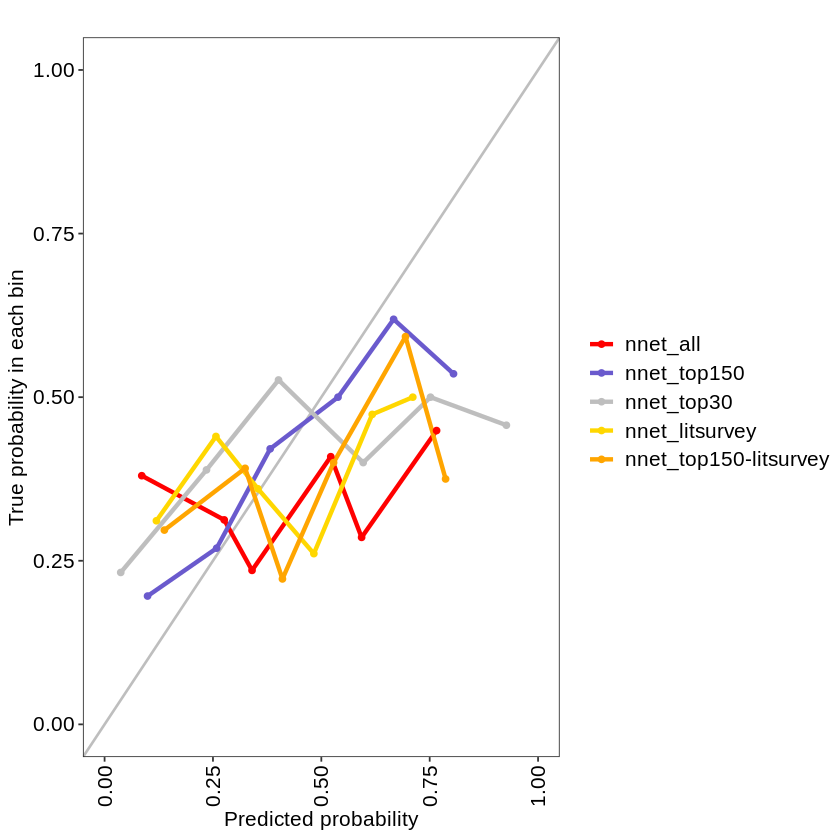

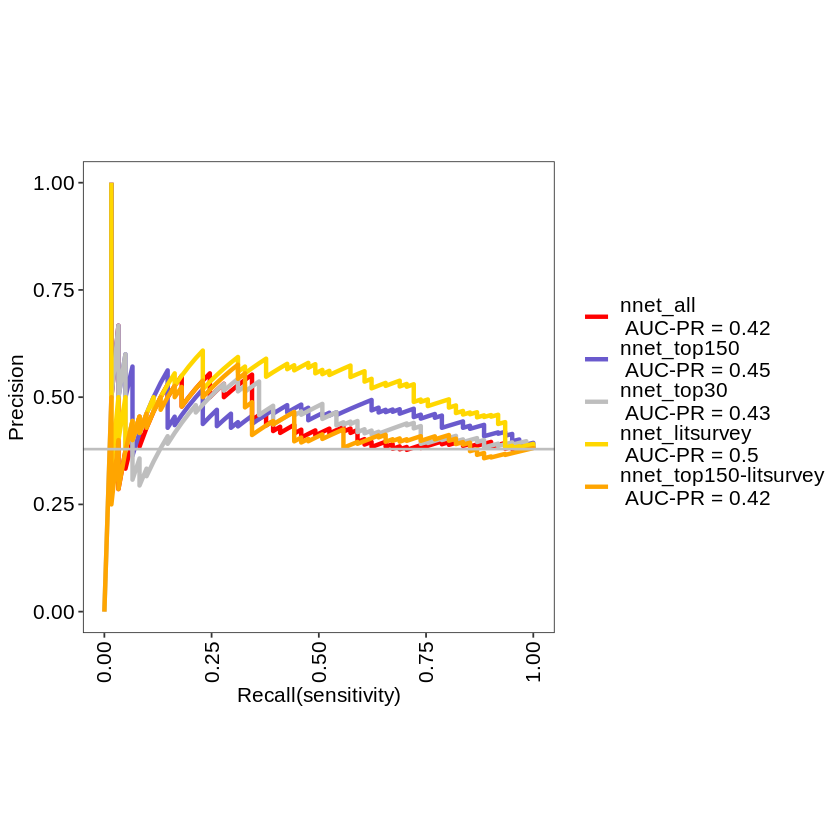

nnet_all Optimal Informedness = 0.174262295081967

nnet_top150 Optimal Informedness = 0.232950819672131

nnet_top30 Optimal Informedness = 0.178196721311475

nnet_litsurvey Optimal Informedness = 0.331311475409836

nnet_top150-litsurvey Optimal Informedness = 0.171475409836066

nnet_all AUC-ROC = 0.56

nnet_top150 AUC-ROC = 0.62

nnet_top30 AUC-ROC = 0.58

nnet_litsurvey AUC-ROC = 0.69

nnet_top150-litsurvey AUC-ROC = 0.55



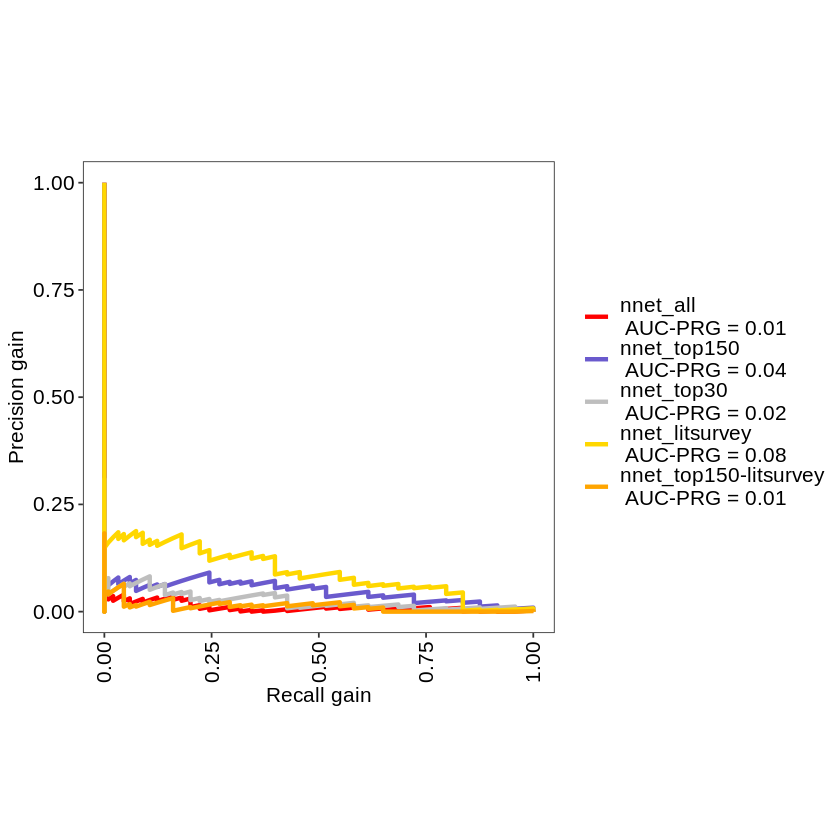

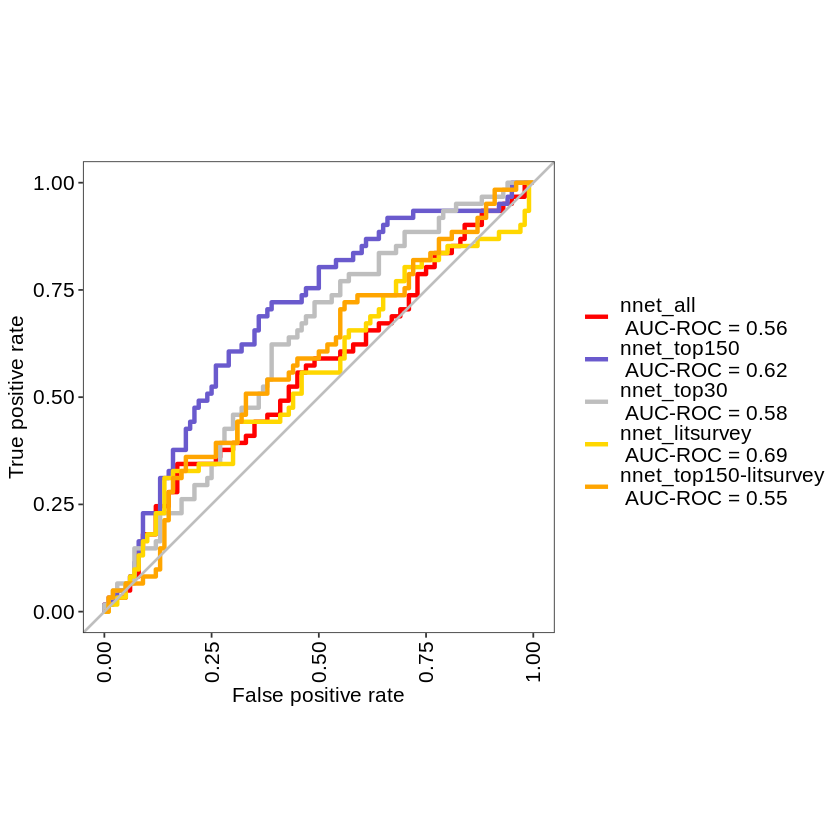

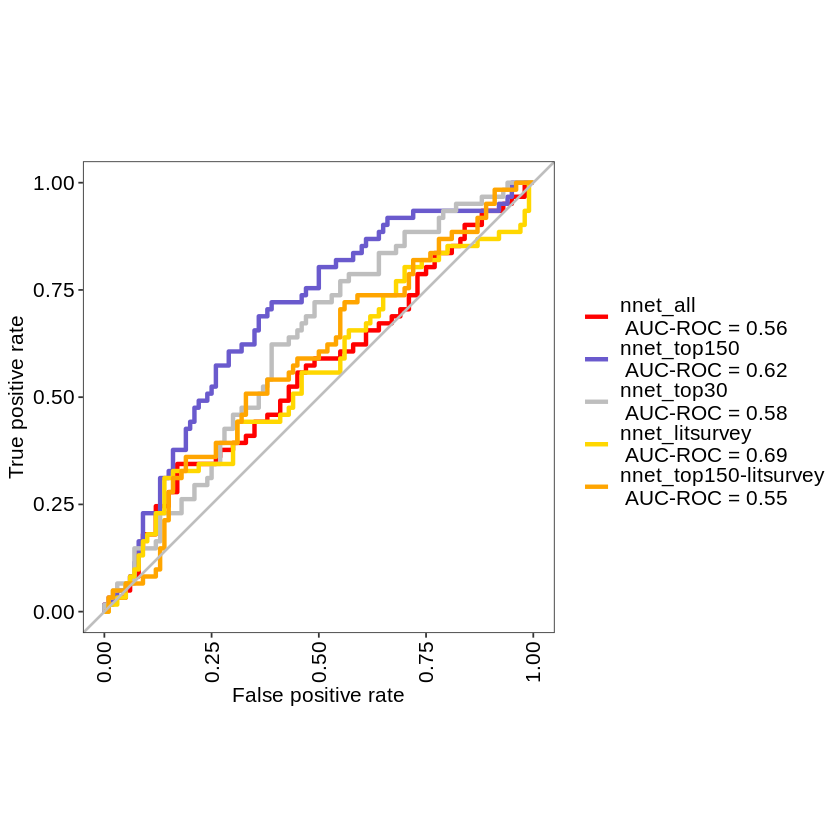

In [64]:
inp_all_nnet <- train(Response ~ .,data=mod_inp_mat,
              method="nnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150_nnet <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])],
              method="nnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top30_nnet <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"])],
              method="nnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_nnet <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="nnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150litsurvey_nnet <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="nnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_nnet <- evalm(list(inp_all_nnet, inp_top150_nnet, inp_top30_nnet, inp_litsurvey_nnet, inp_top150litsurvey_nnet),
             gnames=c('nnet_all','nnet_top150', 'nnet_top30', 'nnet_litsurvey', 'nnet_top150-litsurvey'))
res_nnet$roc

## Gradient Boosting Machines (GBM)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2893            -nan     0.1000    0.0077
     2        1.2553            -nan     0.1000    0.0107
     3        1.2375            -nan     0.1000   -0.0042
     4        1.2226            -nan     0.1000   -0.0002
     5        1.2083            -nan     0.1000   -0.0016
     6        1.1913            -nan     0.1000   -0.0019
     7        1.1728            -nan     0.1000    0.0004
     8        1.1533            -nan     0.1000    0.0029
     9        1.1388            -nan     0.1000   -0.0002
    10        1.1133            -nan     0.1000    0.0024
    20        1.0026            -nan     0.1000   -0.0051
    40        0.7999            -nan     0.1000   -0.0027
    60        0.6584            -nan     0.1000   -0.0040
    80        0.5447            -nan     0.1000   -0.0032
   100        0.4526            -nan     0.1000   -0.0012
   120        0.3811            -nan     0.1000   -0.0006
   140        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2933            -nan     0.1000    0.0094
     2        1.2804            -nan     0.1000   -0.0026
     3        1.2592            -nan     0.1000   -0.0006
     4        1.2354            -nan     0.1000    0.0012
     5        1.2164            -nan     0.1000    0.0022
     6        1.2027            -nan     0.1000   -0.0009
     7        1.1862            -nan     0.1000   -0.0024
     8        1.1725            -nan     0.1000   -0.0012
     9        1.1570            -nan     0.1000    0.0013
    10        1.1489            -nan     0.1000   -0.0047
    20        1.0116            -nan     0.1000   -0.0052
    40        0.8245            -nan     0.1000   -0.0003
    60        0.6863            -nan     0.1000    0.0018
    80        0.5915            -nan     0.1000   -0.0016
   100        0.5152            -nan     0.1000   -0.0025
   120        0.4321            -nan     0.1000   -0.0015
   140        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3041            -nan     0.1000    0.0105
     2        1.2898            -nan     0.1000    0.0011
     3        1.2682            -nan     0.1000    0.0115
     4        1.2507            -nan     0.1000    0.0035
     5        1.2419            -nan     0.1000   -0.0026
     6        1.2292            -nan     0.1000   -0.0070
     7        1.2083            -nan     0.1000    0.0026
     8        1.1950            -nan     0.1000    0.0024
     9        1.1800            -nan     0.1000    0.0038
    10        1.1706            -nan     0.1000   -0.0030
    20        1.0934            -nan     0.1000   -0.0020
    40        0.9942            -nan     0.1000   -0.0008
    60        0.9138            -nan     0.1000   -0.0053
    80        0.8510            -nan     0.1000   -0.0039
   100        0.7881            -nan     0.1000   -0.0000
   120        0.7397            -nan     0.1000   -0.0023
   140        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3085            -nan     0.1000    0.0021
     2        1.2687            -nan     0.1000    0.0089
     3        1.2455            -nan     0.1000    0.0023
     4        1.2277            -nan     0.1000    0.0084
     5        1.2116            -nan     0.1000    0.0041
     6        1.2055            -nan     0.1000   -0.0081
     7        1.1941            -nan     0.1000   -0.0044
     8        1.1892            -nan     0.1000   -0.0051
     9        1.1787            -nan     0.1000    0.0027
    10        1.1692            -nan     0.1000   -0.0009
    20        1.0719            -nan     0.1000    0.0045
    40        0.9361            -nan     0.1000   -0.0030
    60        0.8417            -nan     0.1000   -0.0036
    80        0.7550            -nan     0.1000   -0.0033
   100        0.6780            -nan     0.1000   -0.0015
   120        0.6266            -nan     0.1000   -0.0058
   140        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3018            -nan     0.1000    0.0038
     2        1.2839            -nan     0.1000   -0.0008
     3        1.2595            -nan     0.1000   -0.0010
     4        1.2442            -nan     0.1000    0.0005
     5        1.2285            -nan     0.1000    0.0037
     6        1.2218            -nan     0.1000   -0.0054
     7        1.2095            -nan     0.1000   -0.0062
     8        1.1978            -nan     0.1000   -0.0060
     9        1.1817            -nan     0.1000   -0.0006
    10        1.1711            -nan     0.1000    0.0014
    20        1.1011            -nan     0.1000   -0.0011
    40        0.9910            -nan     0.1000   -0.0013
    60        0.9141            -nan     0.1000    0.0000
    80        0.8492            -nan     0.1000   -0.0018
   100        0.8000            -nan     0.1000   -0.0048
   120        0.7431            -nan     0.1000   -0.0005
   140        

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 805

Number of groups: 5

Observations per group: 161

Positive: Y

Negative: N

Group: gbm_all

Positive: 61

Negative: 100

Group: gbm_top150

Positive: 61

Negative: 100

Group: gbm_top30

Positive: 61

Negative: 100

Group: gbm_litsurvey

Positive: 61

Negative: 100

Group: gbm_top150-litsurvey

Positive: 61

Negative: 100

***Performance Metrics***



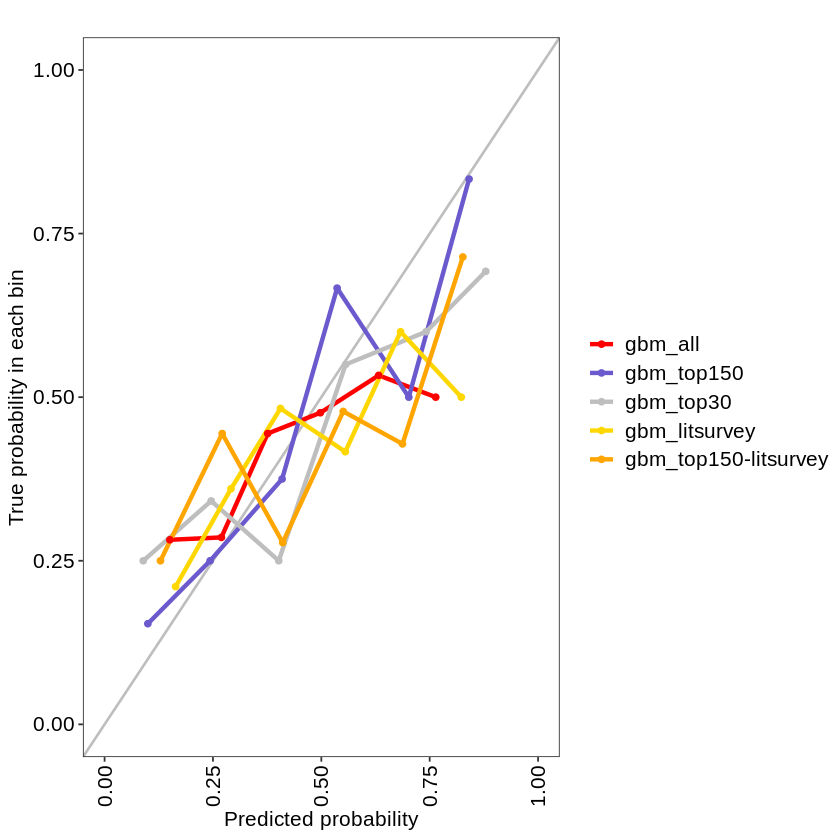

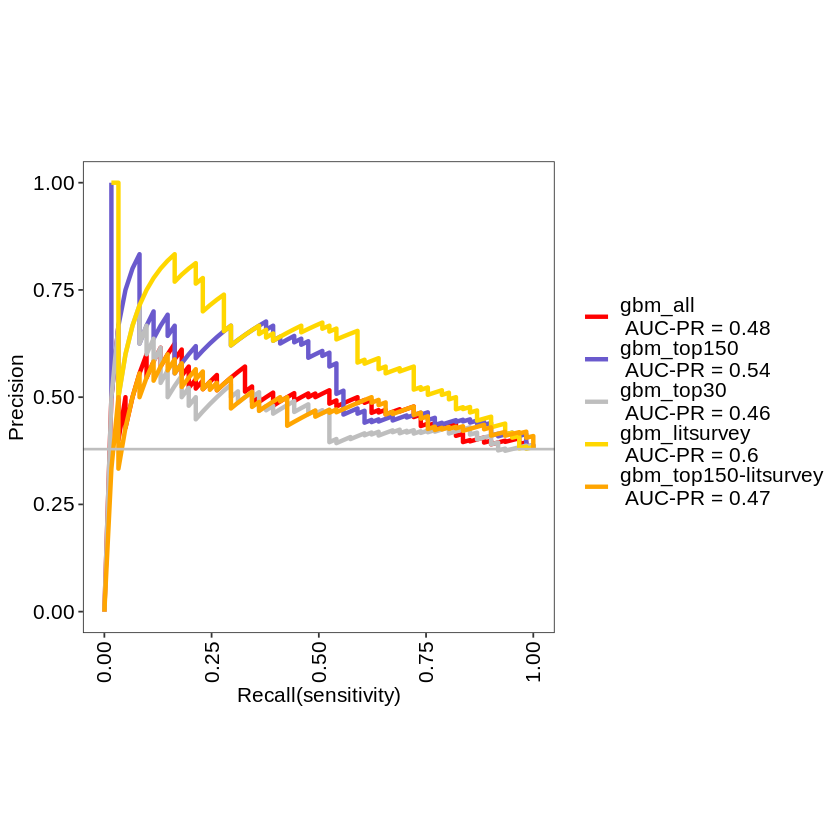

gbm_all Optimal Informedness = 0.241311475409836

gbm_top150 Optimal Informedness = 0.314590163934426

gbm_top30 Optimal Informedness = 0.165409836065574

gbm_litsurvey Optimal Informedness = 0.40016393442623

gbm_top150-litsurvey Optimal Informedness = 0.242950819672131

gbm_all AUC-ROC = 0.63

gbm_top150 AUC-ROC = 0.67

gbm_top30 AUC-ROC = 0.59

gbm_litsurvey AUC-ROC = 0.73

gbm_top150-litsurvey AUC-ROC = 0.63



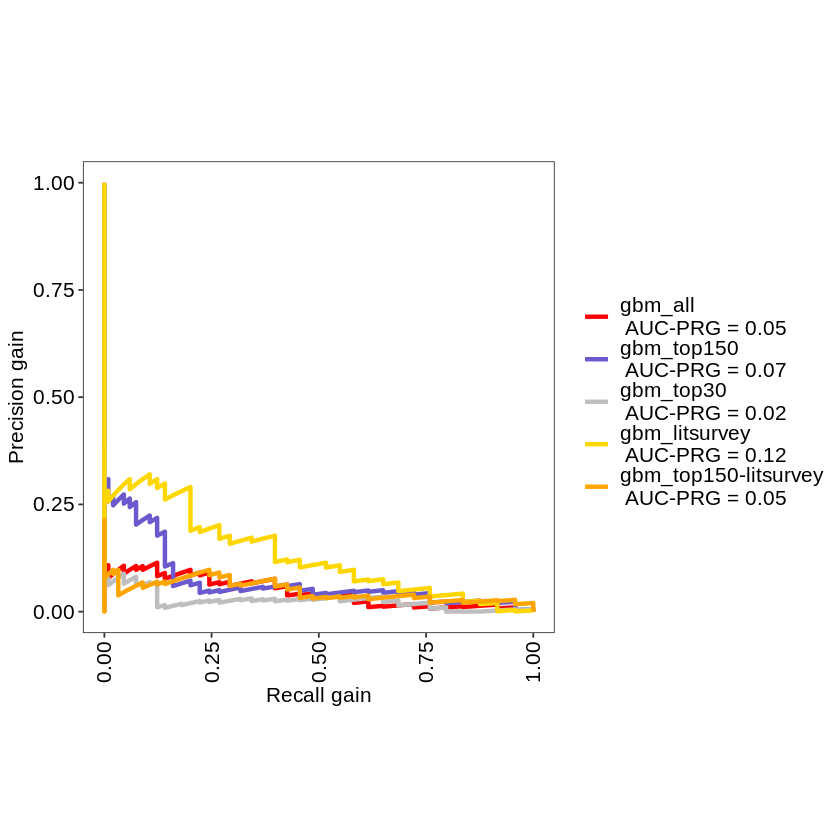

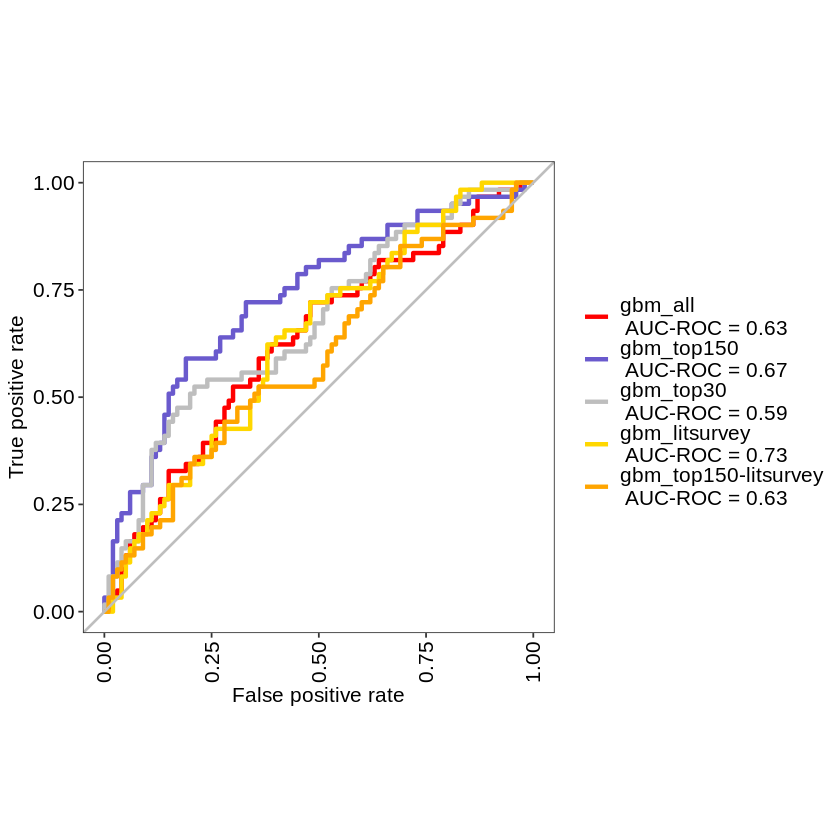

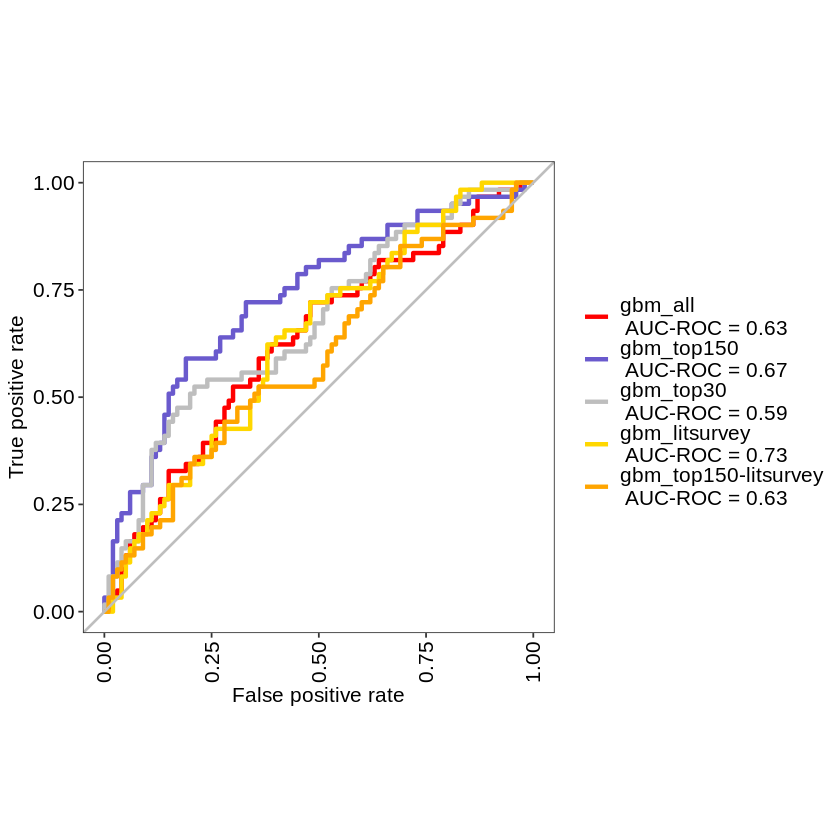

In [65]:
inp_all_gbm <- train(Response ~ .,data=mod_inp_mat,
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150_gbm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])],
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top30_gbm <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"])],
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_gbm <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150litsurvey_gbm <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_gbm <- evalm(list(inp_all_gbm, inp_top150_gbm, inp_top30_gbm, inp_litsurvey_gbm, inp_top150litsurvey_gbm),
             gnames=c('gbm_all','gbm_top150', 'gbm_top30', 'gbm_litsurvey', 'gbm_top150-litsurvey'))
res_gbm$roc

## Partial Least Squares

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 805

Number of groups: 5

Observations per group: 161

Positive: Y

Negative: N

Group: pls_all

Positive: 61

Negative: 100

Group: pls_top150

Positive: 61

Negative: 100

Group: pls_top30

Positive: 61

Negative: 100

Group: pls_litsurvey

Positive: 61

Negative: 100

Group: pls_top150-litsurvey

Positive: 61

Negative: 100

***Performance Metrics***



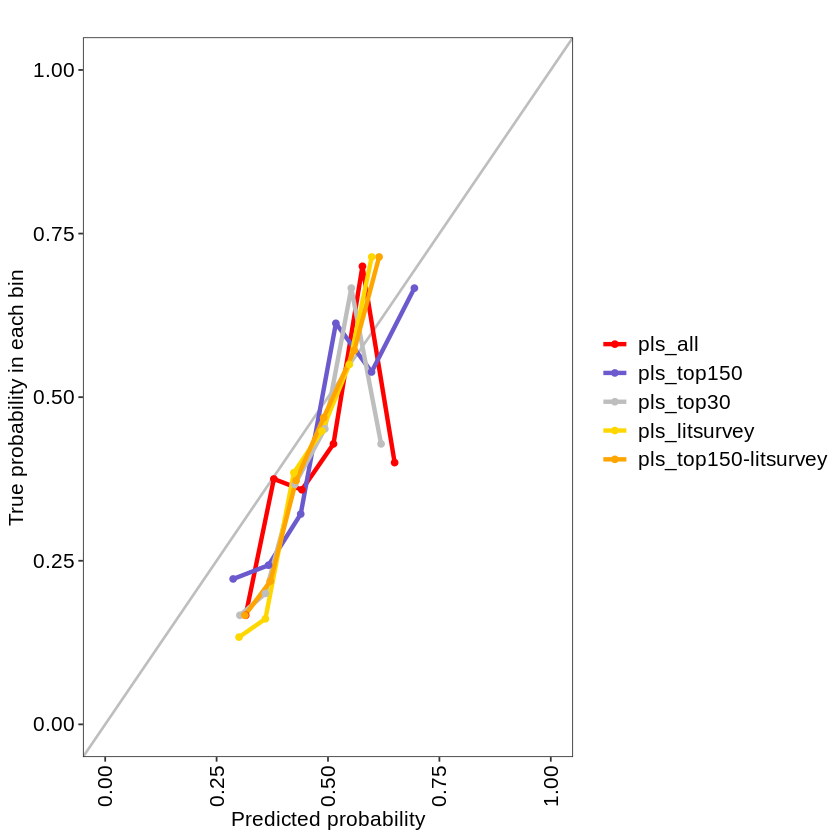

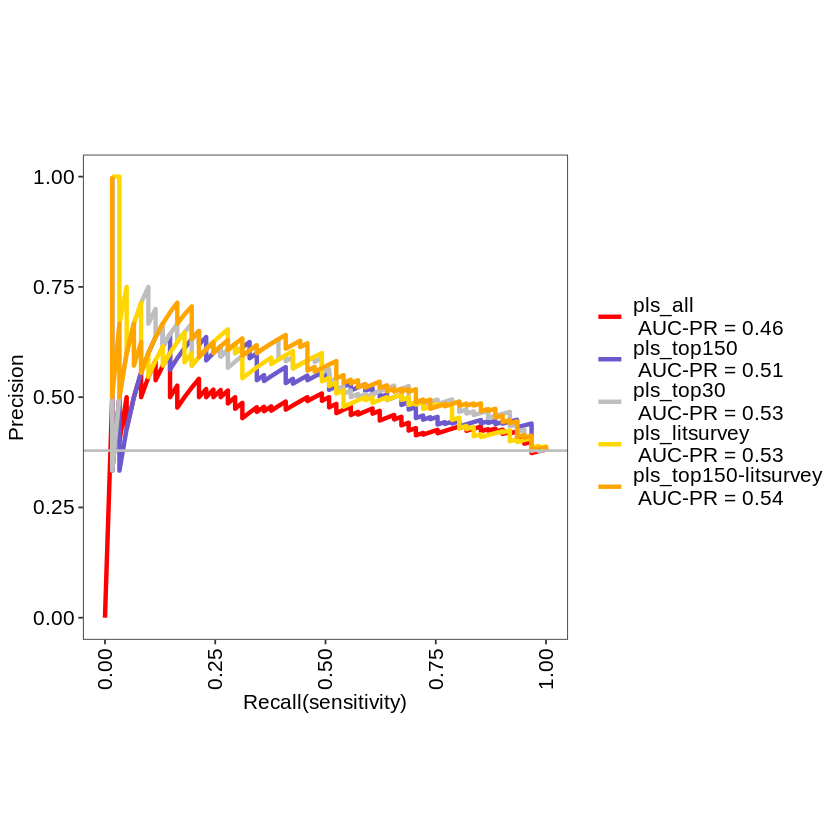

pls_all Optimal Informedness = 0.201803278688525

pls_top150 Optimal Informedness = 0.272131147540984

pls_top30 Optimal Informedness = 0.308524590163934

pls_litsurvey Optimal Informedness = 0.291803278688525

pls_top150-litsurvey Optimal Informedness = 0.304918032786885

pls_all AUC-ROC = 0.62

pls_top150 AUC-ROC = 0.67

pls_top30 AUC-ROC = 0.69

pls_litsurvey AUC-ROC = 0.67

pls_top150-litsurvey AUC-ROC = 0.7



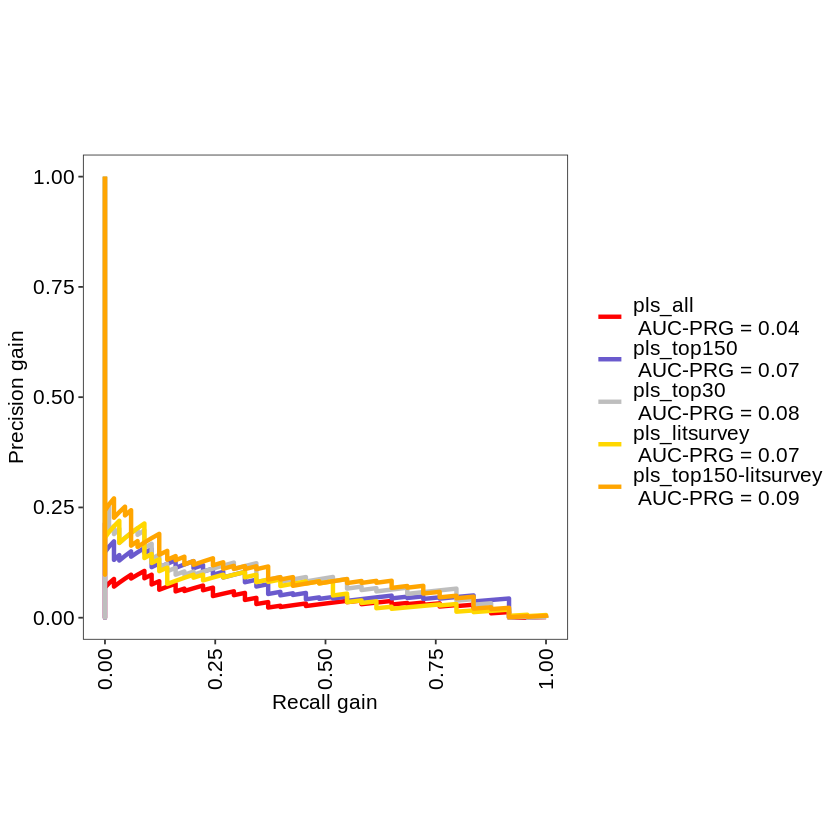

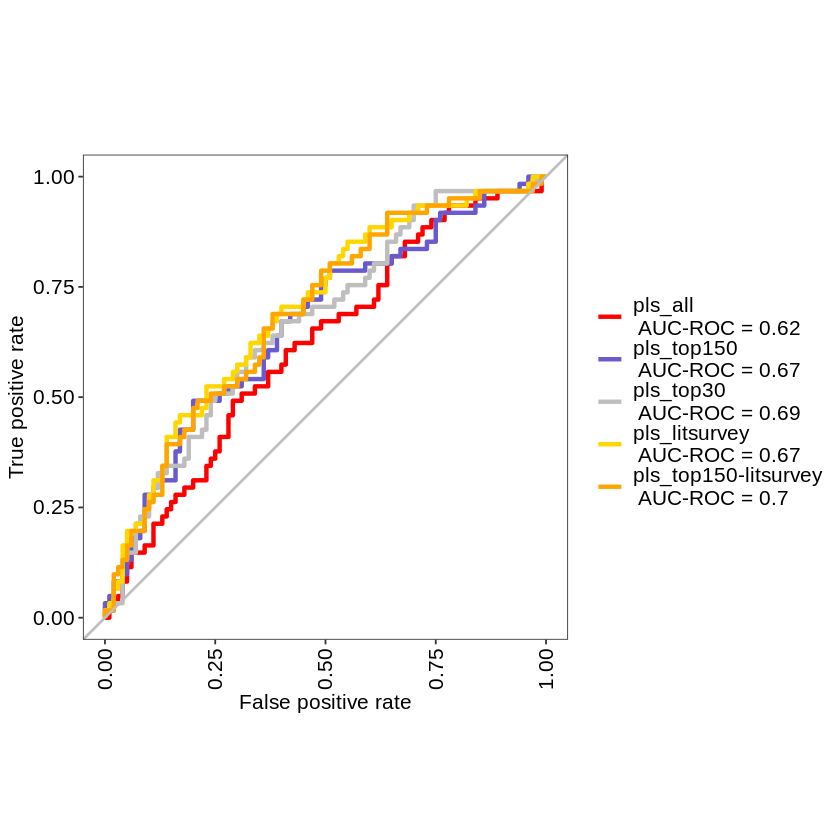

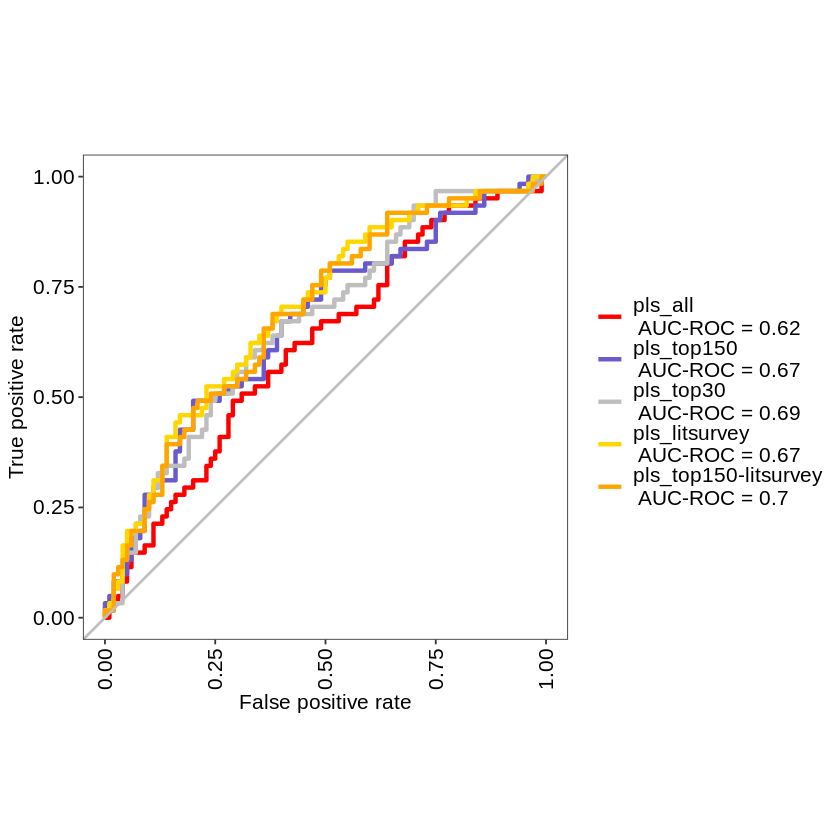

In [66]:
inp_all_pls <- train(Response ~ .,data=mod_inp_mat,
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150_pls <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])],
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top30_pls <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"])],
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_pls <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150litsurvey_pls <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_pls <- evalm(list(inp_all_pls, inp_top150_pls, inp_top30_pls, inp_litsurvey_pls, inp_top150litsurvey_pls),
             gnames=c('pls_all','pls_top150', 'pls_top30', 'pls_litsurvey', 'pls_top150-litsurvey'))
res_pls$roc

## Random Forest

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 805

Number of groups: 5

Observations per group: 161

Positive: Y

Negative: N

Group: rf_all

Positive: 61

Negative: 100

Group: rf_top150

Positive: 61

Negative: 100

Group: rf_top30

Positive: 61

Negative: 100

Group: rf_litsurvey

Positive: 61

Negative: 100

Group: rf_top150-litsurvey

Positive: 61

Negative: 100

***Performance Metrics***



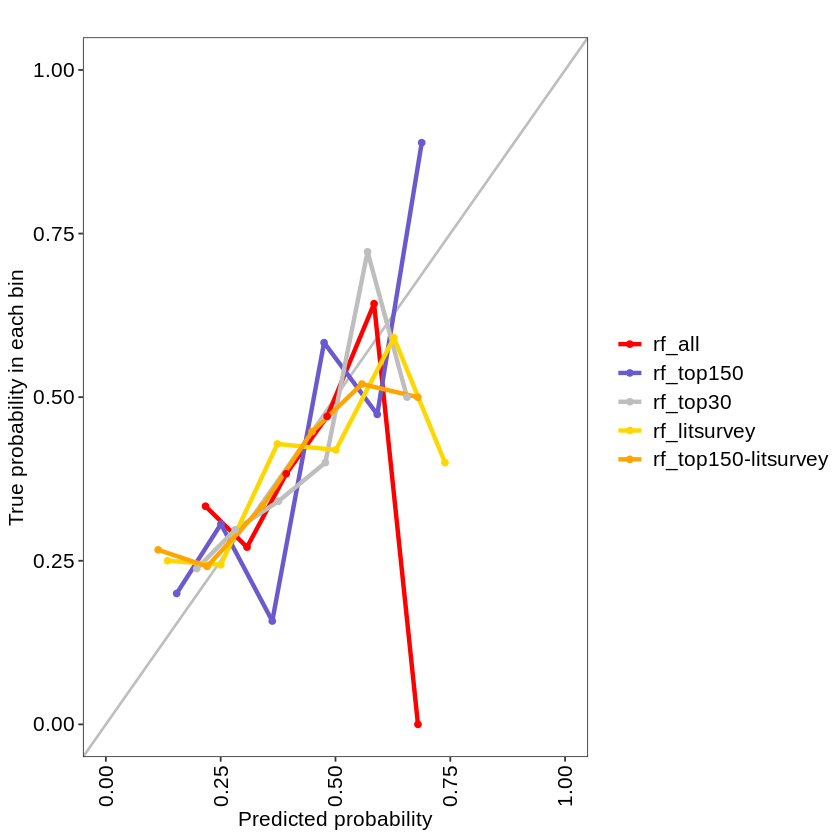

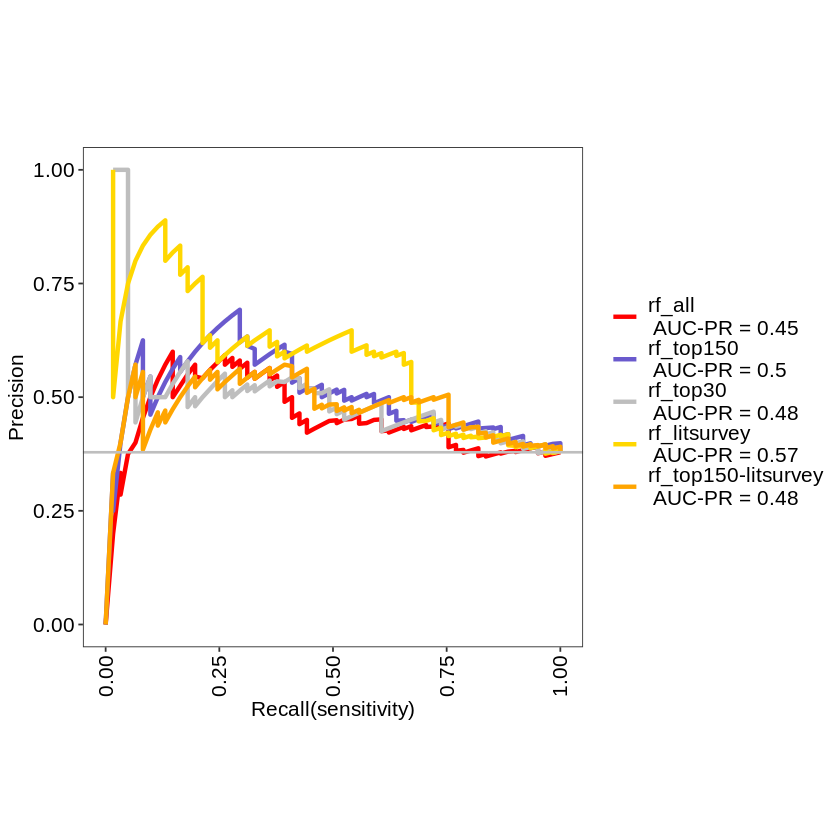

rf_all Optimal Informedness = 0.190655737704918

rf_top150 Optimal Informedness = 0.24344262295082

rf_top30 Optimal Informedness = 0.221311475409836

rf_litsurvey Optimal Informedness = 0.385737704918033

rf_top150-litsurvey Optimal Informedness = 0.304098360655738

rf_all AUC-ROC = 0.58

rf_top150 AUC-ROC = 0.65

rf_top30 AUC-ROC = 0.62

rf_litsurvey AUC-ROC = 0.68

rf_top150-litsurvey AUC-ROC = 0.64



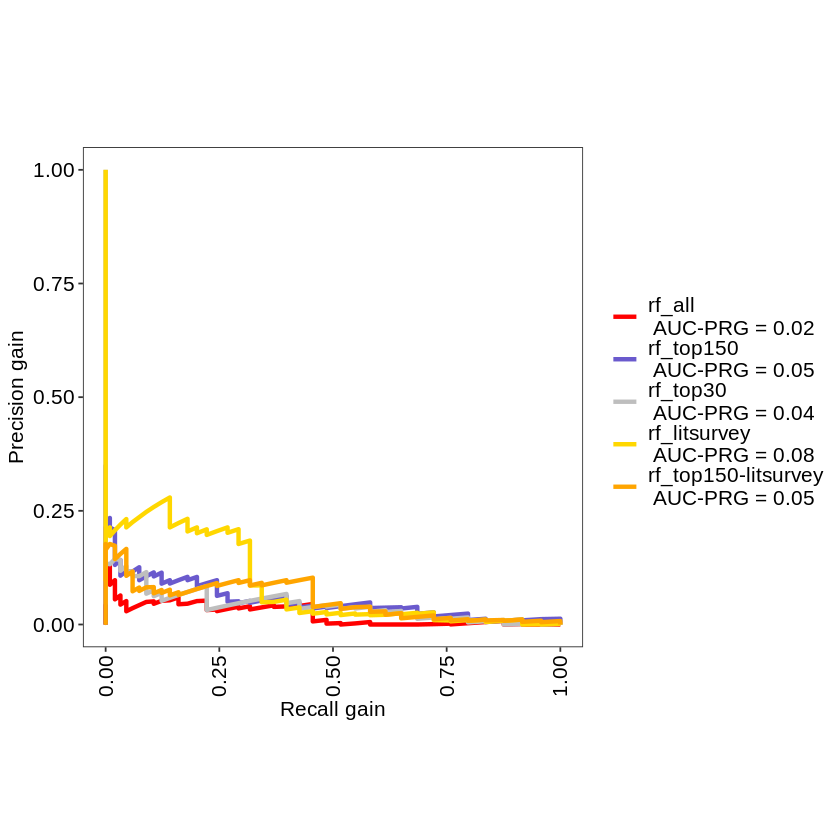

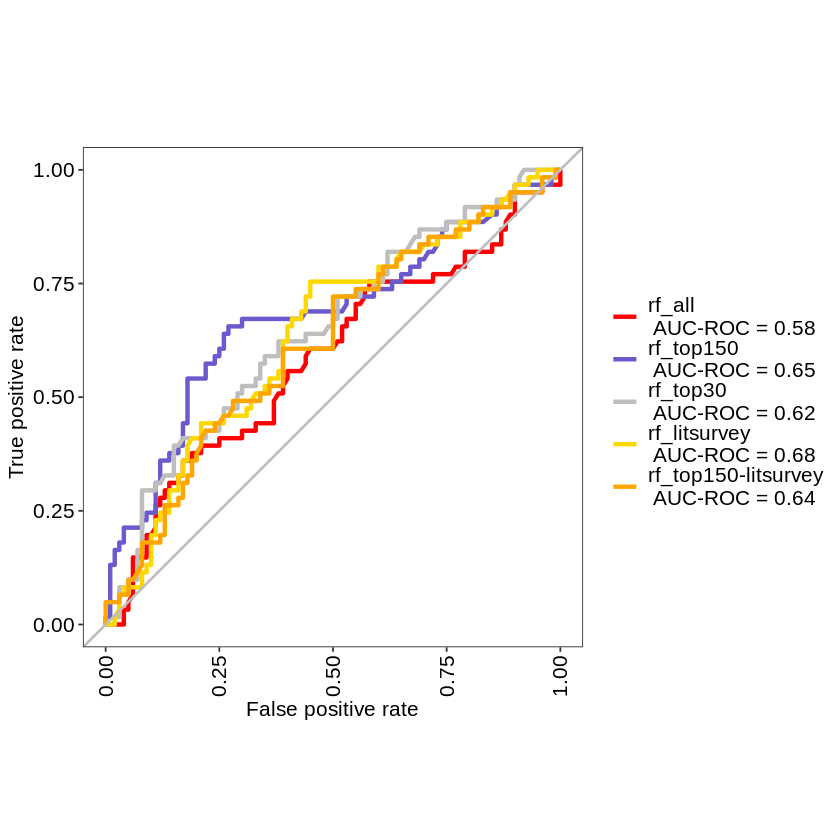

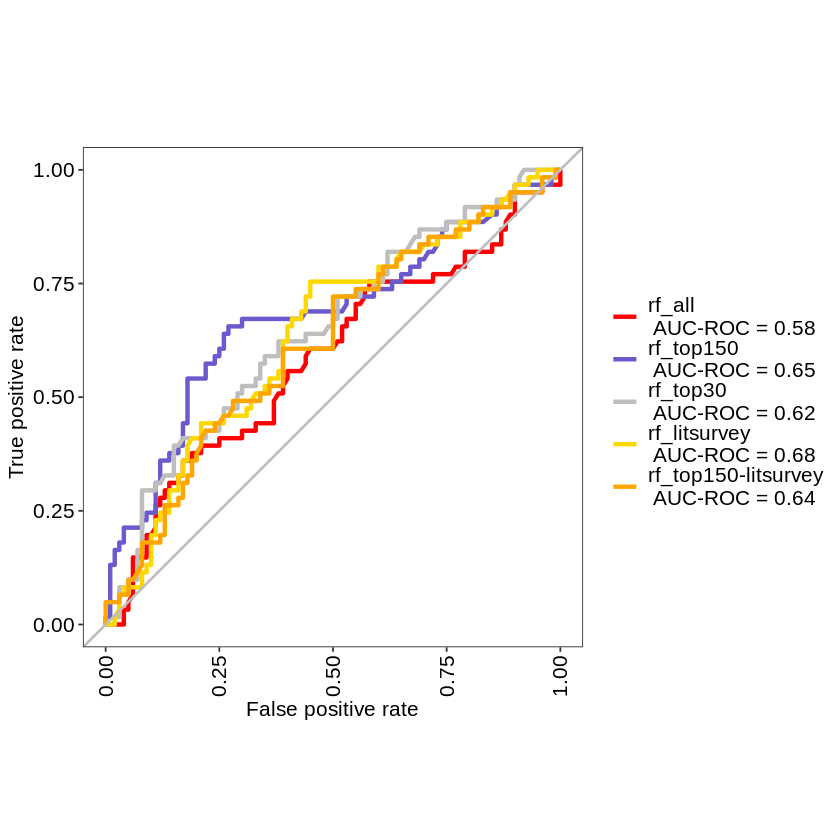

In [67]:
ctrl <- trainControl(method="repeatedcv", number=10, repeats=3, 
                     summaryFunction=twoClassSummary, classProbs=T,savePredictions = T)

inp_all_rf <- train(Response ~ .,data=mod_inp_mat,
              method="rf",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150_rf <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])],
              method="rf",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top30_rf <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"])],
              method="rf",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_rf <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="rf",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150litsurvey_rf <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="rf",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_rf <- evalm(list(inp_all_rf, inp_top150_rf, inp_top30_rf, inp_litsurvey_rf, inp_top150litsurvey_rf),
             gnames=c('rf_all','rf_top150', 'rf_top30', 'rf_litsurvey', 'rf_top150-litsurvey'))
res_rf$roc

## Linear Discriminant Analysis with Stepwise Feature Selection

 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67619;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.488 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67952;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.477 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66952;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.522 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6781;  in: "`3669`";  variables (1): `3669` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.781 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69143;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.445 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68857;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.457 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68238;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.437 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.756 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68429;  in: "`2919`";  variables (1): `2919` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.429 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68238;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.458 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67524;  in: "`3669`";  variables (1): `3669` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.444 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67381;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.754 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68095;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.439 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66762;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00       11.45 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68429;  in: "`925`";  variables (1): `925` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.452 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68905;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.422 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67095;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.439 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67619;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.492 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66286;  in: "`7128`";  variables (1): `7128` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.473 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67476;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.438 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6581;  in: "`9308`";  variables (1): `9308` 
correctness rate: 0.7119;  in: "`81035`";  variables (2): `9308`, `81035` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      17.587 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66286;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.458 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67048;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.519 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.743 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69095;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.465 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68381;  in: "`6504`";  variables (1): `6504` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.452 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.495 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68714;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.708 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.461 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67762;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.483 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

161 observations of 504 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67059;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000      11.643 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6781;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.296 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`3107`";  variables (1): `3107` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        3.28 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68143;  in: "`3265`";  variables (1): `3265` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.551 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67571;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        3.26 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66333;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.281 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67048;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.272 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67524;  in: "`3669`";  variables (1): `3669` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.265 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68429;  in: "`3669`";  variables (1): `3669` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.277 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68333;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.263 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67143;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.294 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.263 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67905;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.284 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.287 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69095;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.274 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67524;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.297 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69619;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.288 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.554 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66095;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        3.26 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68333;  in: "`6504`";  variables (1): `6504` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        3.27 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67619;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.282 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68476;  in: "`3669`";  variables (1): `3669` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.277 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67143;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.279 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.279 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67714;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.283 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67429;  in: "`843`";  variables (1): `843` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.274 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67524;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        3.28 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6781;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        3.29 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67714;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        3.29 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67524;  in: "`843`";  variables (1): `843` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.307 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67095;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.285 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

161 observations of 144 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67132;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       3.601 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67571;  in: "`925`";  variables (1): `925` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.556 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67619;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.569 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68429;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.569 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67095;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.555 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.568 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67571;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.556 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67762;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.567 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67714;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.569 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.555 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68714;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.567 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67619;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.555 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.71143;  in: "`925`";  variables (1): `925` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.571 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68381;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.57 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67524;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.556 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.571 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.557 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67238;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.568 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67143;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.57 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.555 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.57 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69095;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.556 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68333;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.568 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67619;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.569 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66952;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.556 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67571;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.588 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67571;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.557 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.57 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6819;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.571 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69143;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.556 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.57 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

161 observations of 25 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67279;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.56 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.608 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68381;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.61 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67524;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.595 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68524;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.608 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67048;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.609 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68429;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.626 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.604 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.612 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66857;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.614 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6681;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.601 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66238;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.601 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.65571;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.613 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66952;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.612 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68381;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.612 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.65476;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.601 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68429;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.613 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68857;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.612 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.62 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66857;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.616 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67952;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.601 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66238;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.616 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.65524;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.618 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67095;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.603 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67571;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.616 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67762;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.616 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67048;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.617 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68857;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.602 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67524;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.615 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6619;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.617 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.65714;  in: "`1493`";  variables (1): `1493` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.631 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

161 observations of 27 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67132;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.611 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67095;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.458 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.447 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66333;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.446 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.459 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69476;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.445 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6781;  in: "`6504`";  variables (1): `6504` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.446 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66381;  in: "`8807`";  variables (1): `8807` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.447 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66857;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.458 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6819;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.447 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68286;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.447 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.459 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.445 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68429;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.447 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68238;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.447 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67762;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.747 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68238;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.449 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6781;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.447 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66429;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.458 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.446 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67762;  in: "`7128`";  variables (1): `7128` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.447 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.65619;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.458 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.68476;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.446 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66857;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.446 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67762;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.447 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.69238;  in: "`57823`";  variables (1): `57823` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.446 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6681;  in: "`3620`";  variables (1): `3620` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.446 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

144 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67429;  in: "`6504`";  variables (1): `6504` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.459 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.66905;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.446 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67667;  in: "`9308`";  variables (1): `9308` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.446 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

145 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.67095;  in: "`29126`";  variables (1): `29126` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.459 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

161 observations of 20 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.6761;  in: "`3574`";  variables (1): `3574` 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.464 



***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 805

Number of groups: 5

Observations per group: 161

Positive: Y

Negative: N

Group: lda_all

Positive: 61

Negative: 100

Group: lda_top150

Positive: 61

Negative: 100

Group: lda_top30

Positive: 61

Negative: 100

Group: lda_litsurvey

Positive: 61

Negative: 100

Group: lda_top150-litsurvey

Positive: 61

Negative: 100

***Performance Metrics***



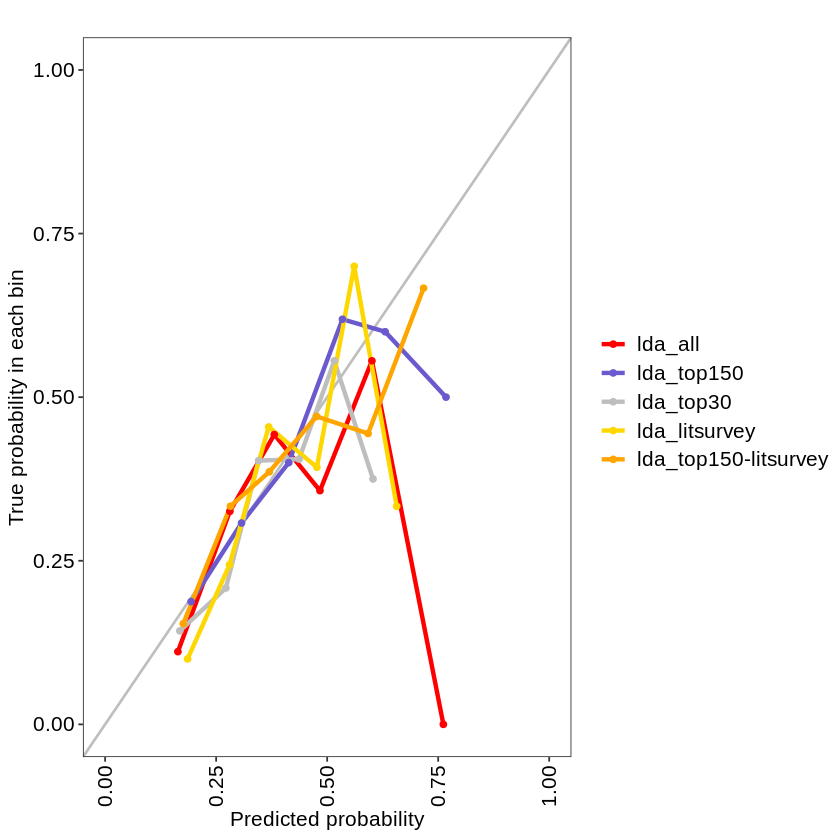

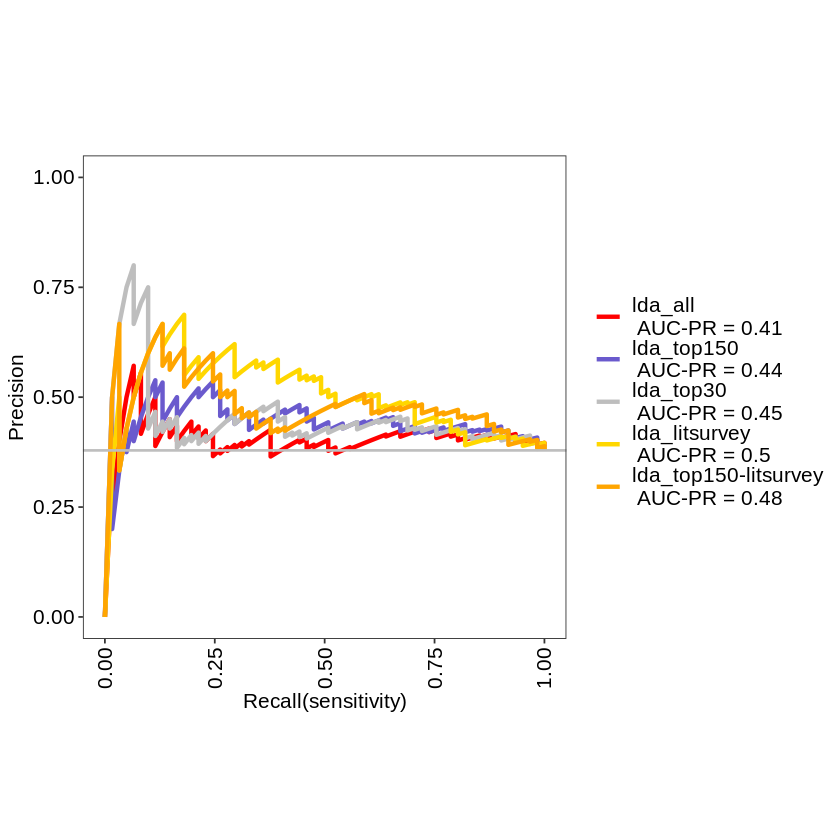

lda_all Optimal Informedness = 0.137704918032787

lda_top150 Optimal Informedness = 0.181639344262295

lda_top30 Optimal Informedness = 0.182131147540983

lda_litsurvey Optimal Informedness = 0.254918032786885

lda_top150-litsurvey Optimal Informedness = 0.25327868852459

lda_all AUC-ROC = 0.55

lda_top150 AUC-ROC = 0.6

lda_top30 AUC-ROC = 0.59

lda_litsurvey AUC-ROC = 0.64

lda_top150-litsurvey AUC-ROC = 0.63



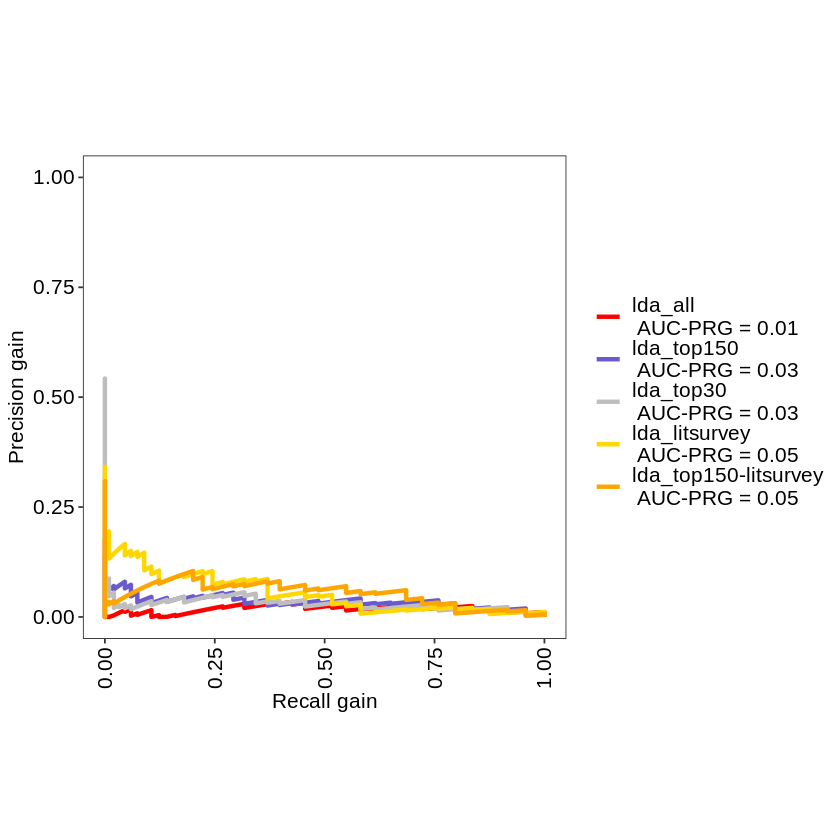

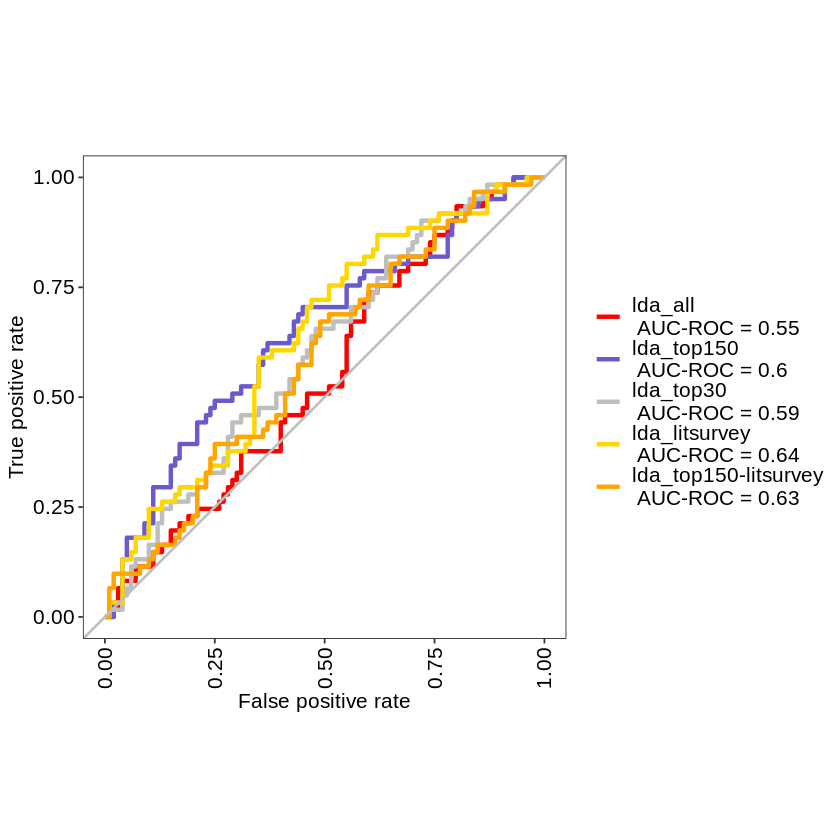

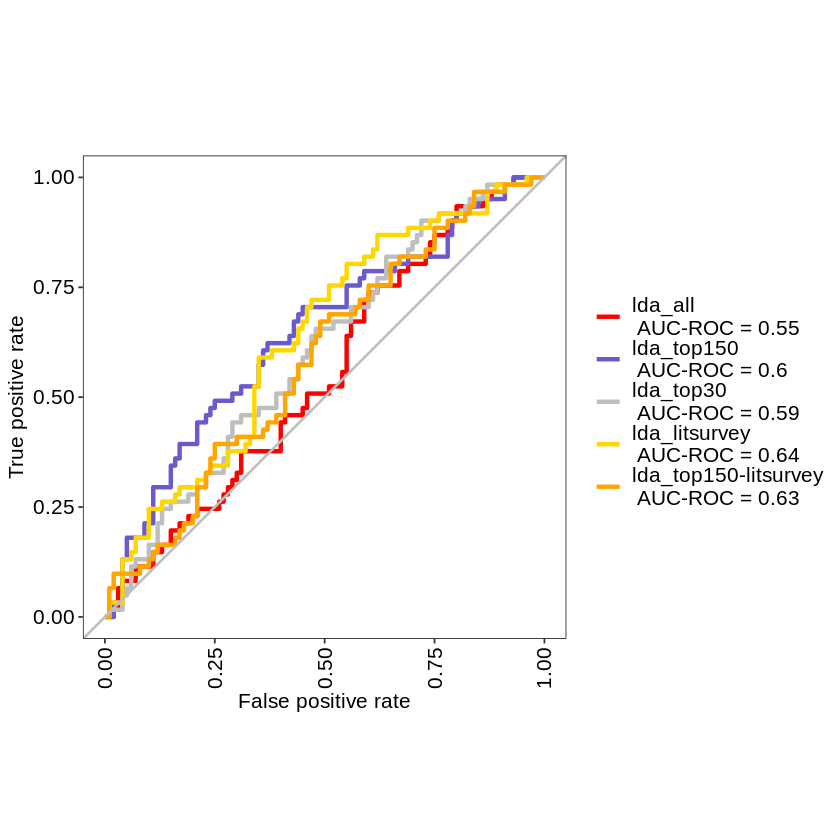

In [68]:
inp_all_lda <- train(Response ~ .,data=mod_inp_mat,
              method="stepLDA",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150_lda <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])],
              method="stepLDA",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top30_lda <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"])],
              method="stepLDA",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_lda <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="stepLDA",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150litsurvey_lda <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="stepLDA",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_lda <- evalm(list(inp_all_lda, inp_top150_lda, inp_top30_lda, inp_litsurvey_lda, inp_top150litsurvey_lda),
             gnames=c('lda_all','lda_top150', 'lda_top30', 'lda_litsurvey', 'lda_top150-litsurvey'))
res_lda$roc

## Naive Bayes

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Observations: 805

Number of groups: 5

Observations per group: 161

Positive: Y

Negative: N

Group: nb_all

Positive: 61

Negative: 100

Group: nb_top150

Positive: 61

Negative: 100

Group: nb_top30

Positive: 61

Negative: 100

Group: nb_litsurvey

Positive: 61

Negative: 100

Group: nb_top150-litsurvey

Positive: 61

Negative: 100

***Performance Metrics***



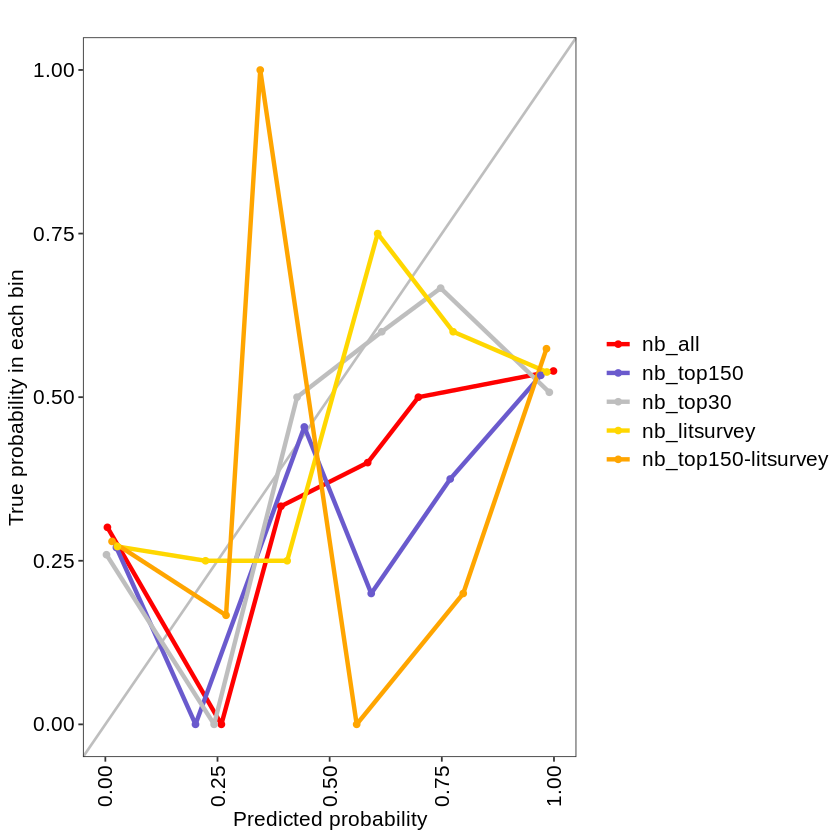

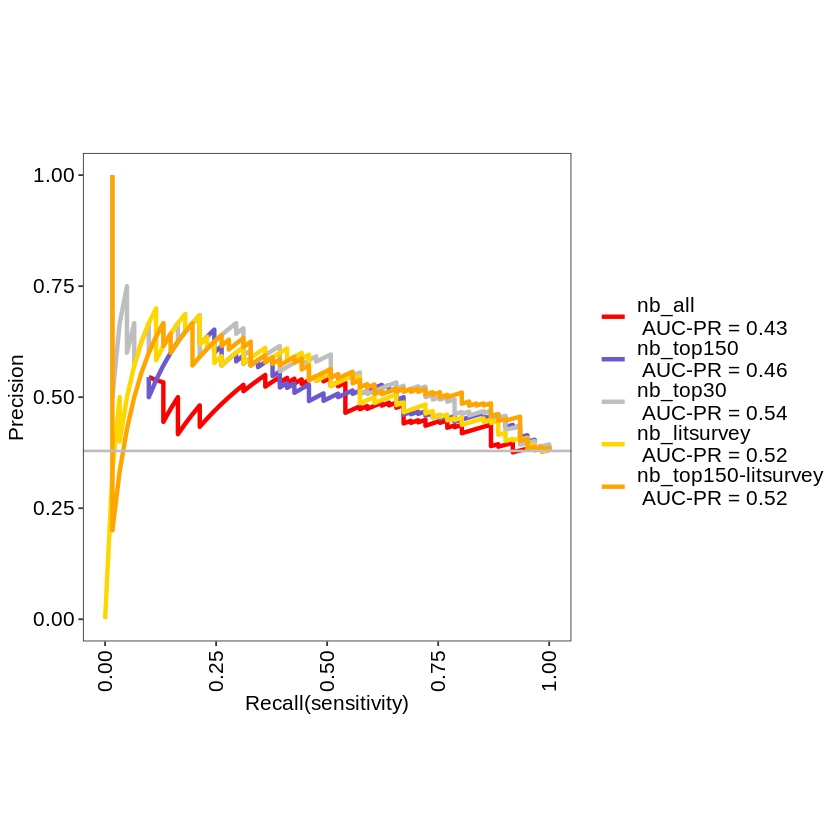

nb_all Optimal Informedness = 0.250983606557377

nb_top150 Optimal Informedness = 0.289344262295082

nb_top30 Optimal Informedness = 0.321311475409836

nb_litsurvey Optimal Informedness = 0.283770491803279

nb_top150-litsurvey Optimal Informedness = 0.33327868852459

nb_all AUC-ROC = 0.63

nb_top150 AUC-ROC = 0.67

nb_top30 AUC-ROC = 0.69

nb_litsurvey AUC-ROC = 0.67

nb_top150-litsurvey AUC-ROC = 0.69



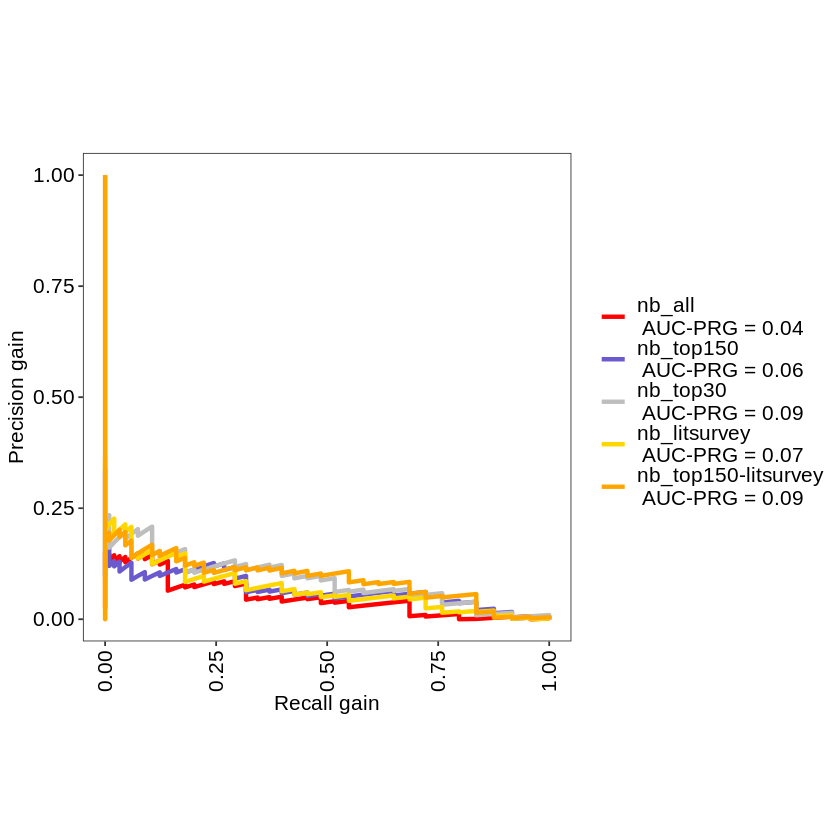

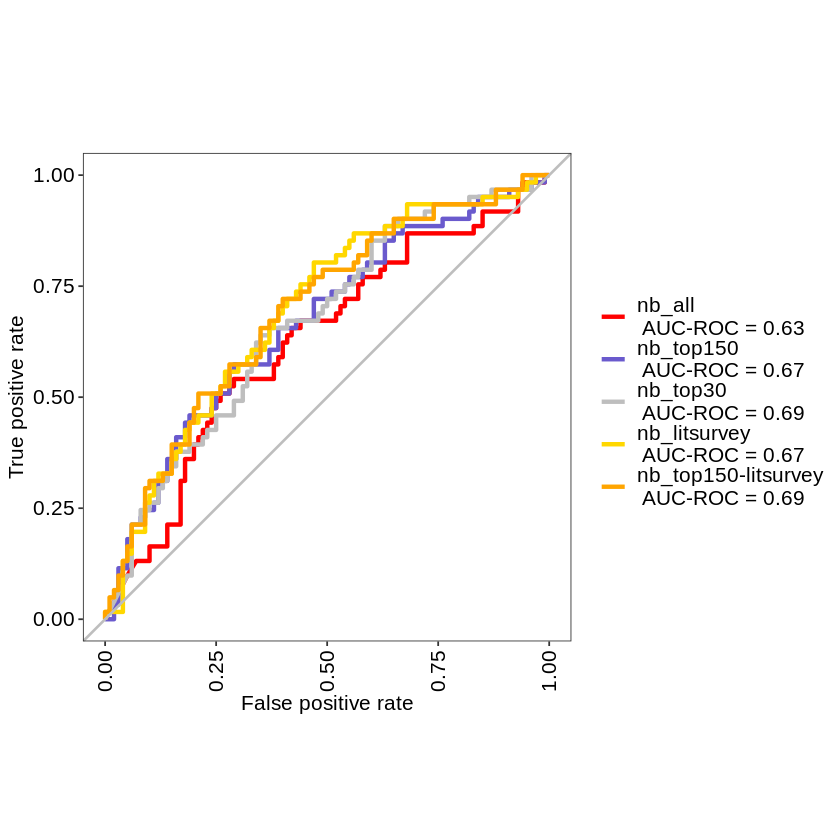

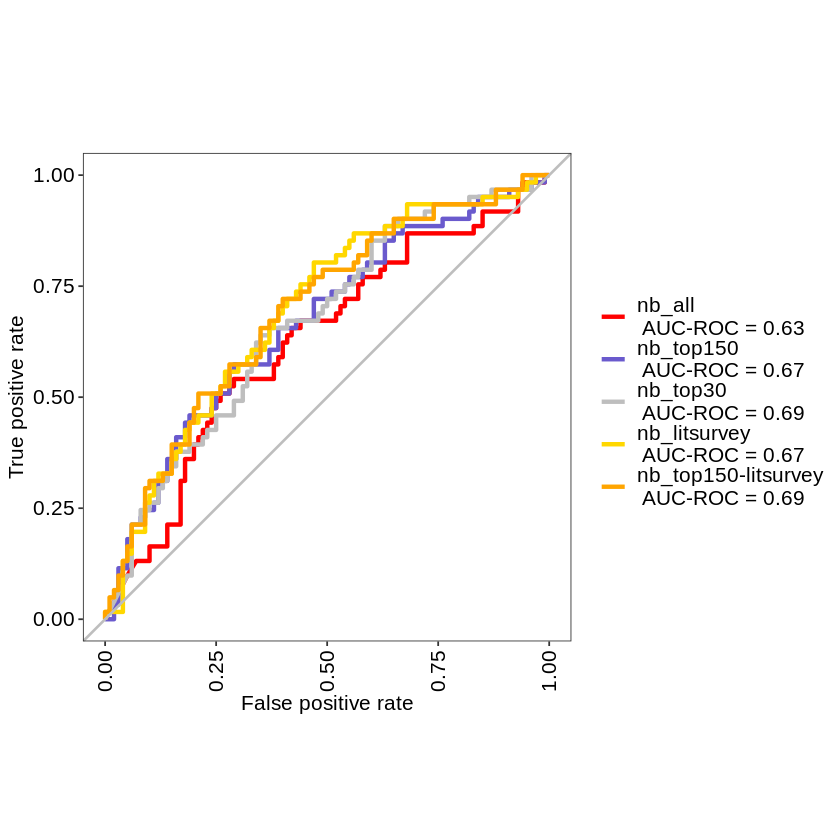

In [69]:
inp_all_nb <- train(Response ~ .,data=mod_inp_mat,
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150_nb <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])],
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top30_nb <- train(Response ~ ., data=mod_inp_mat[,c("Response", all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"])],
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_litsurvey_nb <- train(Response ~ ., data=mod_inp_mat[,c("Response", genes_lit_rawdata)],
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

inp_top150litsurvey_nb <- train(Response ~ ., data=mod_inp_mat[,c("Response", top_genes_out)],
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

res_nb <- evalm(list(inp_all_nb, inp_top150_nb, inp_top30_nb, inp_litsurvey_nb, inp_top150litsurvey_nb),
             gnames=c('nb_all','nb_top150', 'nb_top30', 'nb_litsurvey', 'nb_top150-litsurvey'))
res_nb$roc

ROC-AUC Graphs available at https://github.com/runtime-terror101/ICP-Responders/tree/master/ICP_Responders/ROC_AUC%20analysis

## Comparison

In [66]:
length(which(genes_lit_rawdata %in% 
             all.rank[all.rank$Threshold.250 >= 4, "Gene_ID"]))
length(which(genes_lit_rawdata %in% 
             all.rank[all.rank$Threshold.200 >= 4, "Gene_ID"]))
length(which(genes_lit_rawdata %in% 
             all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"]))
length(which(genes_lit_rawdata %in% 
             all.rank[all.rank$Threshold.100 >= 4, "Gene_ID"]))
length(which(genes_lit_rawdata %in% 
             all.rank[all.rank$Threshold.50 >= 4, "Gene_ID"]))



[1] 10

[1] 9

[1] 9

[1] 8

[1] 6

In [70]:
length(which(genes_lit_rawdata %in% 
             all.rank[all.rank$Threshold.30 >= 4, "Gene_ID"]))


[1] 10

# Output

In [56]:
gene_exp_out <- expr_rmcorr
top_genes_out <- all.rank$Gene_ID[which(genes_lit_rawdata %in% 
                                        all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])]

In [57]:
all.rank$Gene_Name[which(genes_lit_rawdata %in% 
                        all.rank[all.rank$Threshold.150 >= 4, "Gene_ID"])]

[1] "CD83"    "SLAMF7"  "IL7"     "SLAMF1"  "IL18RAP" "CD80"    "CXCL1"  
 [8] "IRAK2"   "TAP1"    "ATG5"    "IFNG"    "IDO1"    "CTLA4"   "ICOS"   
[15] "HRAS"    "KLRD1"   "CXCL11"  "TNFAIP3" "CXCL13"  "CD274"

`TODO:` <br>
Find common pathways<br>
Add descriptions for all ml models

set seed<br>

In [197]:
save.image("SavedGeneExpression.Rda")

In [76]:
# #parameter tuning
# modelLookup('lvq')
# # design the parameter tuning grid
# grid <- expand.grid(size=c(5,10,20,50), k=c(1,2,3,4,5))
# # train the model
# model <- train(Species~., data=iris, method="lvq", trControl=control, tuneGrid=grid)

In [77]:
# saveRds(tmp, "tmp.rds")
# # load by giving path
# # tmp <- readRds("path")
# # R
